#  User-Friendly FFDI Analysis Notebook

This notebook contains simplified, beginner-friendly code blocks for performing analysis on Fire Forest Danger Index (FFDI) raster data.

Each section:
- Explains the purpose of the code
- Provides step-by-step process
- Uses meaningful variable names and plots

Please make sure to update any placeholder paths with your actual data directories before running.


In [1]:
# SECTION 1: Reading and summarizing monthly FFDI from multiple methods
import os
import glob
import re
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Make sure the FFDI folder has individual folders for each year, in which the monthly data is then stored. This ensures that the loop to read all the tif files works properly for each step, and no data has to be changed. Code changed from the original or new code will have a comment next to it. Code was run in Visual Studio Code with a runtime of around 2 minutes. 

        date  mean_ffdi
0 2013-01-01  24.219017
1 2013-02-01  26.042311
2 2013-03-01  25.989277
3 2013-04-01  26.441229
4 2013-05-01  23.754728


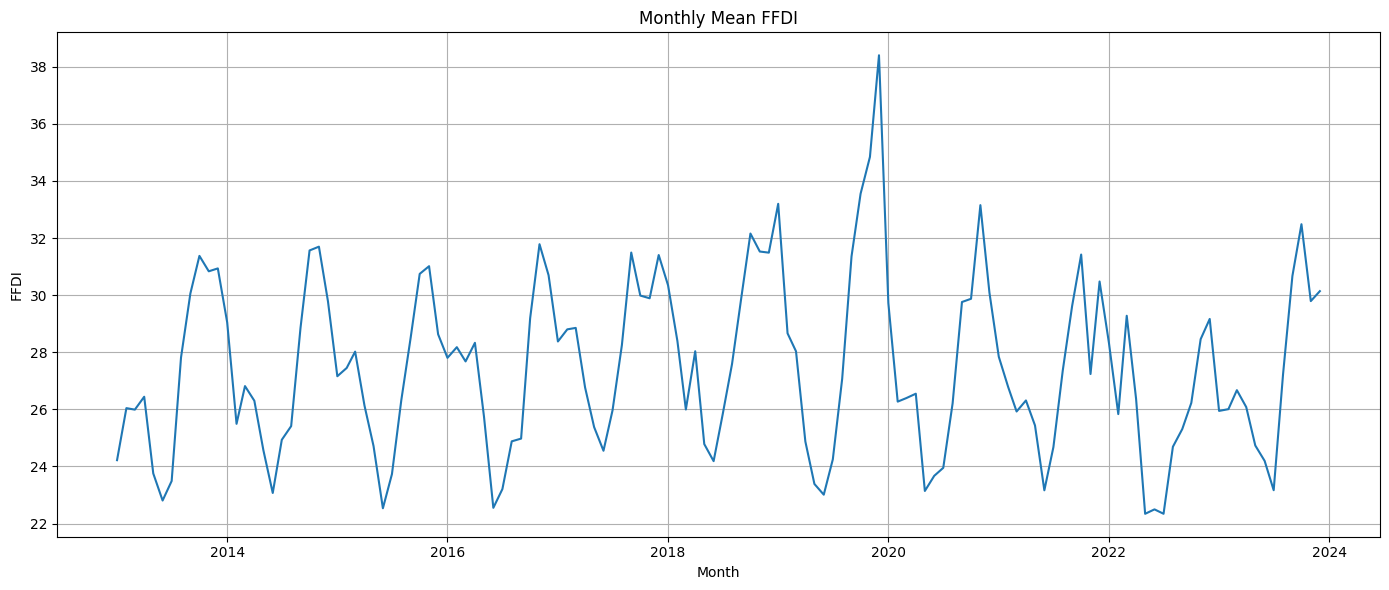


Summary statistics:
count    132.000000
mean      27.461212
std        3.033258
min       22.340363
25%       25.224575
50%       27.192979
75%       29.784877
max       38.404850
Name: mean_ffdi, dtype: float64


In [2]:
# STEP 1: Base folder containing all FFDI rasters
ffdi_folder = "Outputs/ffdi"

# STEP 2: Pattern to extract YYYY_MM from filenames like ffdi_2013_05.tif
date_pattern = re.compile(r'(\d{4})_(\d{2})')

records = []  # Stores (date, mean_ffdi)

# STEP 3: Loop through all TIFF files
tif_files = glob.glob(os.path.join(ffdi_folder, "*.tif"))

for file in tif_files:
    match = date_pattern.search(os.path.basename(file))
    if not match:
        continue

    year, month = match.groups()
    date = pd.to_datetime(f"{year}-{month}-01")

    with rasterio.open(file) as src:
        data = src.read(1)
        nodata = src.nodata

        # Mask nodata & invalid values
        data = data[data != nodata]
        data = data[data > 0]

        if data.size > 0:
            records.append((date, np.mean(data)))

# STEP 4: Convert to DataFrame and sort
df_ffdi = pd.DataFrame(records, columns=["date", "mean_ffdi"])
df_ffdi = df_ffdi.sort_values("date").reset_index(drop=True)

print(df_ffdi.head())

# STEP 5: Plot time series
plt.figure(figsize=(14, 6))
plt.plot(df_ffdi["date"], df_ffdi["mean_ffdi"])
plt.title("Monthly Mean FFDI")
plt.xlabel("Month")
plt.ylabel("FFDI")
plt.grid(True)
plt.tight_layout()
plt.show()

# STEP 6: Summary statistics
print("\nSummary statistics:")
print(df_ffdi["mean_ffdi"].describe())


## SECTION 2: KMeans Clustering on Raster Image Features


This section loads each TIFF file as an image, flattens it into a 1D vector, and performs KMeans clustering
to group similar patterns of FFDI values over time. It helps in identifying clusters of fire danger behavior.

Steps:
- Read TIFFs as grayscale images
- Resize and flatten
- Standardize
- Cluster using KMeans
- Use inertia and silhouette scores to determine optimal cluster count


Feature matrix shape: (132, 7)
k=2 | inertia=360.38 | silhouette=0.453
k=3 | inertia=258.48 | silhouette=0.372
k=4 | inertia=188.97 | silhouette=0.414
k=5 | inertia=149.39 | silhouette=0.436
k=6 | inertia=122.13 | silhouette=0.416
k=7 | inertia=100.42 | silhouette=0.417
k=8 | inertia=81.80 | silhouette=0.405
k=9 | inertia=72.28 | silhouette=0.394
k=10 | inertia=65.43 | silhouette=0.364


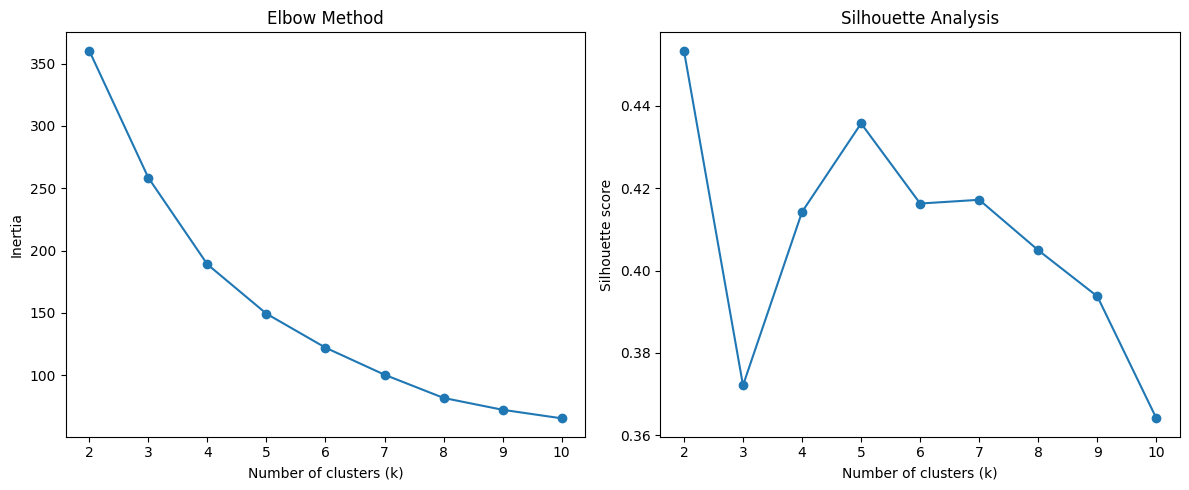

In [4]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import rasterio

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1. Input folder (single FFDI directory)
input_folder = "Outputs/ffdi"

tif_files = glob.glob(os.path.join(input_folder, "*.tif"))

features = []
file_names = []

# 2. Feature extraction from each FFDI raster
for file in tif_files:
    try:
        with rasterio.open(file) as src:
            data = src.read(1)
            nodata = src.nodata

            # Mask invalid values
            data = data[data != nodata]
            data = data[data > 0]

            if data.size == 0:
                continue

            feature_vector = [
                np.mean(data),
                np.std(data),
                np.min(data),
                np.max(data),
                np.percentile(data, 25),
                np.percentile(data, 50),
                np.percentile(data, 75),
            ]

            features.append(feature_vector)
            file_names.append(os.path.basename(file))

    except Exception as e:
        print(f"Error processing {file}: {e}")

data = np.array(features)
print("Feature matrix shape:", data.shape)

# 3. Impute missing values
imputer = SimpleImputer(strategy="mean")
data_imputed = imputer.fit_transform(data)

# 4. Standardize features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)

# 5. KMeans evaluation
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_scaled)

    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled, labels))

    print(f"k={k} | inertia={kmeans.inertia_:.2f} | silhouette={silhouette_scores[-1]:.3f}")

# 6. Plot elbow & silhouette
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Analysis")

plt.tight_layout()
plt.show()


## SECTION 3: Outlier Detection Using IQR Method on Each Raster


This section identifies statistical outliers (extremely high or low FFDI values) in each TIFF file using the
Interquartile Range (IQR) method. Boxplots help visualize the outlier range.


Found 132 TIFF files.

Processing file: ffdi_2023_01.tif
  Outliers detected: 448
  Bounds: < -14.43 or > 42.59


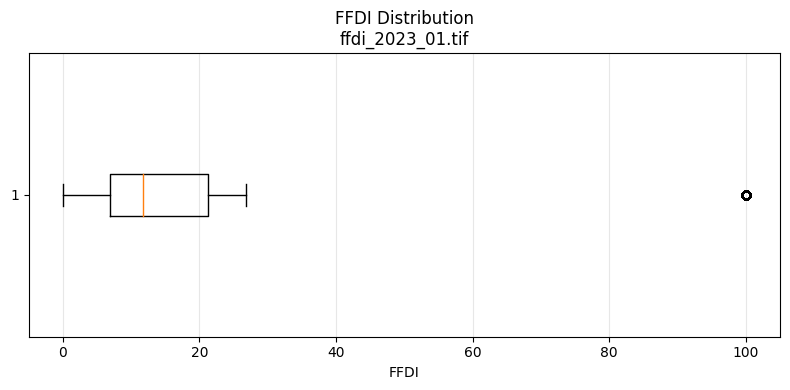

  Top repeated values (rounded):
[(100.0, 448), (5.7, 39), (7.2, 31), (7.1, 30), (7.0, 27), (5.5, 26), (5.1, 25), (5.4, 25), (5.8, 25), (6.4, 25)] 

Processing file: ffdi_2017_05.tif
  Outliers detected: 448
  Bounds: < 0.51 or > 23.15


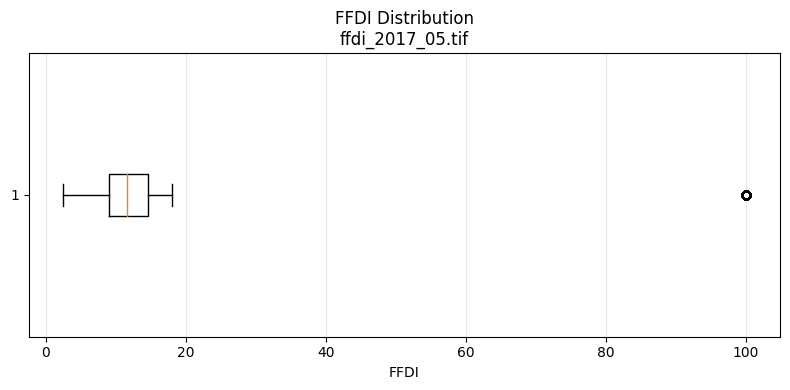

  Top repeated values (rounded):
[(100.0, 448), (8.9, 68), (8.8, 57), (9.0, 52), (8.7, 51), (13.7, 50), (9.2, 42), (13.8, 42), (9.5, 40), (9.4, 39)] 

Processing file: ffdi_2016_10.tif
  Outliers detected: 448
  Bounds: < -1.24 or > 35.31


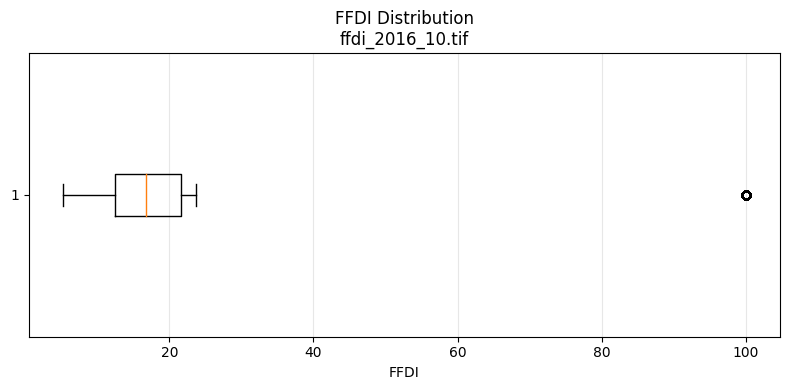

  Top repeated values (rounded):
[(100.0, 448), (12.4, 29), (13.0, 26), (13.6, 25), (12.3, 24), (22.6, 24), (11.8, 23), (11.9, 23), (12.1, 23), (13.1, 23)] 

Processing file: ffdi_2023_06.tif
  Outliers detected: 448
  Bounds: < -0.43 or > 21.46


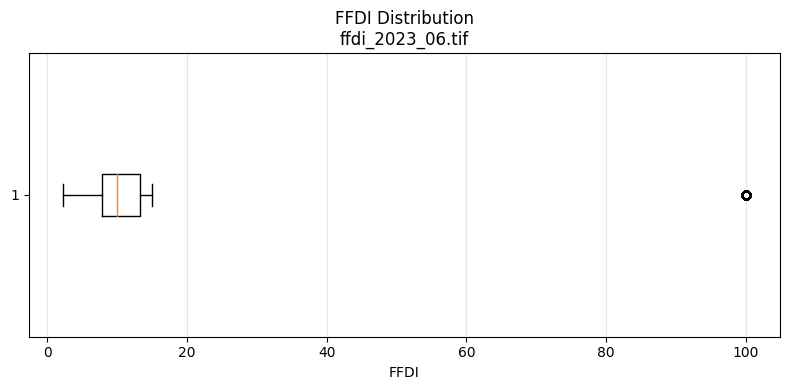

  Top repeated values (rounded):
[(100.0, 448), (8.3, 46), (8.4, 44), (8.9, 41), (7.9, 40), (9.1, 40), (9.2, 40), (8.1, 38), (8.6, 38), (8.7, 37)] 

Processing file: ffdi_2017_02.tif
  Outliers detected: 448
  Bounds: < -7.23 or > 41.66


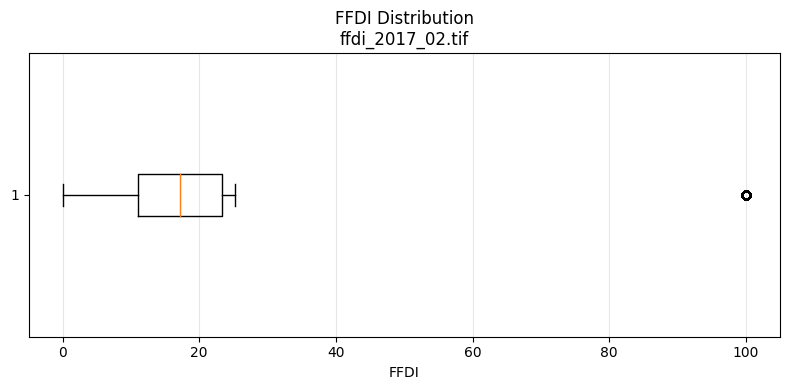

  Top repeated values (rounded):
[(100.0, 448), (24.4, 25), (21.7, 21), (24.2, 21), (7.8, 20), (23.8, 19), (12.4, 18), (20.4, 18), (24.6, 18), (17.4, 17)] 

Processing file: ffdi_2023_08.tif
  Outliers detected: 449
  Bounds: < 3.86 or > 24.03


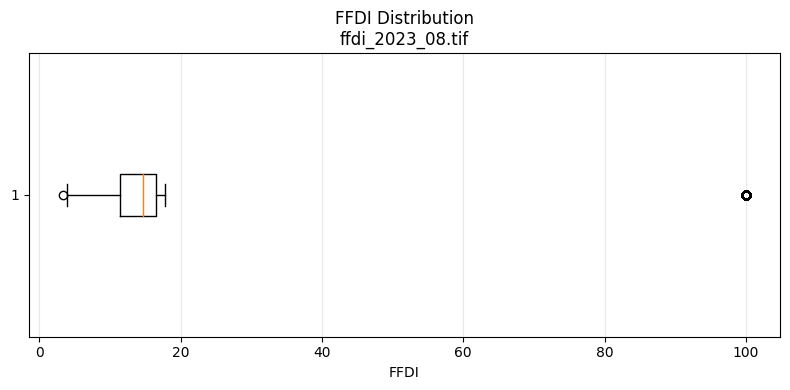

  Top repeated values (rounded):
[(100.0, 448), (15.2, 51), (15.1, 48), (15.8, 46), (15.6, 45), (15.4, 42), (15.9, 42), (16.4, 42), (16.1, 41), (16.5, 41)] 

Processing file: ffdi_2013_04.tif
  Outliers detected: 448
  Bounds: < -3.65 or > 30.12


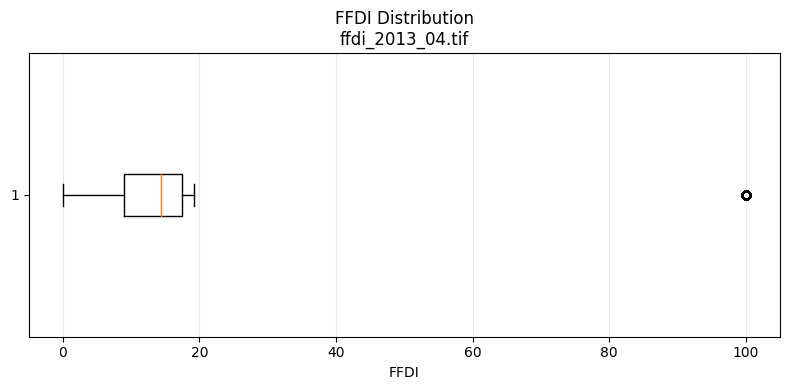

  Top repeated values (rounded):
[(100.0, 448), (16.9, 39), (16.8, 36), (17.5, 36), (17.0, 34), (16.7, 33), (17.1, 32), (16.5, 31), (13.8, 30), (17.3, 30)] 

Processing file: ffdi_2019_06.tif
  Outliers detected: 448
  Bounds: < 0.04 or > 18.07


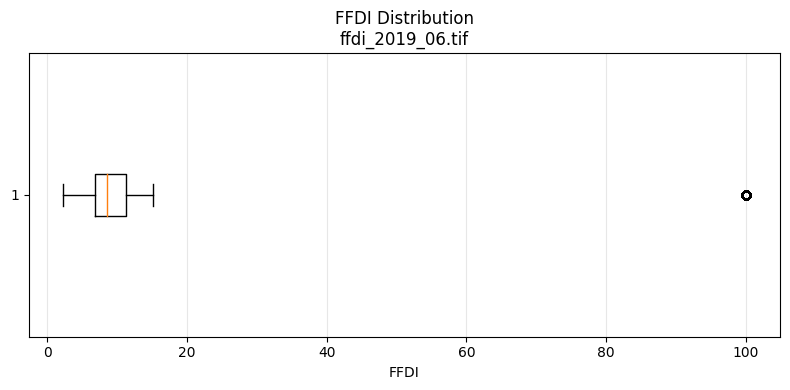

  Top repeated values (rounded):
[(100.0, 448), (8.5, 77), (8.7, 64), (8.8, 64), (8.6, 57), (8.4, 53), (9.0, 49), (6.7, 48), (8.3, 48), (8.9, 48)] 

Processing file: ffdi_2014_08.tif
  Outliers detected: 448
  Bounds: < 0.77 or > 23.43


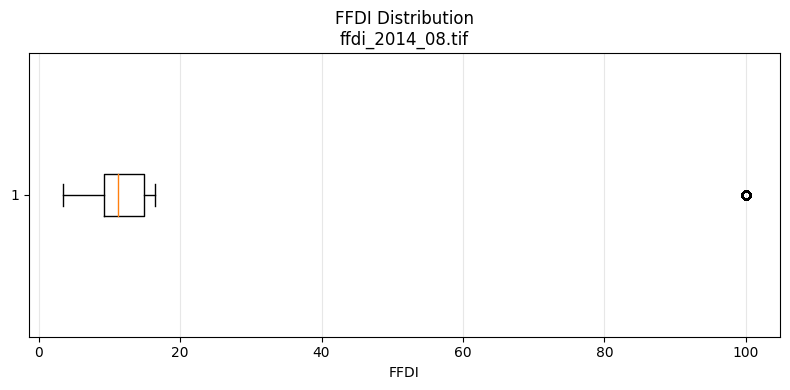

  Top repeated values (rounded):
[(100.0, 448), (11.2, 59), (11.0, 47), (11.3, 46), (10.8, 45), (11.1, 44), (10.3, 39), (10.6, 38), (9.8, 37), (10.0, 35)] 

Processing file: ffdi_2013_03.tif
  Outliers detected: 448
  Bounds: < -10.54 or > 37.63


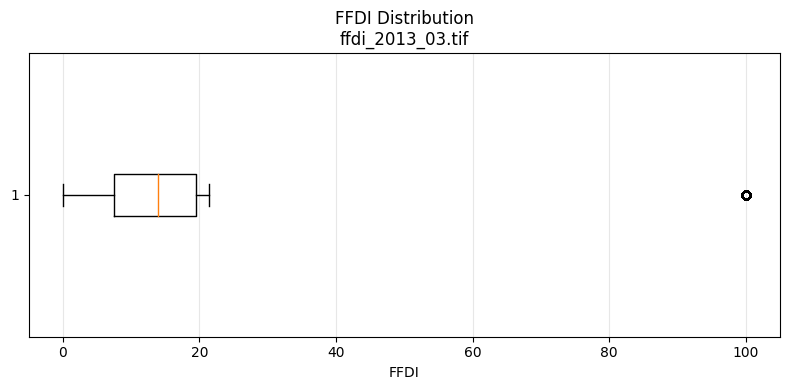

  Top repeated values (rounded):
[(100.0, 448), (19.7, 41), (0.1, 35), (19.8, 33), (0.0, 24), (19.9, 24), (5.9, 21), (17.2, 21), (19.3, 21), (19.6, 21)] 

Processing file: ffdi_2019_01.tif
  Outliers detected: 448
  Bounds: < -18.60 or > 65.18


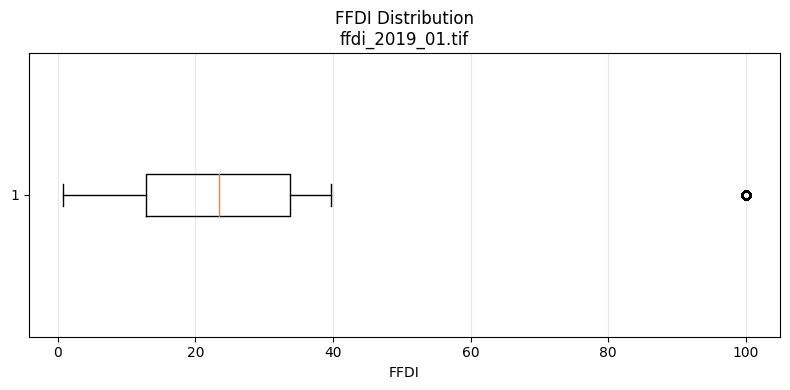

  Top repeated values (rounded):
[(100.0, 448), (8.2, 16), (12.1, 16), (7.6, 15), (27.9, 14), (29.7, 14), (8.4, 13), (10.5, 13), (24.2, 13), (6.9, 12)] 

Processing file: ffdi_2014_06.tif
  Outliers detected: 448
  Bounds: < -0.59 or > 18.70


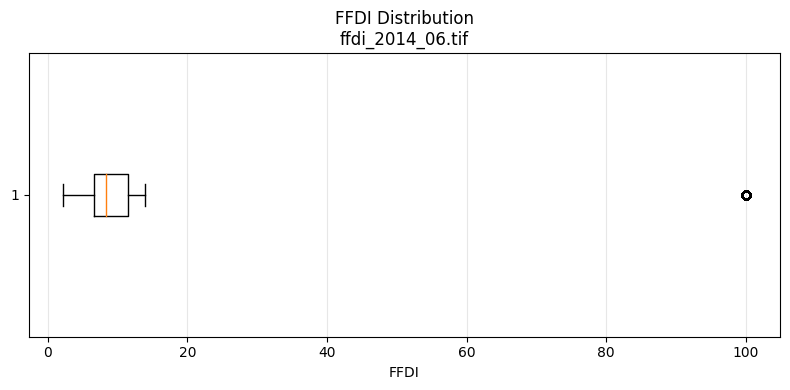

  Top repeated values (rounded):
[(100.0, 448), (6.2, 58), (6.5, 58), (6.6, 58), (6.4, 57), (6.3, 56), (7.3, 56), (7.2, 51), (6.1, 50), (6.9, 49)] 

Processing file: ffdi_2020_02.tif
  Outliers detected: 448
  Bounds: < -9.27 or > 37.69


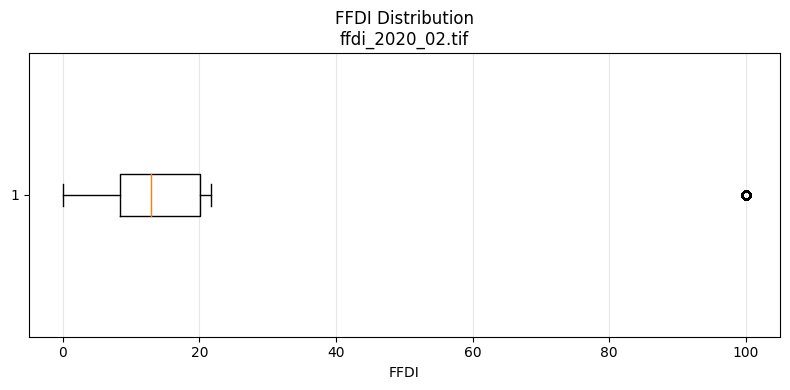

  Top repeated values (rounded):
[(100.0, 448), (7.8, 34), (8.4, 30), (9.1, 29), (7.7, 27), (8.2, 27), (8.5, 27), (8.7, 27), (9.4, 27), (7.9, 26)] 

Processing file: ffdi_2021_10.tif
  Outliers detected: 453
  Bounds: < 2.64 or > 36.79


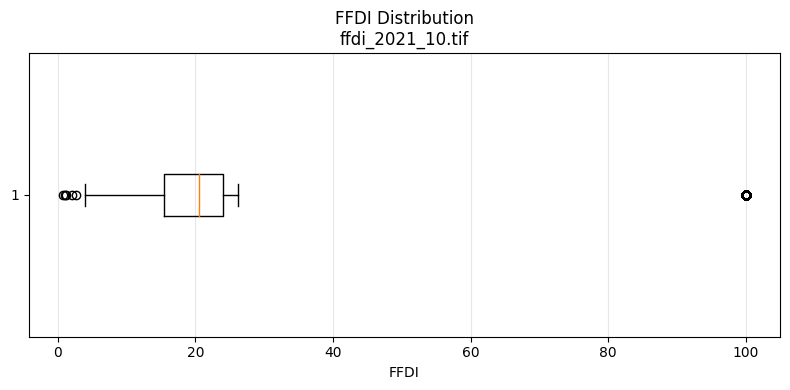

  Top repeated values (rounded):
[(100.0, 448), (23.9, 30), (22.5, 28), (21.9, 26), (22.4, 26), (23.6, 26), (21.6, 25), (22.1, 25), (22.3, 24), (15.7, 23)] 

Processing file: ffdi_2014_01.tif
  Outliers detected: 448
  Bounds: < -12.77 or > 48.58


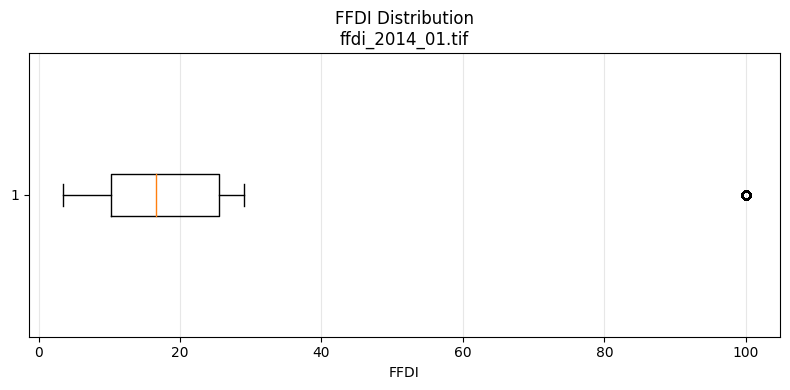

  Top repeated values (rounded):
[(100.0, 448), (8.2, 23), (10.8, 22), (7.3, 21), (8.8, 21), (10.0, 20), (6.1, 19), (9.1, 19), (11.2, 18), (10.6, 17)] 

Processing file: ffdi_2020_05.tif
  Outliers detected: 448
  Bounds: < -0.51 or > 18.60


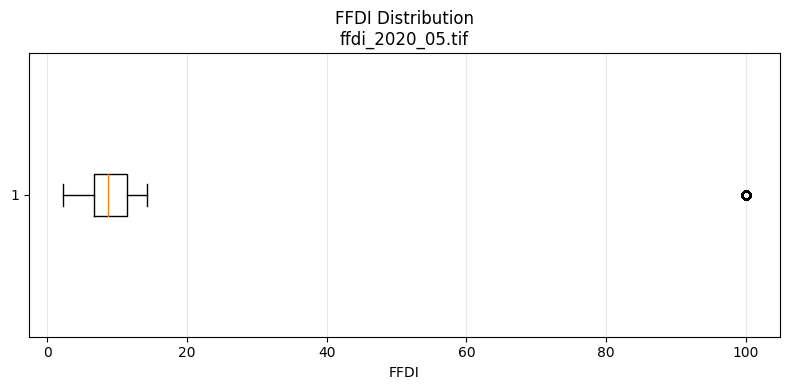

  Top repeated values (rounded):
[(100.0, 448), (6.4, 66), (6.3, 57), (6.5, 56), (6.8, 54), (6.1, 51), (6.2, 47), (6.9, 47), (6.6, 46), (6.0, 44)] 

Processing file: ffdi_2019_08.tif
  Outliers detected: 448
  Bounds: < 1.67 or > 26.61


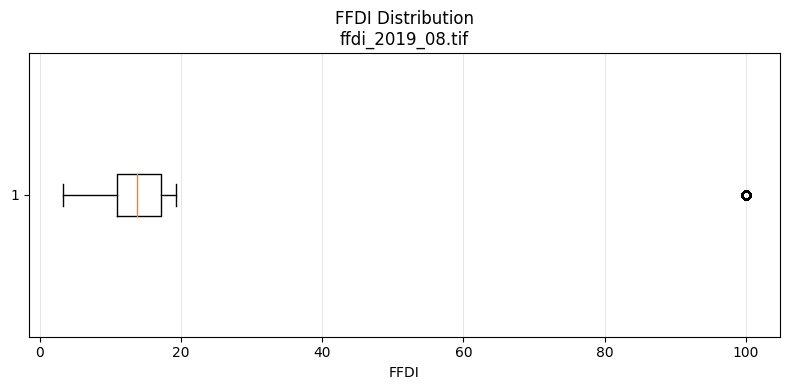

  Top repeated values (rounded):
[(100.0, 448), (13.7, 60), (13.8, 55), (13.6, 49), (13.9, 48), (13.5, 47), (13.4, 42), (14.0, 40), (10.3, 39), (14.1, 38)] 

Processing file: ffdi_2015_02.tif
  Outliers detected: 448
  Bounds: < -10.55 or > 41.57


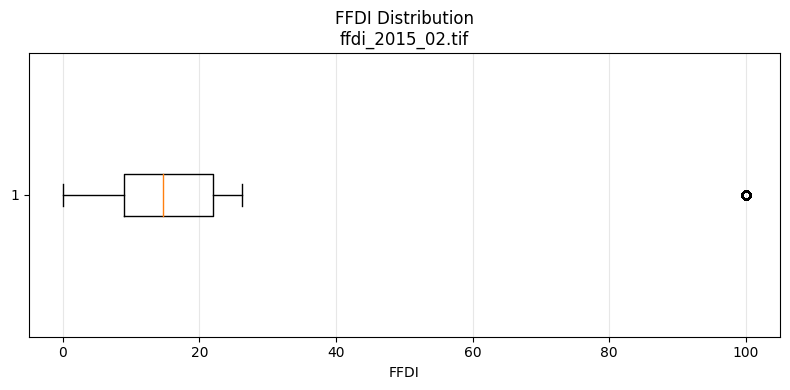

  Top repeated values (rounded):
[(100.0, 448), (7.6, 27), (9.2, 26), (8.6, 23), (9.0, 22), (7.8, 21), (8.2, 20), (9.1, 20), (12.5, 20), (6.7, 19)] 

Processing file: ffdi_2021_06.tif
  Outliers detected: 448
  Bounds: < -2.65 or > 21.68


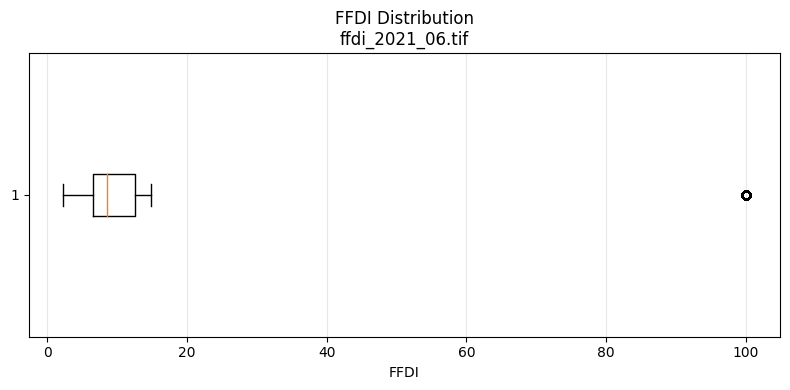

  Top repeated values (rounded):
[(100.0, 448), (6.4, 54), (6.5, 48), (6.7, 48), (6.8, 46), (6.2, 45), (6.6, 45), (7.1, 45), (7.4, 43), (5.7, 42)] 

Processing file: ffdi_2014_10.tif
  Outliers detected: 448
  Bounds: < -0.23 or > 39.52


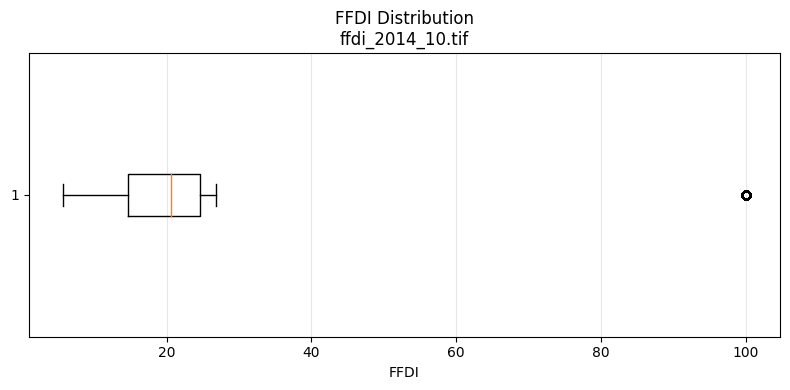

  Top repeated values (rounded):
[(100.0, 448), (23.4, 39), (23.6, 37), (23.3, 35), (23.5, 30), (23.7, 29), (23.8, 27), (14.4, 25), (23.2, 25), (23.0, 24)] 

Processing file: ffdi_2015_05.tif
  Outliers detected: 448
  Bounds: < 0.55 or > 21.63


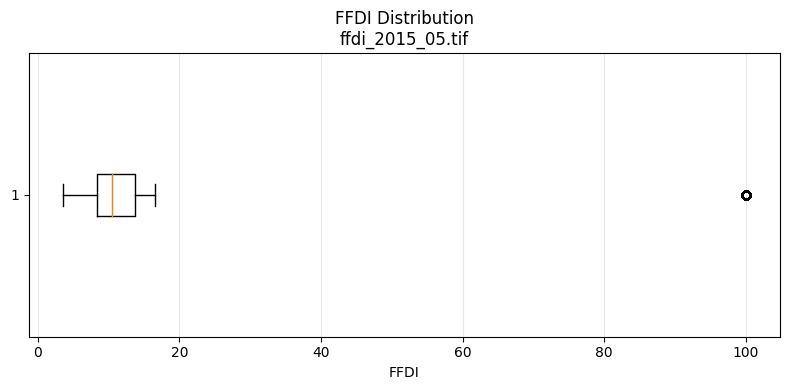

  Top repeated values (rounded):
[(100.0, 448), (8.2, 62), (8.3, 54), (8.1, 49), (11.8, 46), (8.4, 44), (9.3, 41), (8.6, 40), (9.0, 40), (9.4, 40)] 

Processing file: ffdi_2021_01.tif
  Outliers detected: 448
  Bounds: < -14.64 or > 48.24


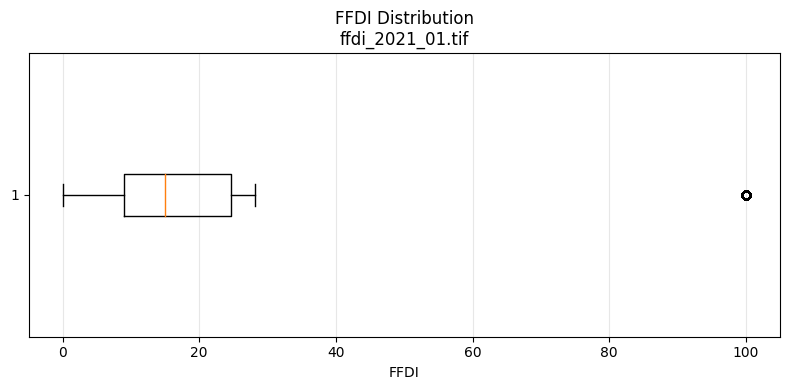

  Top repeated values (rounded):
[(100.0, 448), (10.0, 28), (10.3, 28), (10.1, 26), (6.1, 24), (9.8, 23), (9.7, 22), (10.4, 20), (9.5, 19), (9.6, 19)] 

Processing file: ffdi_2019_10.tif
  Outliers detected: 459
  Bounds: < 2.88 or > 42.04


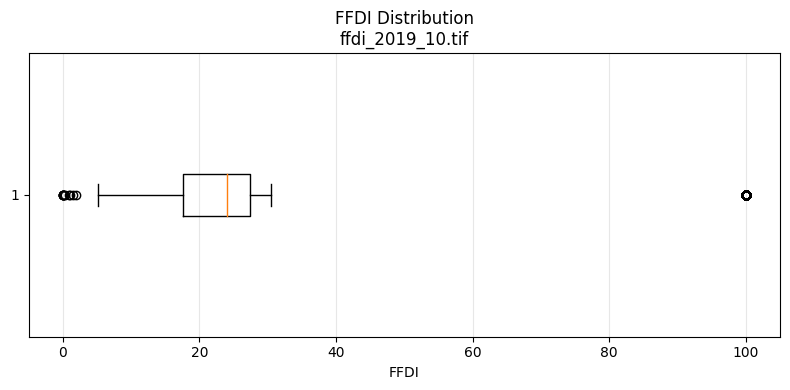

  Top repeated values (rounded):
[(100.0, 448), (26.4, 38), (24.8, 31), (24.3, 30), (24.5, 29), (25.9, 29), (24.2, 28), (24.4, 27), (26.0, 27), (25.1, 26)] 

Processing file: ffdi_2013_12.tif
  Outliers detected: 448
  Bounds: < -6.96 or > 45.84


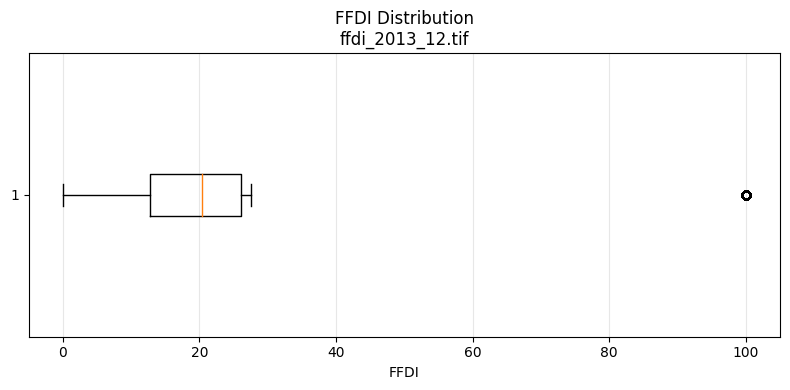

  Top repeated values (rounded):
[(100.0, 448), (26.9, 27), (11.7, 24), (11.1, 23), (24.7, 23), (25.0, 23), (23.7, 22), (26.2, 22), (26.3, 21), (13.6, 20)] 

Processing file: ffdi_2018_02.tif
  Outliers detected: 448
  Bounds: < -10.36 or > 43.95


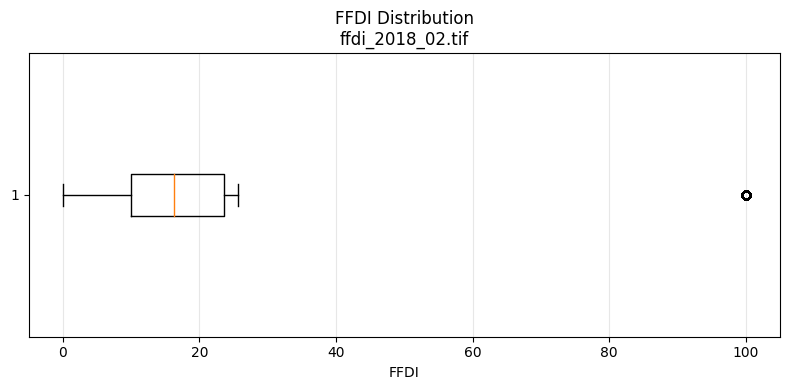

  Top repeated values (rounded):
[(100.0, 448), (0.0, 32), (8.5, 22), (10.0, 22), (10.8, 22), (25.0, 21), (24.9, 20), (8.3, 19), (10.5, 19), (10.9, 19)] 

Processing file: ffdi_2018_05.tif
  Outliers detected: 448
  Bounds: < 1.98 or > 20.27


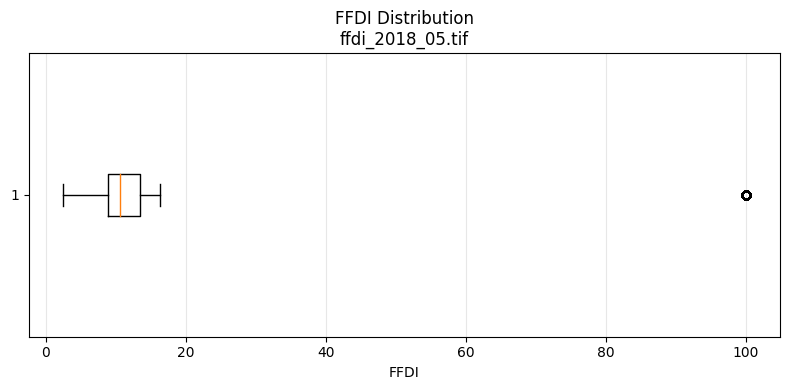

  Top repeated values (rounded):
[(100.0, 448), (8.8, 66), (9.0, 64), (9.1, 63), (8.9, 61), (8.7, 57), (9.2, 57), (8.6, 50), (9.5, 45), (8.3, 42)] 

Processing file: ffdi_2021_08.tif
  Outliers detected: 448
  Bounds: < -2.11 or > 31.62


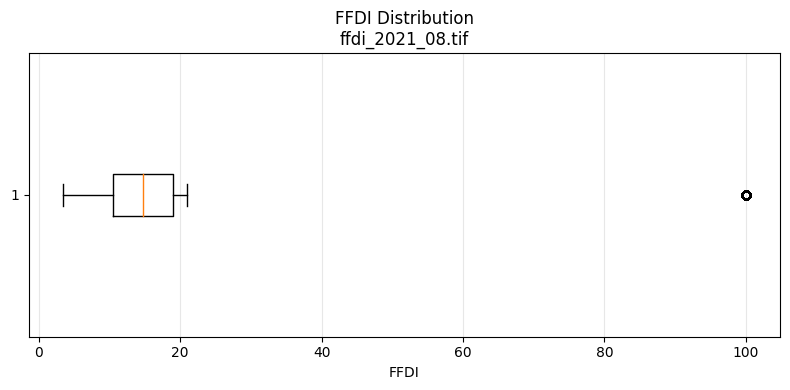

  Top repeated values (rounded):
[(100.0, 448), (14.9, 28), (9.5, 27), (14.7, 27), (15.2, 27), (14.3, 26), (14.6, 26), (12.7, 25), (9.1, 24), (14.8, 23)] 

Processing file: ffdi_2016_08.tif
  Outliers detected: 448
  Bounds: < -1.68 or > 24.56


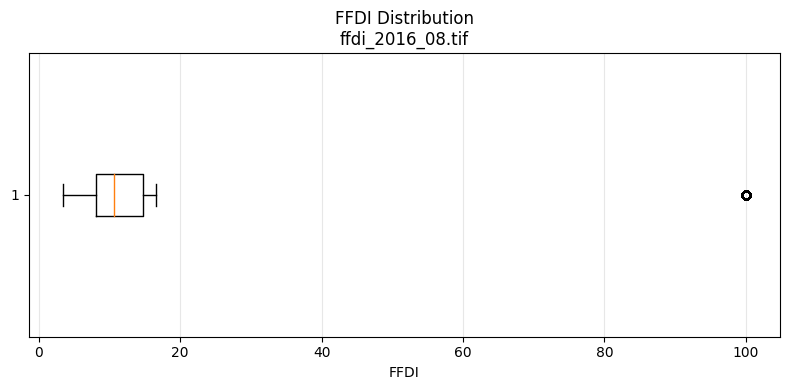

  Top repeated values (rounded):
[(100.0, 448), (7.4, 53), (7.5, 52), (7.6, 42), (7.8, 42), (8.1, 40), (7.2, 39), (7.1, 38), (7.3, 38), (9.5, 36)] 

Processing file: ffdi_2022_05.tif
  Outliers detected: 448
  Bounds: < -1.37 or > 17.87


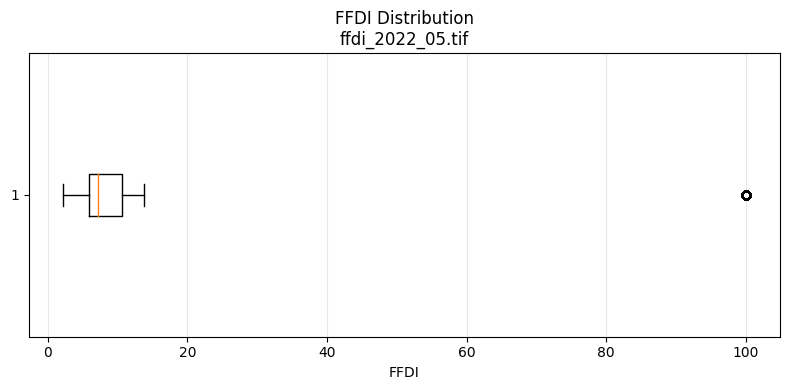

  Top repeated values (rounded):
[(100.0, 448), (5.9, 119), (5.8, 113), (5.7, 101), (5.6, 87), (6.0, 87), (6.2, 71), (6.1, 69), (6.3, 65), (5.5, 64)] 

Processing file: ffdi_2016_01.tif
  Outliers detected: 448
  Bounds: < -10.76 or > 43.88


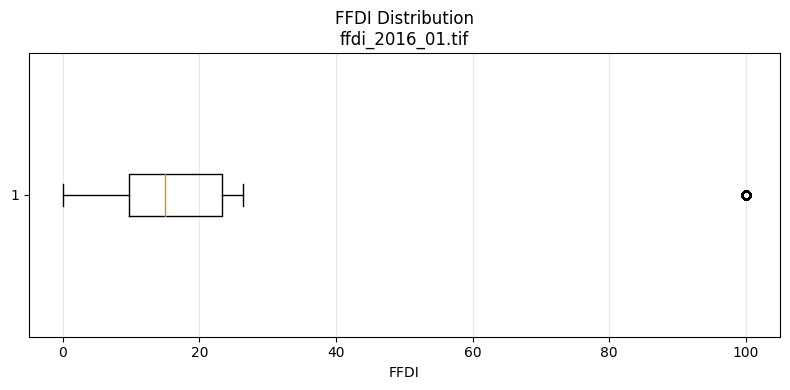

  Top repeated values (rounded):
[(100.0, 448), (10.3, 22), (11.5, 22), (11.6, 22), (8.9, 21), (9.0, 21), (9.9, 21), (16.5, 21), (9.5, 20), (10.7, 20)] 

Processing file: ffdi_2023_10.tif
  Outliers detected: 448
  Bounds: < 2.98 or > 39.41


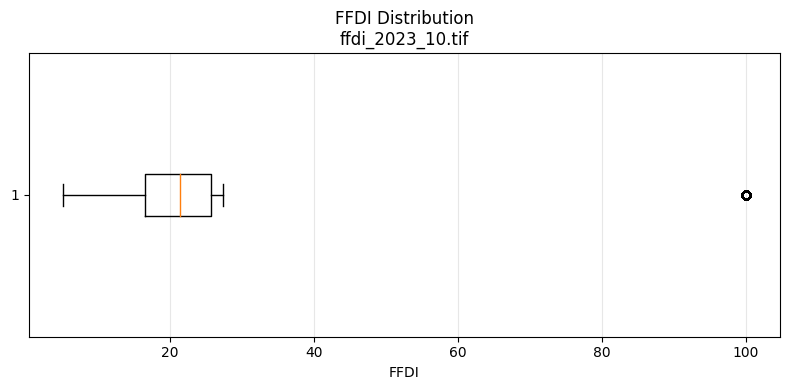

  Top repeated values (rounded):
[(100.0, 448), (22.9, 31), (23.1, 31), (23.0, 30), (26.0, 28), (25.7, 26), (25.8, 26), (21.4, 24), (25.4, 24), (25.9, 23)] 

Processing file: ffdi_2022_02.tif
  Outliers detected: 448
  Bounds: < -7.97 or > 35.18


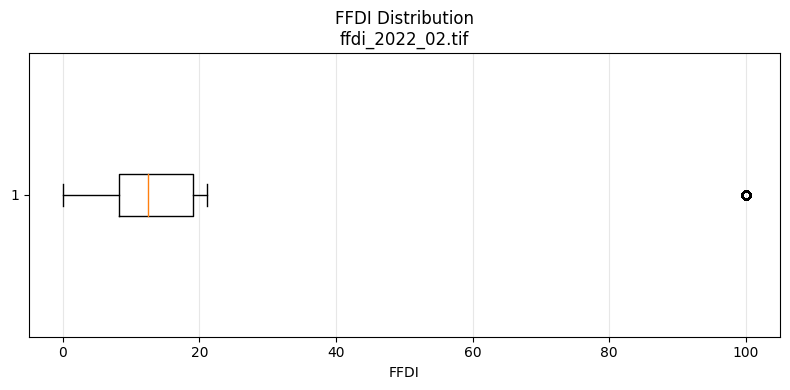

  Top repeated values (rounded):
[(100.0, 448), (0.0, 47), (11.5, 26), (19.0, 26), (19.3, 25), (9.8, 23), (5.1, 22), (11.4, 22), (9.4, 21), (19.5, 21)] 

Processing file: ffdi_2016_06.tif
  Outliers detected: 448
  Bounds: < -3.70 or > 21.11


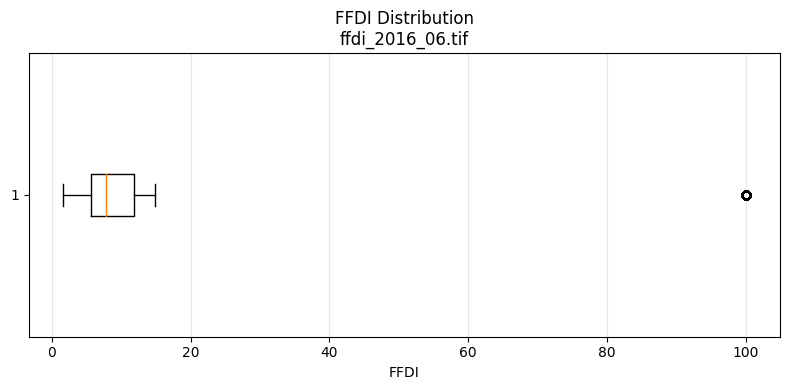

  Top repeated values (rounded):
[(100.0, 448), (4.5, 77), (4.4, 69), (4.6, 55), (4.9, 53), (4.8, 50), (4.3, 47), (6.7, 45), (4.7, 42), (7.1, 40)] 

Processing file: ffdi_2015_12.tif
  Outliers detected: 448
  Bounds: < -8.23 or > 41.69


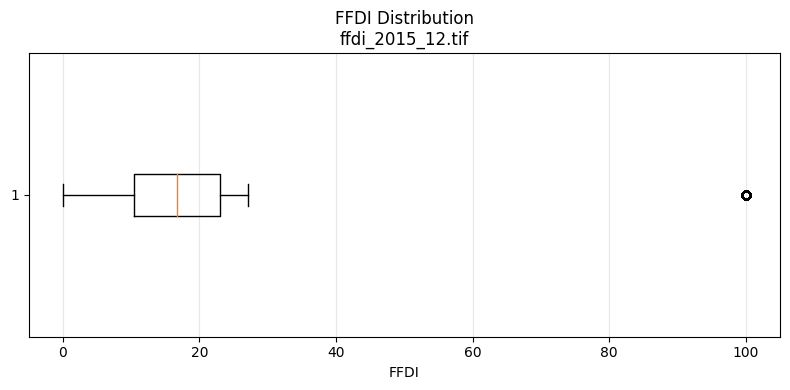

  Top repeated values (rounded):
[(100.0, 448), (9.6, 29), (9.2, 24), (0.0, 21), (8.5, 21), (9.8, 21), (9.3, 20), (10.7, 20), (10.9, 20), (11.3, 20)] 

Processing file: ffdi_2020_04.tif
  Outliers detected: 448
  Bounds: < -0.60 or > 27.50


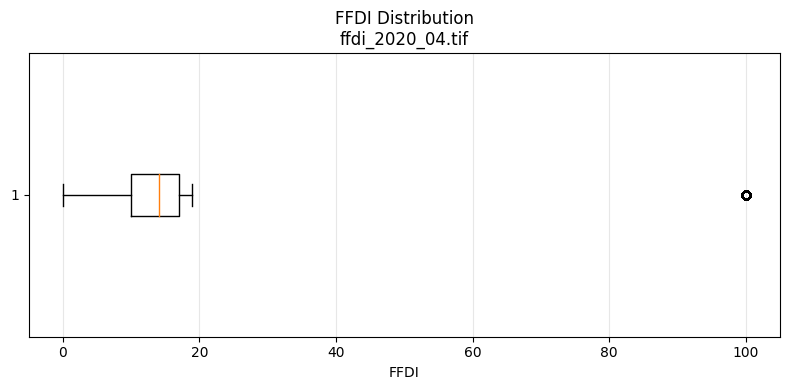

  Top repeated values (rounded):
[(100.0, 448), (10.8, 35), (15.9, 32), (16.1, 32), (11.0, 31), (15.2, 31), (16.8, 31), (9.5, 30), (17.0, 30), (17.5, 30)] 

Processing file: ffdi_2019_09.tif
  Outliers detected: 448
  Bounds: < 3.76 or > 34.95


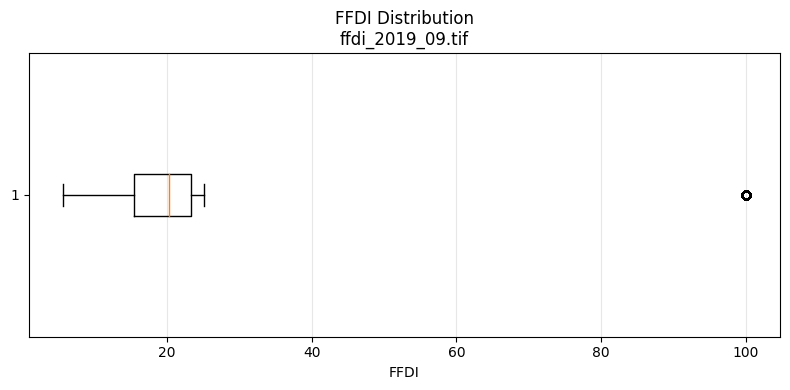

  Top repeated values (rounded):
[(100.0, 448), (21.0, 44), (20.7, 39), (20.8, 39), (20.9, 35), (20.4, 34), (20.6, 34), (21.1, 34), (21.2, 34), (20.2, 33)] 

Processing file: ffdi_2014_07.tif
  Outliers detected: 448
  Bounds: < -0.21 or > 23.17


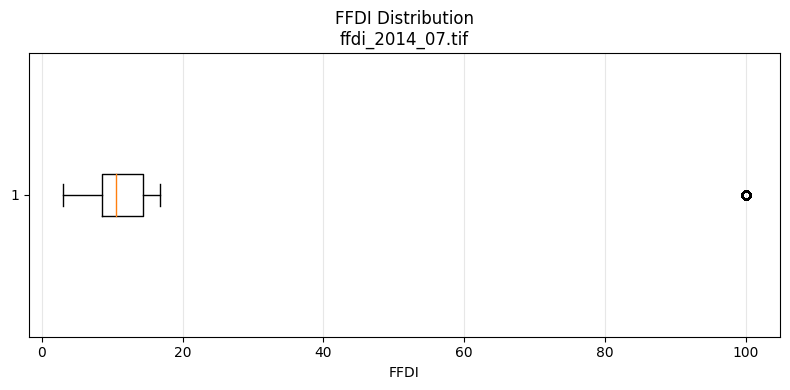

  Top repeated values (rounded):
[(100.0, 448), (8.5, 65), (8.8, 57), (8.4, 55), (8.0, 50), (8.2, 48), (8.1, 47), (8.3, 47), (8.6, 47), (8.7, 41)] 

Processing file: ffdi_2020_03.tif
  Outliers detected: 448
  Bounds: < -4.96 or > 32.25


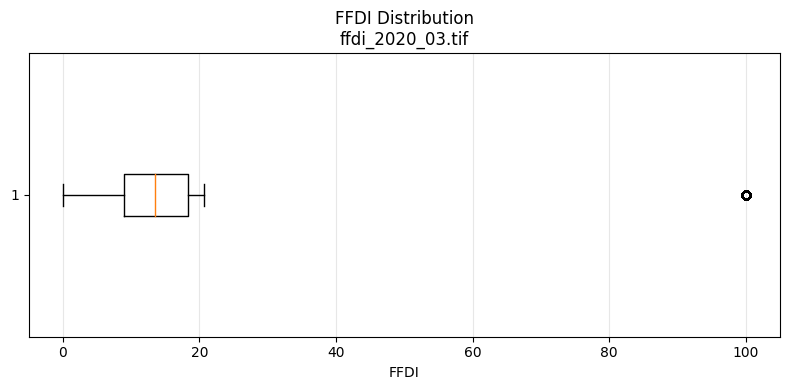

  Top repeated values (rounded):
[(100.0, 448), (9.8, 31), (18.2, 28), (9.2, 27), (7.9, 24), (8.8, 24), (9.5, 24), (9.4, 23), (18.7, 23), (8.1, 22)] 

Processing file: ffdi_2021_11.tif
  Outliers detected: 448
  Bounds: < -4.36 or > 32.19


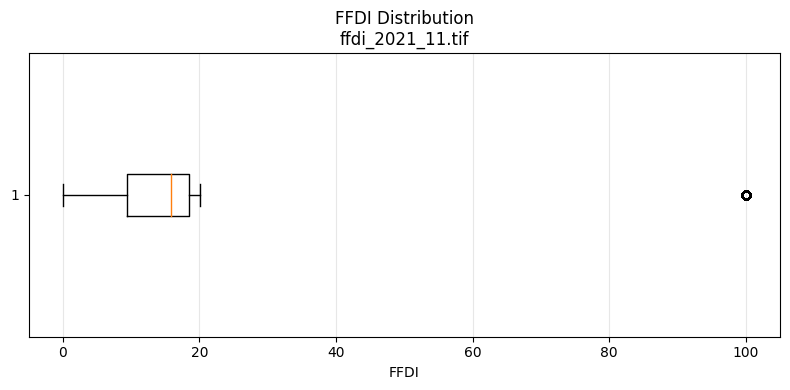

  Top repeated values (rounded):
[(100.0, 448), (8.5, 48), (18.4, 44), (18.3, 43), (18.8, 41), (18.0, 39), (18.5, 37), (18.7, 37), (17.1, 35), (18.2, 35)] 

Processing file: ffdi_2013_02.tif
  Outliers detected: 448
  Bounds: < -12.39 or > 39.88


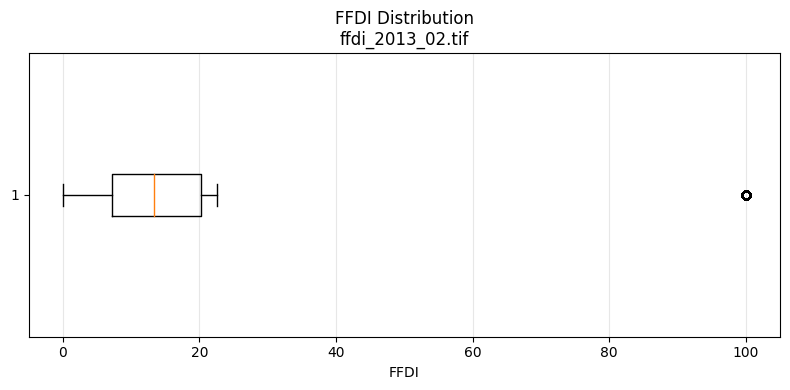

  Top repeated values (rounded):
[(100.0, 448), (6.2, 27), (7.0, 26), (5.8, 24), (3.3, 23), (7.4, 20), (8.3, 20), (3.5, 19), (6.8, 19), (8.1, 19)] 

Processing file: ffdi_2014_09.tif
  Outliers detected: 448
  Bounds: < 0.16 or > 32.91


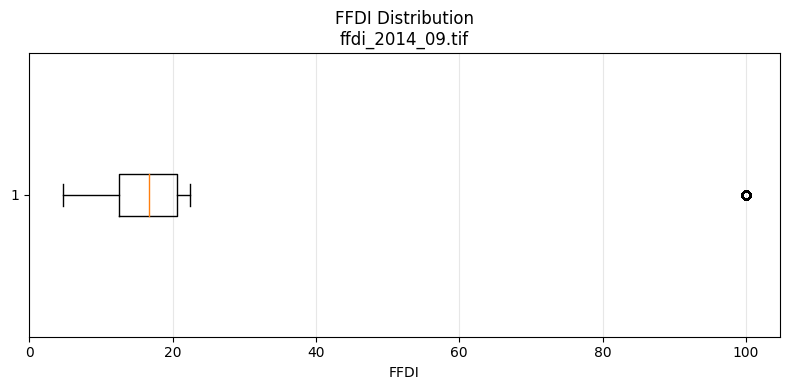

  Top repeated values (rounded):
[(100.0, 448), (17.0, 28), (12.7, 27), (16.8, 27), (10.2, 26), (13.1, 26), (17.2, 26), (10.5, 25), (18.8, 25), (19.1, 24)] 

Processing file: ffdi_2018_12.tif
  Outliers detected: 448
  Bounds: < -10.12 or > 50.50


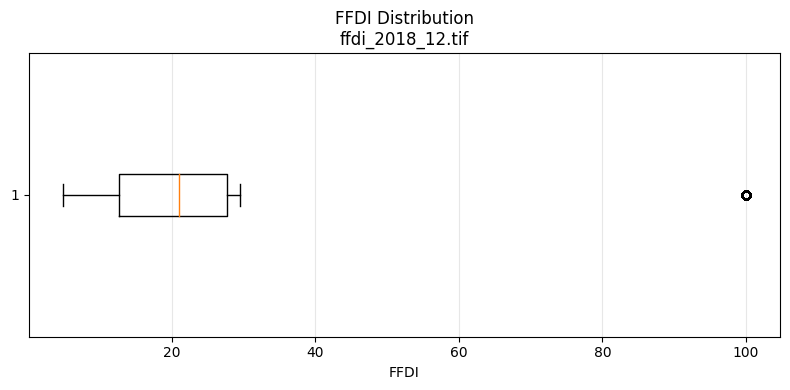

  Top repeated values (rounded):
[(100.0, 448), (28.4, 33), (28.5, 32), (27.0, 26), (28.3, 25), (11.0, 22), (27.6, 21), (28.6, 20), (10.6, 19), (14.0, 19)] 

Processing file: ffdi_2013_05.tif
  Outliers detected: 448
  Bounds: < 0.69 or > 18.86


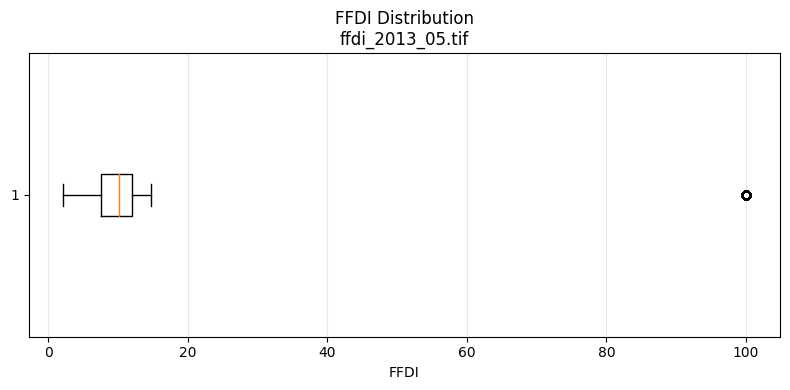

  Top repeated values (rounded):
[(100.0, 448), (10.8, 67), (10.4, 57), (10.9, 55), (8.5, 47), (10.7, 47), (7.5, 44), (10.5, 44), (10.6, 43), (11.0, 43)] 

Processing file: ffdi_2019_07.tif
  Outliers detected: 448
  Bounds: < -1.39 or > 22.71


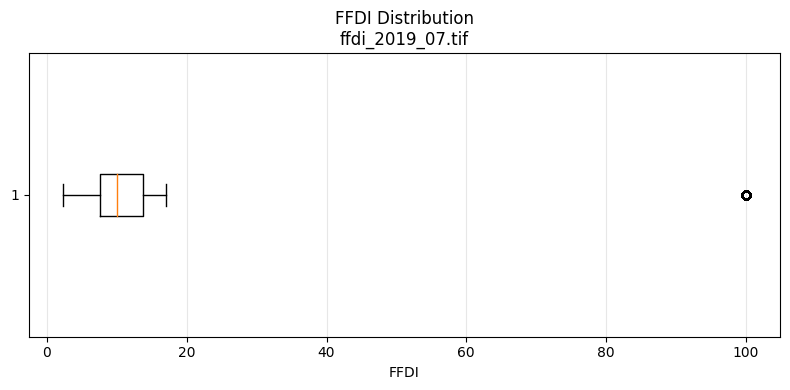

  Top repeated values (rounded):
[(100.0, 448), (7.9, 52), (6.8, 49), (10.1, 47), (6.9, 40), (10.0, 40), (7.0, 39), (7.8, 38), (6.6, 37), (8.0, 36)] 

Processing file: ffdi_2023_09.tif
  Outliers detected: 448
  Bounds: < 0.75 or > 36.02


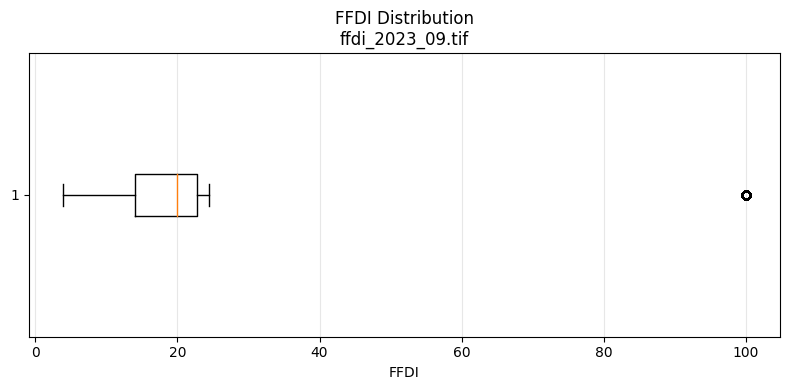

  Top repeated values (rounded):
[(100.0, 448), (22.5, 45), (22.8, 38), (23.1, 38), (22.3, 37), (22.9, 37), (22.2, 36), (22.1, 35), (22.4, 34), (22.7, 32)] 

Processing file: ffdi_2016_11.tif
  Outliers detected: 450
  Bounds: < 0.29 or > 39.49


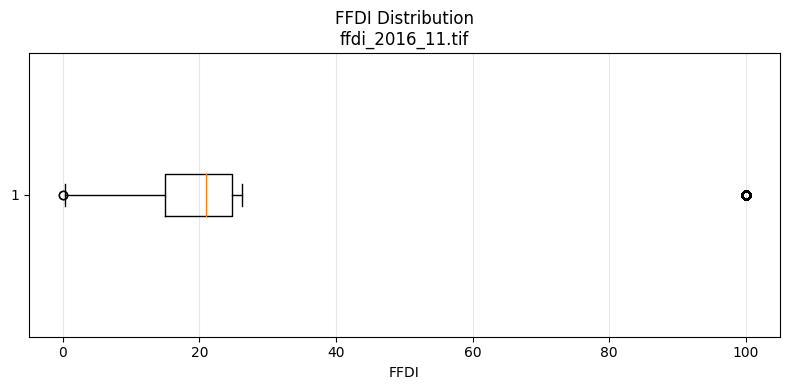

  Top repeated values (rounded):
[(100.0, 448), (24.7, 56), (24.8, 53), (24.5, 50), (24.6, 47), (24.9, 42), (25.1, 39), (25.2, 36), (25.0, 35), (24.4, 30)] 

Processing file: ffdi_2023_07.tif
  Outliers detected: 450
  Bounds: < 1.44 or > 16.50


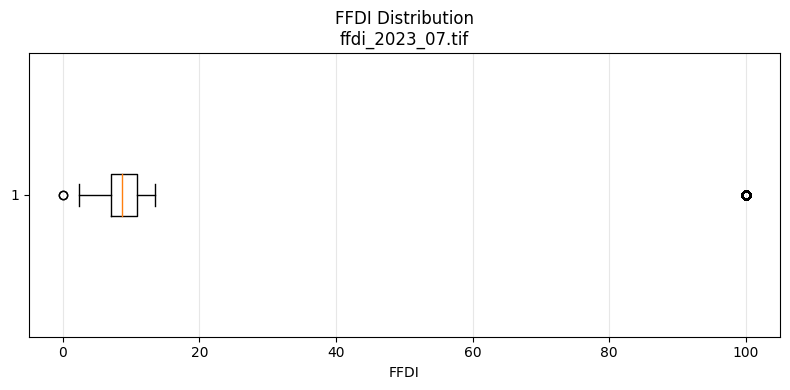

  Top repeated values (rounded):
[(100.0, 448), (7.4, 62), (6.7, 57), (8.9, 57), (6.8, 55), (7.6, 53), (9.1, 52), (8.8, 51), (9.3, 51), (8.7, 50)] 

Processing file: ffdi_2017_03.tif
  Outliers detected: 448
  Bounds: < -7.88 or > 41.97


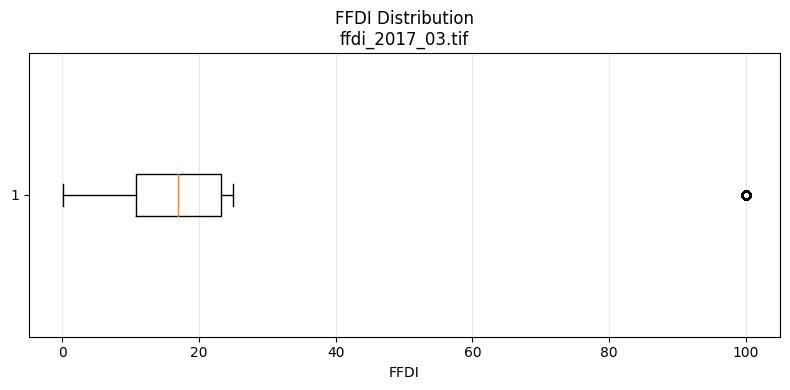

  Top repeated values (rounded):
[(100.0, 448), (23.5, 29), (23.8, 27), (11.2, 26), (23.7, 26), (11.3, 25), (22.9, 23), (8.8, 21), (9.5, 21), (11.0, 21)] 

Processing file: ffdi_2017_04.tif
  Outliers detected: 448
  Bounds: < -2.48 or > 30.49


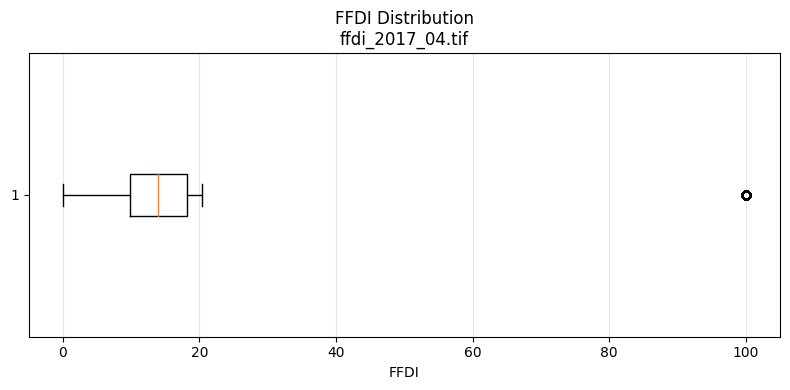

  Top repeated values (rounded):
[(100.0, 448), (18.0, 39), (18.1, 35), (8.7, 33), (18.2, 28), (10.4, 27), (11.1, 27), (10.9, 25), (9.1, 24), (10.2, 24)] 

Processing file: ffdi_2022_12.tif
  Outliers detected: 448
  Bounds: < -6.28 or > 39.31


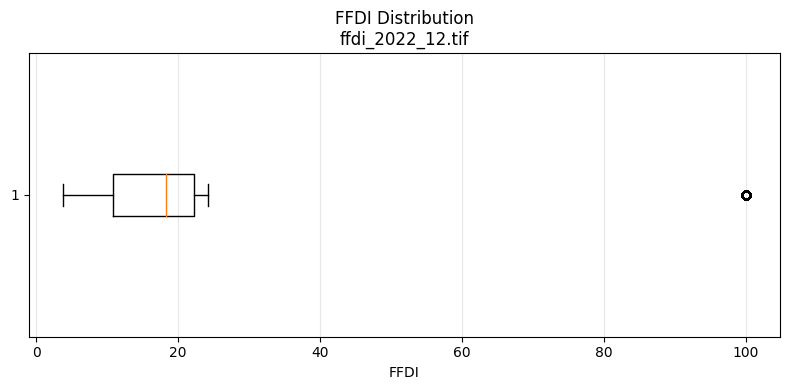

  Top repeated values (rounded):
[(100.0, 448), (21.8, 42), (22.1, 42), (21.6, 41), (21.9, 38), (21.5, 36), (22.0, 35), (21.7, 34), (21.4, 32), (22.6, 27)] 

Processing file: ffdi_2023_11.tif
  Outliers detected: 448
  Bounds: < -7.38 or > 43.11


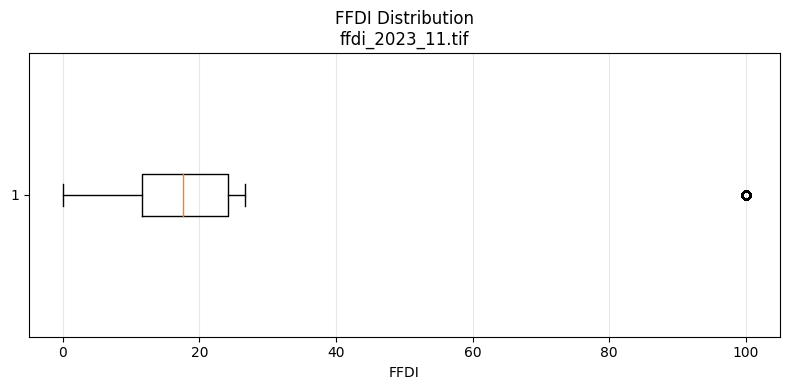

  Top repeated values (rounded):
[(100.0, 448), (10.1, 30), (9.4, 28), (9.6, 27), (10.3, 27), (23.8, 27), (24.1, 27), (9.8, 26), (10.2, 26), (24.0, 26)] 

Processing file: ffdi_2022_03.tif
  Outliers detected: 448
  Bounds: < -7.04 or > 42.14


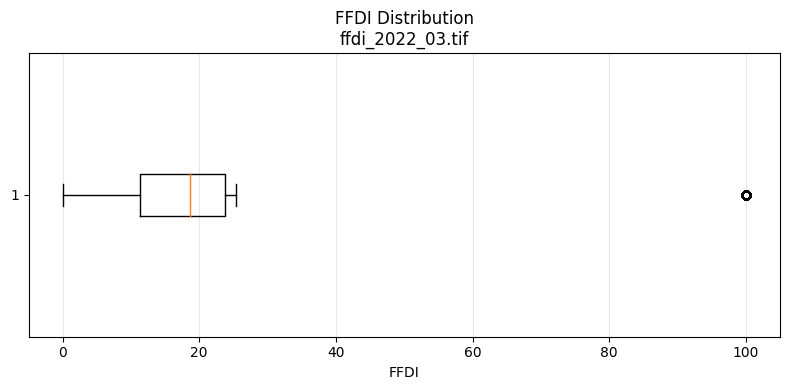

  Top repeated values (rounded):
[(100.0, 448), (21.6, 26), (21.9, 26), (21.8, 25), (20.8, 22), (24.4, 22), (21.0, 21), (21.1, 21), (21.4, 21), (24.6, 21)] 

Processing file: ffdi_2016_07.tif
  Outliers detected: 448
  Bounds: < -2.52 or > 21.53


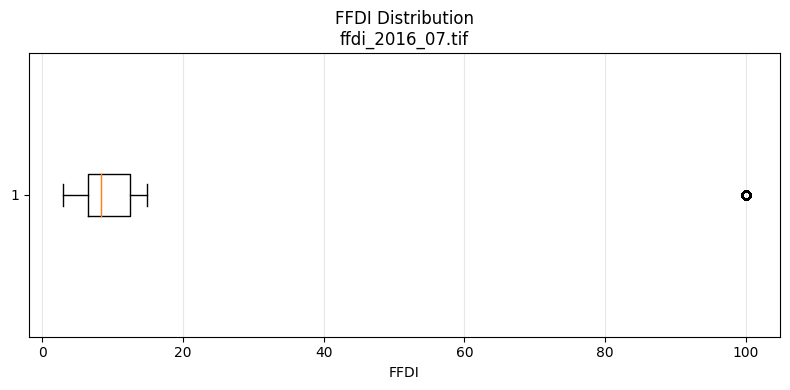

  Top repeated values (rounded):
[(100.0, 448), (7.0, 71), (5.8, 65), (5.5, 59), (5.9, 57), (7.1, 56), (6.6, 55), (6.0, 53), (5.6, 51), (6.8, 50)] 

Processing file: ffdi_2022_04.tif
  Outliers detected: 448
  Bounds: < -4.61 or > 31.42


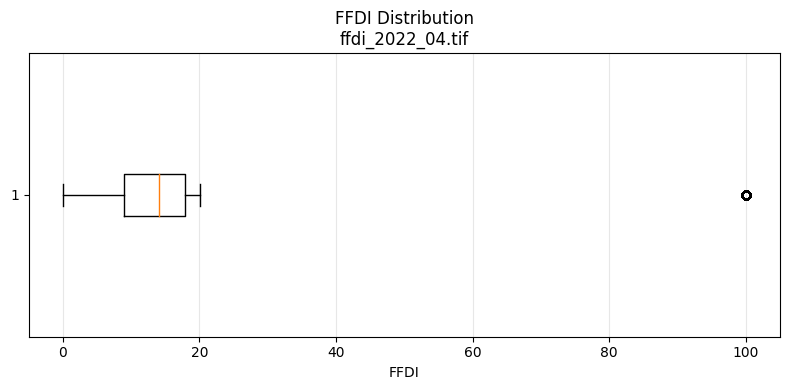

  Top repeated values (rounded):
[(100.0, 448), (9.0, 42), (9.1, 42), (9.2, 34), (17.8, 34), (8.8, 32), (8.9, 32), (16.9, 32), (17.9, 30), (8.2, 29)] 

Processing file: ffdi_2017_12.tif
  Outliers detected: 448
  Bounds: < -7.88 or > 48.67


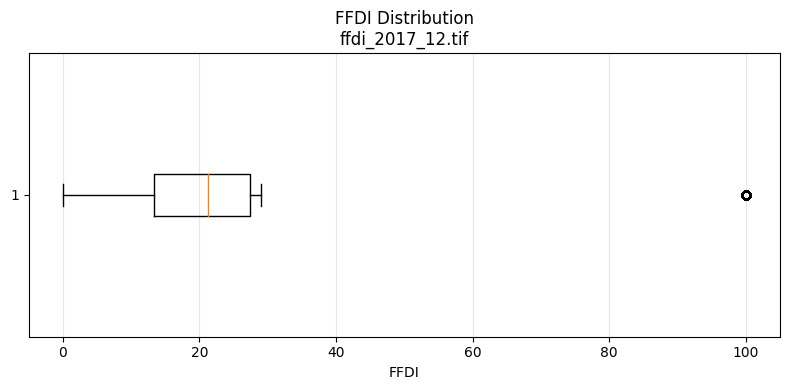

  Top repeated values (rounded):
[(100.0, 448), (0.0, 53), (27.9, 32), (27.6, 31), (27.4, 30), (28.1, 30), (27.2, 28), (26.7, 27), (27.8, 26), (13.9, 24)] 

Processing file: ffdi_2016_09.tif
  Outliers detected: 448
  Bounds: < -5.19 or > 29.89


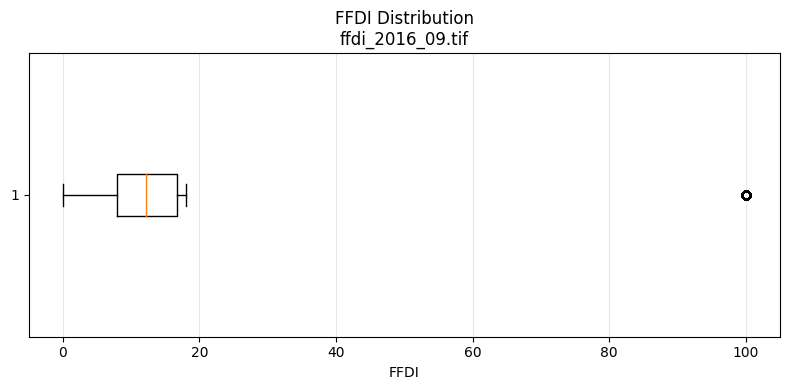

  Top repeated values (rounded):
[(100.0, 448), (0.0, 42), (7.9, 39), (8.4, 33), (0.1, 32), (7.6, 30), (0.2, 29), (8.1, 29), (16.7, 29), (8.0, 28)] 

Processing file: ffdi_2018_04.tif
  Outliers detected: 448
  Bounds: < -1.41 or > 32.23


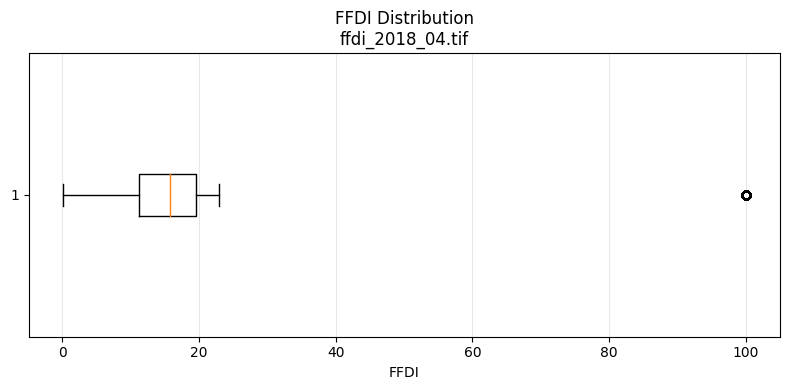

  Top repeated values (rounded):
[(100.0, 448), (19.8, 34), (19.6, 33), (18.2, 29), (19.5, 29), (11.1, 26), (11.2, 26), (17.0, 25), (17.9, 25), (18.9, 25)] 

Processing file: ffdi_2021_09.tif
  Outliers detected: 448
  Bounds: < -0.92 or > 35.57


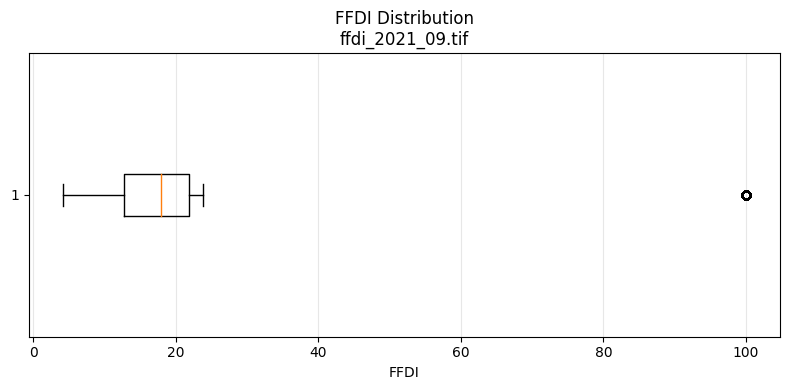

  Top repeated values (rounded):
[(100.0, 448), (18.0, 33), (21.1, 32), (21.3, 28), (21.4, 27), (18.1, 25), (21.2, 25), (22.0, 25), (22.3, 25), (21.6, 24)] 

Processing file: ffdi_2019_11.tif
  Outliers detected: 448
  Bounds: < 4.25 or > 44.06


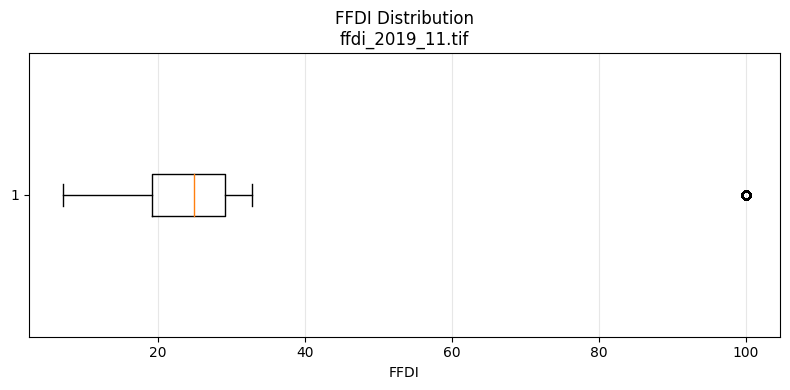

  Top repeated values (rounded):
[(100.0, 448), (27.8, 36), (27.7, 35), (27.3, 31), (27.5, 31), (27.2, 28), (27.9, 28), (18.8, 27), (19.2, 27), (19.8, 27)] 

Processing file: ffdi_2018_03.tif
  Outliers detected: 448
  Bounds: < -6.85 or > 33.86


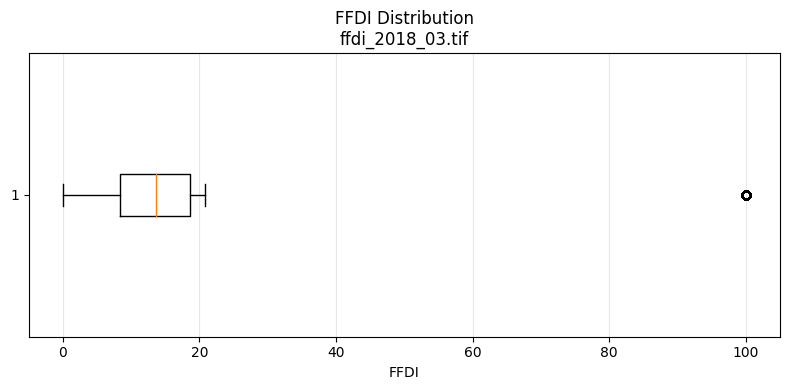

  Top repeated values (rounded):
[(100.0, 448), (8.9, 27), (8.6, 25), (6.1, 22), (8.4, 22), (16.0, 22), (16.2, 22), (9.2, 21), (9.3, 21), (14.1, 21)] 

Processing file: ffdi_2020_12.tif
  Outliers detected: 448
  Bounds: < -5.13 or > 41.29


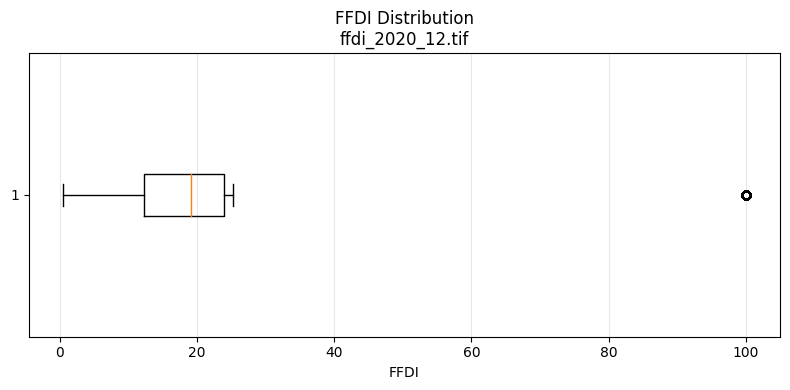

  Top repeated values (rounded):
[(100.0, 448), (24.0, 35), (23.6, 33), (23.1, 27), (23.7, 27), (23.2, 26), (23.5, 25), (10.7, 24), (23.3, 21), (24.4, 21)] 

Processing file: ffdi_2015_04.tif
  Outliers detected: 460
  Bounds: < 0.70 or > 24.91


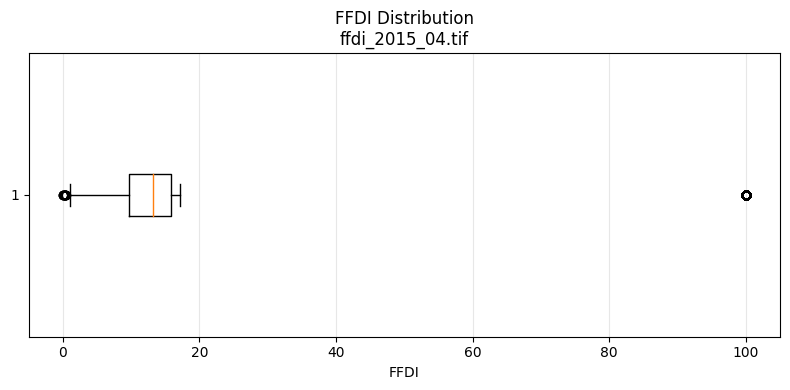

  Top repeated values (rounded):
[(100.0, 448), (15.5, 49), (15.6, 38), (15.7, 38), (9.3, 35), (11.7, 35), (14.1, 34), (15.3, 33), (16.0, 32), (11.6, 31)] 

Processing file: ffdi_2015_03.tif
  Outliers detected: 448
  Bounds: < -5.45 or > 36.98


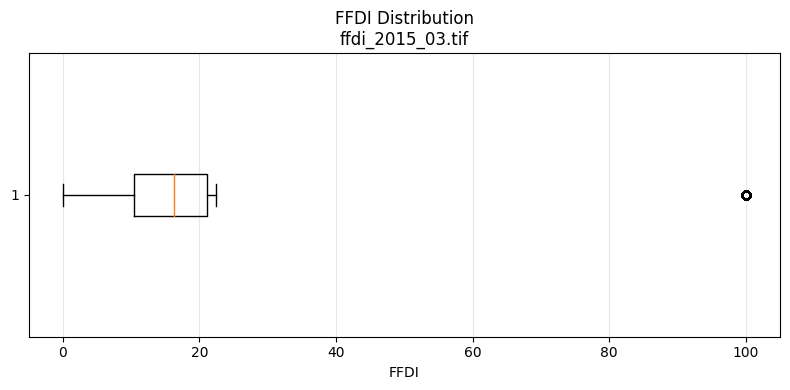

  Top repeated values (rounded):
[(100.0, 448), (21.6, 30), (21.5, 29), (21.3, 28), (10.5, 26), (19.2, 25), (21.0, 25), (21.7, 25), (11.6, 24), (11.1, 23)] 

Processing file: ffdi_2021_07.tif
  Outliers detected: 448
  Bounds: < -2.68 or > 25.82


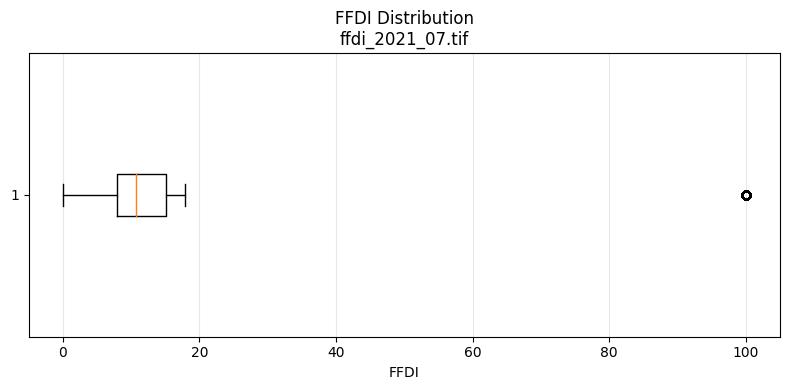

  Top repeated values (rounded):
[(100.0, 448), (9.9, 41), (10.4, 37), (9.3, 35), (10.0, 31), (9.8, 30), (10.6, 30), (6.9, 28), (7.9, 28), (9.6, 28)] 

Processing file: ffdi_2014_11.tif
  Outliers detected: 448
  Bounds: < -2.34 or > 42.07


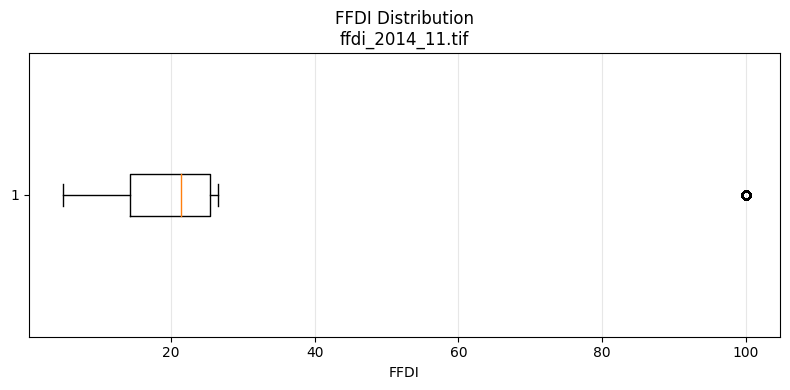

  Top repeated values (rounded):
[(100.0, 448), (25.4, 52), (25.3, 48), (25.6, 47), (25.1, 46), (25.2, 46), (25.0, 37), (25.5, 36), (25.7, 30), (25.8, 30)] 

Processing file: ffdi_2022_07.tif
  Outliers detected: 448
  Bounds: < -1.91 or > 18.68


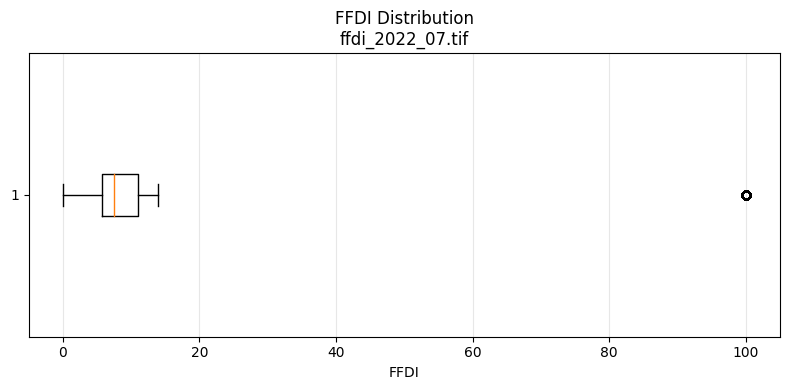

  Top repeated values (rounded):
[(100.0, 448), (5.2, 64), (5.3, 61), (7.7, 58), (5.5, 56), (5.1, 52), (6.7, 50), (7.8, 50), (5.4, 49), (6.0, 47)] 

Processing file: ffdi_2016_03.tif
  Outliers detected: 448
  Bounds: < -6.36 or > 37.11


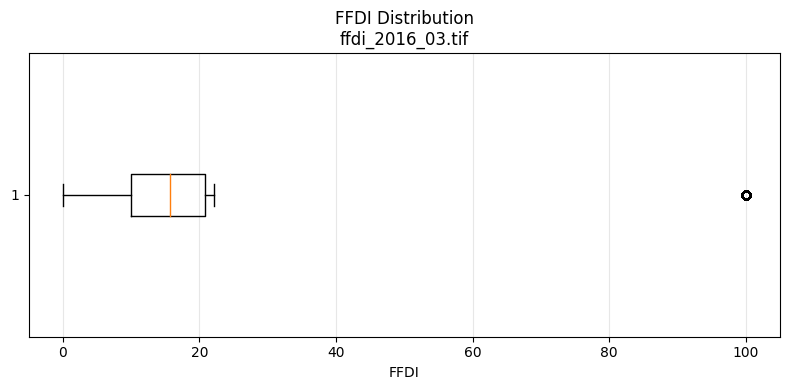

  Top repeated values (rounded):
[(100.0, 448), (21.2, 34), (21.3, 28), (9.8, 24), (21.1, 23), (8.1, 22), (21.6, 22), (18.2, 21), (19.6, 21), (20.4, 21)] 

Processing file: ffdi_2017_11.tif
  Outliers detected: 448
  Bounds: < -3.92 or > 39.41


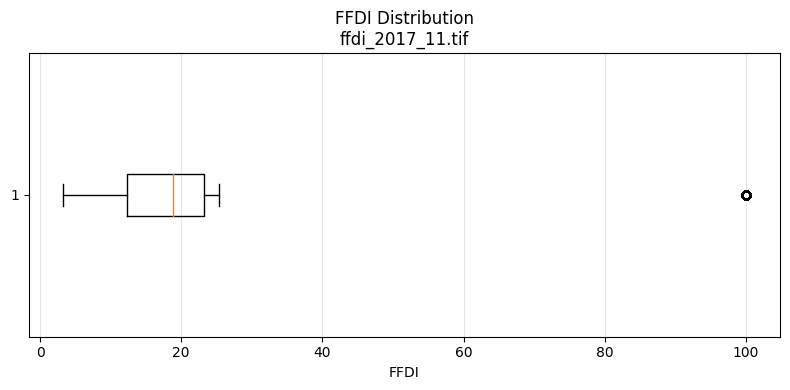

  Top repeated values (rounded):
[(100.0, 448), (23.0, 47), (23.2, 34), (22.2, 31), (22.5, 31), (23.7, 28), (22.3, 27), (22.9, 27), (23.1, 27), (23.6, 27)] 

Processing file: ffdi_2023_12.tif
  Outliers detected: 448
  Bounds: < -18.53 or > 55.70


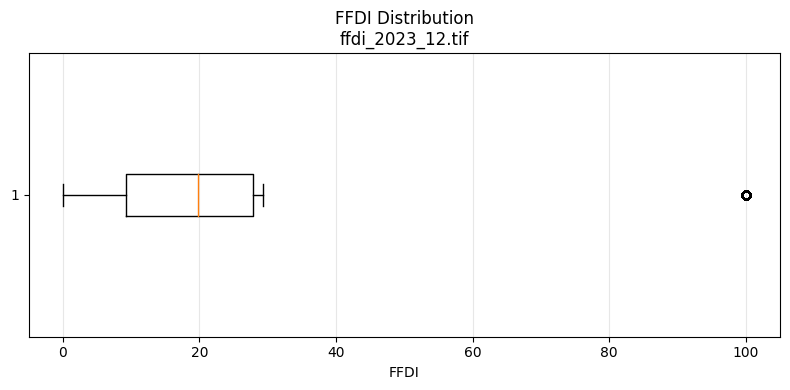

  Top repeated values (rounded):
[(100.0, 448), (7.1, 28), (28.3, 28), (28.5, 28), (8.3, 26), (28.2, 25), (0.0, 24), (28.8, 24), (7.4, 23), (7.5, 23)] 

Processing file: ffdi_2016_04.tif
  Outliers detected: 448
  Bounds: < -0.79 or > 32.35


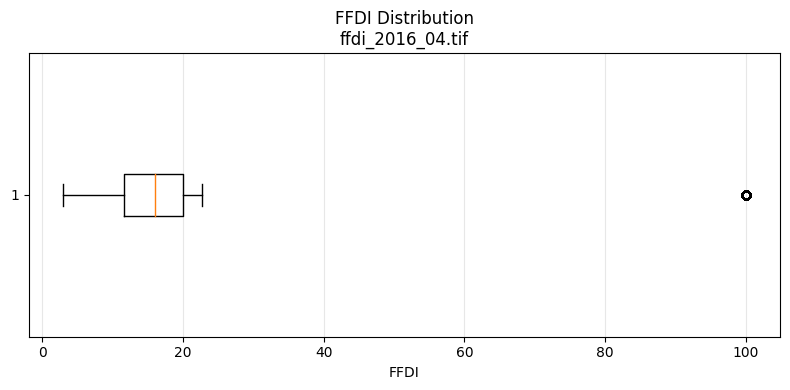

  Top repeated values (rounded):
[(100.0, 448), (14.7, 40), (20.0, 36), (19.9, 35), (19.8, 34), (14.6, 30), (16.7, 27), (20.1, 27), (20.2, 24), (12.3, 23)] 

Processing file: ffdi_2022_09.tif
  Outliers detected: 448
  Bounds: < -6.28 or > 31.62


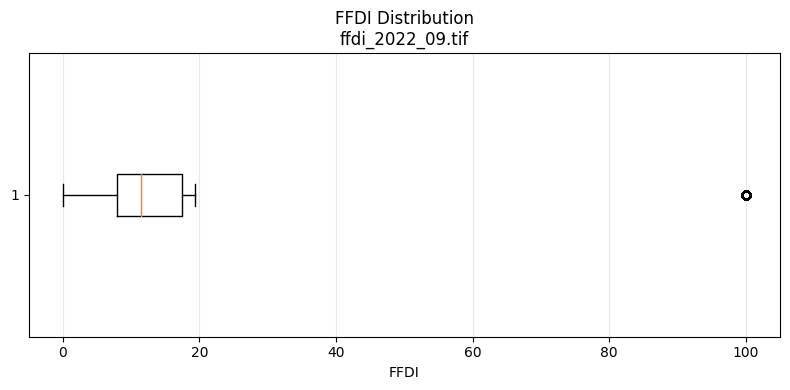

  Top repeated values (rounded):
[(100.0, 448), (6.8, 40), (6.5, 39), (6.6, 38), (0.0, 35), (8.7, 35), (6.3, 34), (6.4, 34), (6.9, 33), (6.7, 31)] 

Processing file: ffdi_2019_12.tif
  Outliers detected: 448
  Bounds: < -1.36 or > 58.77


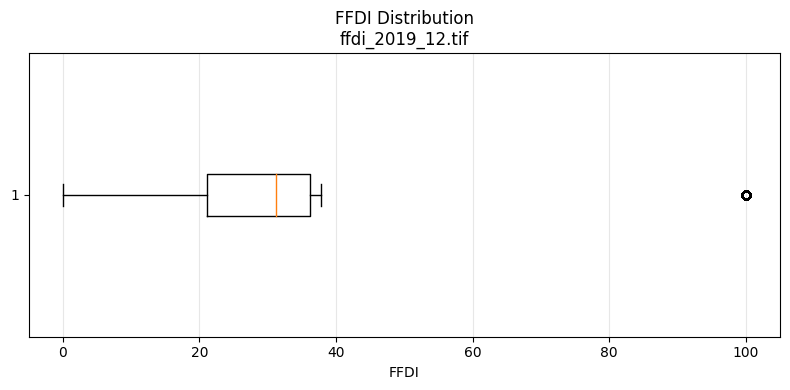

  Top repeated values (rounded):
[(100.0, 448), (35.5, 47), (35.8, 43), (35.6, 42), (35.4, 41), (35.7, 37), (35.9, 34), (35.2, 32), (35.3, 30), (35.1, 26)] 

Processing file: ffdi_2013_10.tif
  Outliers detected: 449
  Bounds: < 0.47 or > 38.66


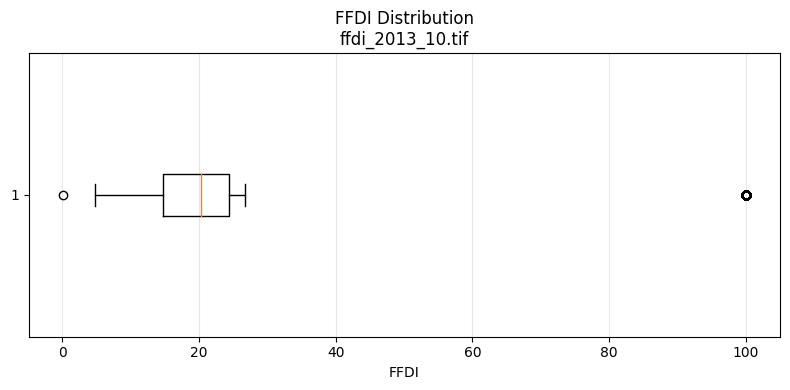

  Top repeated values (rounded):
[(100.0, 448), (22.3, 30), (22.8, 30), (21.9, 28), (22.7, 28), (22.2, 25), (14.3, 24), (19.2, 24), (22.0, 24), (22.6, 23)] 

Processing file: ffdi_2015_09.tif
  Outliers detected: 448
  Bounds: < 1.81 or > 30.26


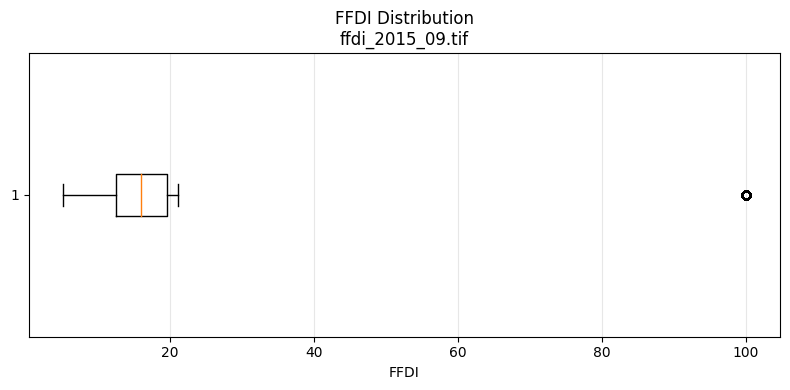

  Top repeated values (rounded):
[(100.0, 448), (16.3, 42), (16.4, 40), (14.4, 30), (15.8, 30), (14.7, 27), (16.2, 27), (20.4, 26), (13.5, 25), (16.7, 25)] 

Processing file: ffdi_2018_07.tif
  Outliers detected: 448
  Bounds: < -1.06 or > 26.36


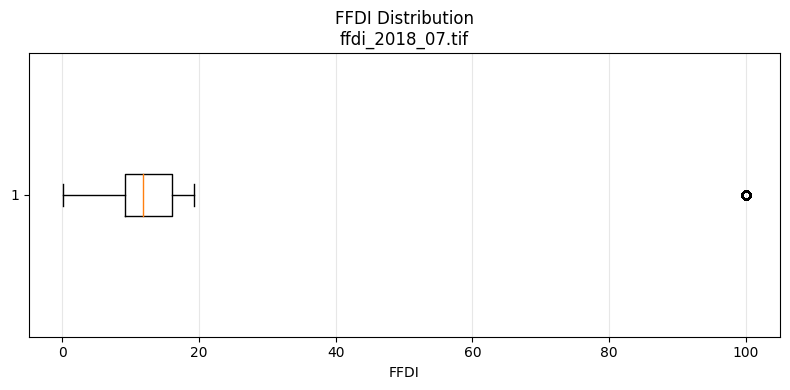

  Top repeated values (rounded):
[(100.0, 448), (8.9, 50), (9.0, 49), (9.2, 49), (8.7, 46), (8.8, 46), (8.4, 45), (8.3, 41), (9.3, 39), (9.1, 38)] 

Processing file: ffdi_2018_09.tif
  Outliers detected: 448
  Bounds: < 1.36 or > 34.62


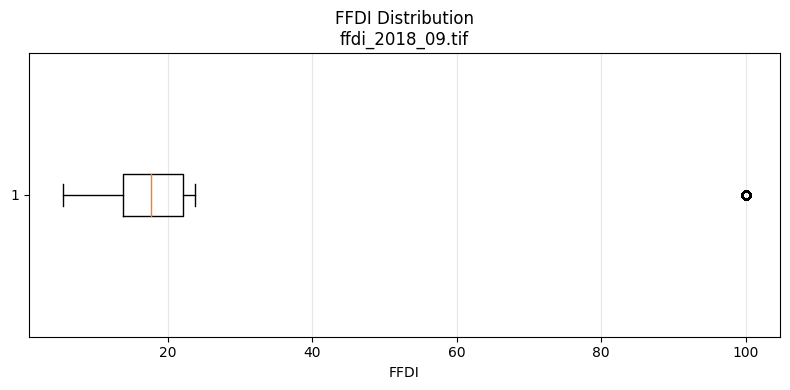

  Top repeated values (rounded):
[(100.0, 448), (12.1, 26), (13.9, 26), (14.7, 25), (15.6, 25), (14.0, 24), (19.2, 24), (22.9, 24), (15.5, 23), (17.6, 23)] 

Processing file: ffdi_2021_04.tif
  Outliers detected: 448
  Bounds: < -6.26 or > 33.36


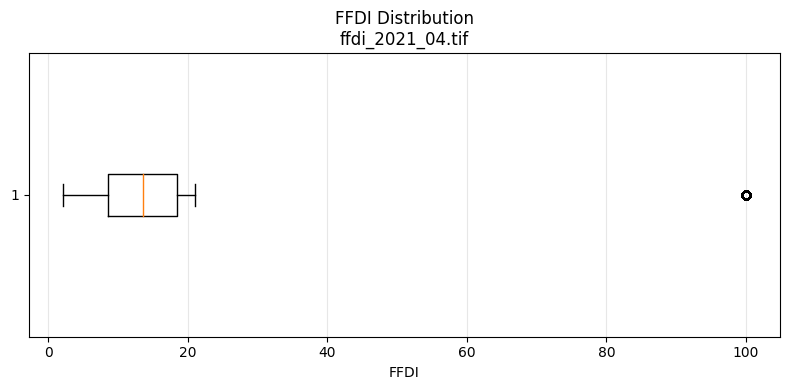

  Top repeated values (rounded):
[(100.0, 448), (7.6, 29), (7.4, 27), (8.7, 26), (9.1, 26), (7.5, 24), (7.1, 23), (17.6, 23), (6.0, 22), (8.6, 22)] 

Processing file: ffdi_2014_12.tif
  Outliers detected: 448
  Bounds: < -9.12 or > 45.55


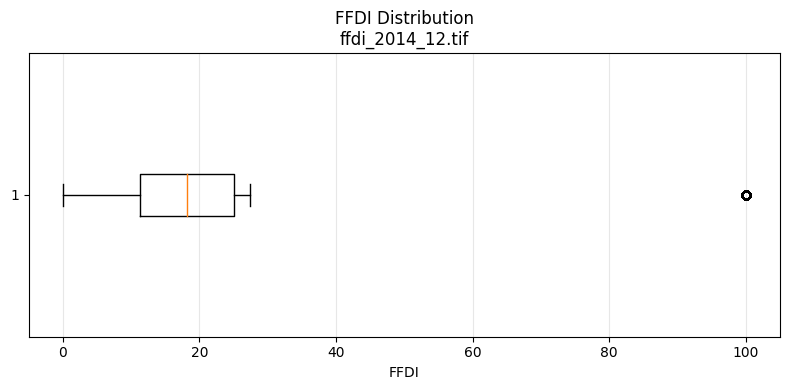

  Top repeated values (rounded):
[(100.0, 448), (11.1, 25), (10.6, 22), (11.0, 22), (27.0, 22), (11.8, 21), (11.9, 21), (9.6, 19), (10.7, 19), (11.3, 19)] 

Processing file: ffdi_2020_11.tif
  Outliers detected: 448
  Bounds: < -4.70 or > 48.42


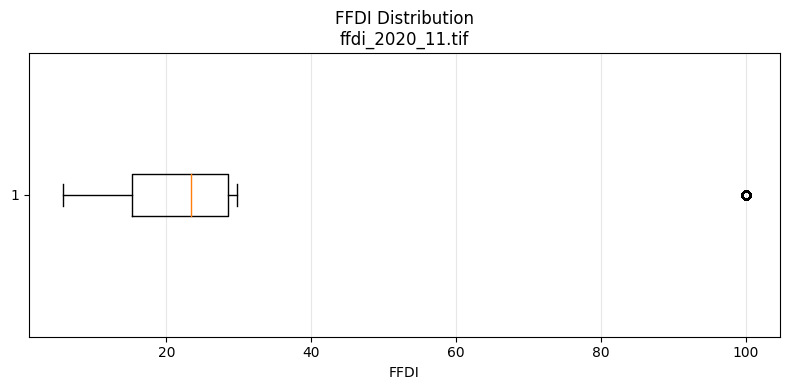

  Top repeated values (rounded):
[(100.0, 448), (28.8, 48), (28.7, 39), (28.9, 35), (28.1, 33), (28.2, 31), (28.6, 31), (28.5, 30), (28.4, 28), (27.8, 27)] 

Processing file: ffdi_2015_07.tif
  Outliers detected: 448
  Bounds: < -2.10 or > 22.46


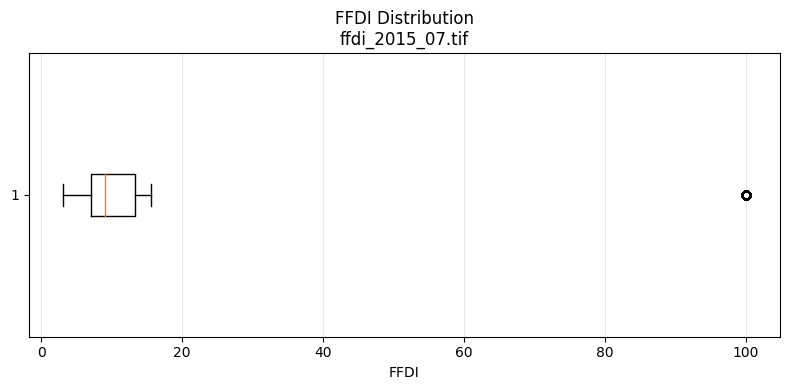

  Top repeated values (rounded):
[(100.0, 448), (7.7, 53), (7.8, 53), (6.6, 44), (7.5, 43), (5.9, 42), (6.1, 41), (7.4, 41), (7.6, 39), (6.7, 38)] 

Processing file: ffdi_2021_03.tif
  Outliers detected: 448
  Bounds: < -5.57 or > 31.25


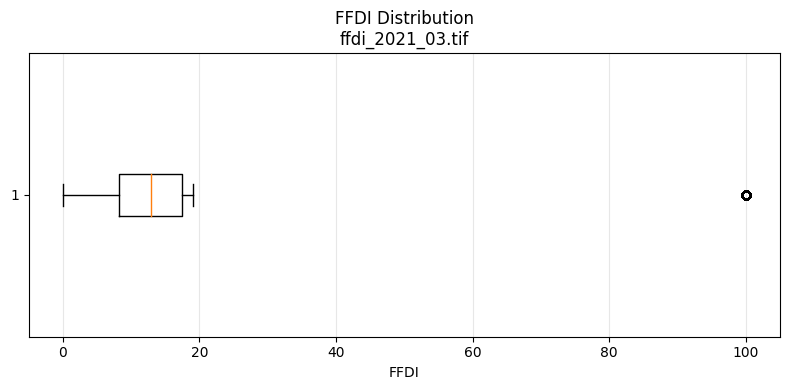

  Top repeated values (rounded):
[(100.0, 448), (8.2, 36), (8.4, 34), (17.1, 34), (7.2, 33), (17.2, 33), (17.3, 32), (7.6, 31), (16.8, 31), (7.8, 29)] 

Processing file: ffdi_2014_04.tif
  Outliers detected: 448
  Bounds: < -2.20 or > 28.35


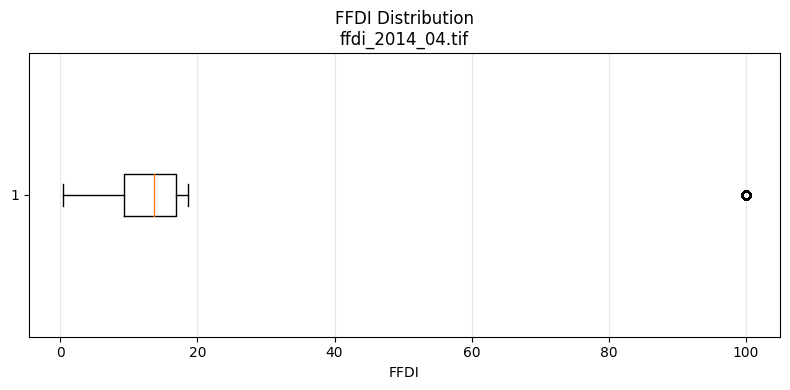

  Top repeated values (rounded):
[(100.0, 448), (16.6, 50), (16.8, 50), (16.9, 47), (16.7, 36), (16.5, 27), (8.1, 26), (12.3, 26), (12.5, 26), (17.0, 25)] 

Processing file: ffdi_2021_12.tif
  Outliers detected: 448
  Bounds: < -16.09 or > 54.39


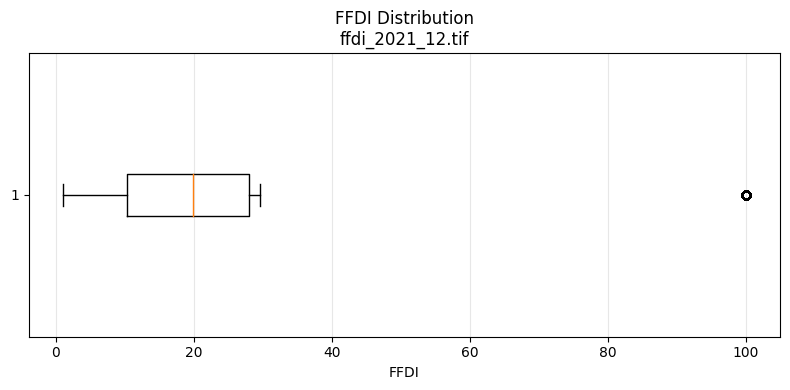

  Top repeated values (rounded):
[(100.0, 448), (9.2, 29), (9.7, 28), (27.1, 26), (8.8, 25), (6.7, 21), (8.7, 21), (10.7, 21), (10.8, 21), (28.0, 21)] 

Processing file: ffdi_2015_11.tif
  Outliers detected: 448
  Bounds: < -3.60 or > 42.06


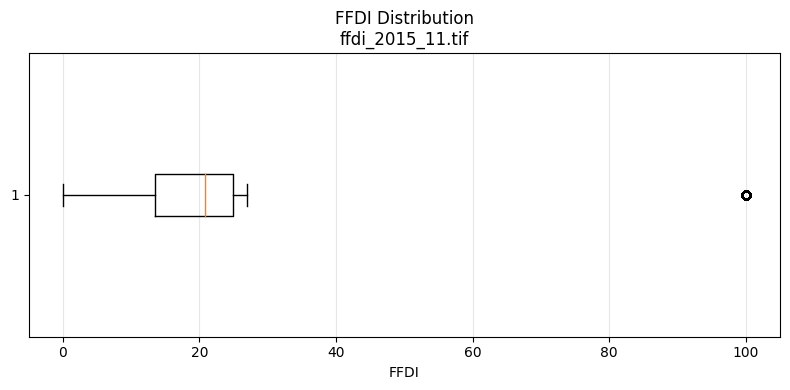

  Top repeated values (rounded):
[(100.0, 448), (25.0, 59), (24.9, 58), (25.1, 51), (24.8, 50), (24.7, 45), (24.4, 32), (24.5, 28), (25.2, 27), (24.2, 23)] 

Processing file: ffdi_2013_08.tif
  Outliers detected: 448
  Bounds: < 1.44 or > 29.25


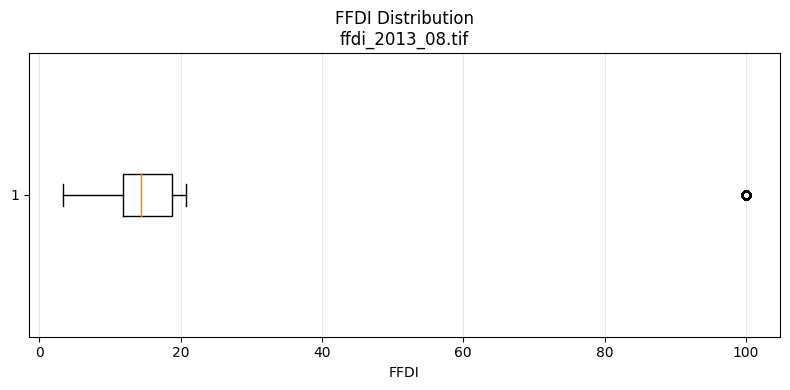

  Top repeated values (rounded):
[(100.0, 448), (13.8, 36), (14.0, 36), (13.7, 35), (13.5, 34), (13.0, 33), (13.4, 33), (14.2, 33), (13.6, 31), (11.7, 30)] 

Processing file: ffdi_2014_03.tif
  Outliers detected: 448
  Bounds: < -7.41 or > 36.53


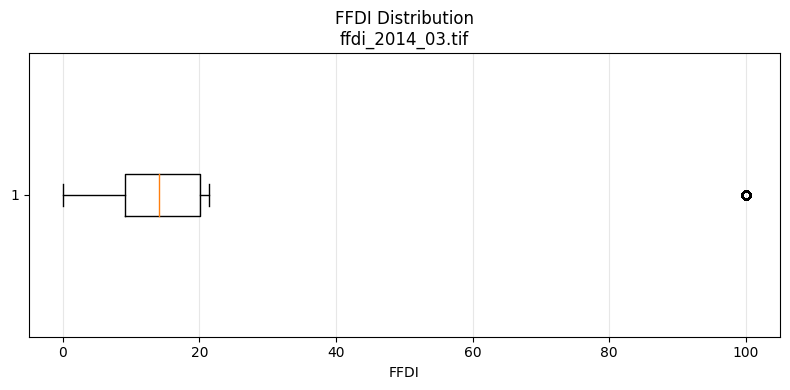

  Top repeated values (rounded):
[(100.0, 448), (10.2, 28), (21.1, 27), (7.7, 25), (9.4, 25), (20.9, 25), (7.0, 24), (20.6, 24), (8.3, 23), (8.6, 22)] 

Processing file: ffdi_2020_07.tif
  Outliers detected: 448
  Bounds: < -2.58 or > 23.46


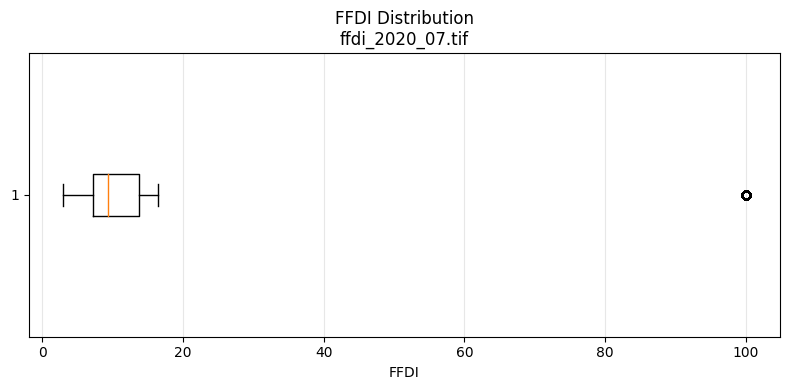

  Top repeated values (rounded):
[(100.0, 448), (6.4, 60), (6.2, 49), (7.8, 46), (6.3, 45), (8.1, 44), (6.1, 43), (7.0, 43), (7.5, 41), (8.0, 41)] 

Processing file: ffdi_2013_06.tif
  Outliers detected: 448
  Bounds: < -1.54 or > 19.22


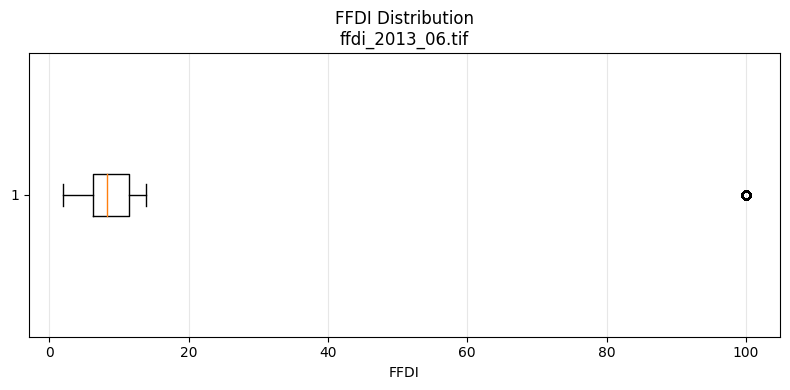

  Top repeated values (rounded):
[(100.0, 448), (6.9, 56), (5.6, 49), (5.9, 48), (6.0, 47), (5.8, 46), (6.1, 46), (6.5, 45), (6.2, 44), (5.4, 41)] 

Processing file: ffdi_2020_09.tif
  Outliers detected: 448
  Bounds: < 0.37 or > 34.63


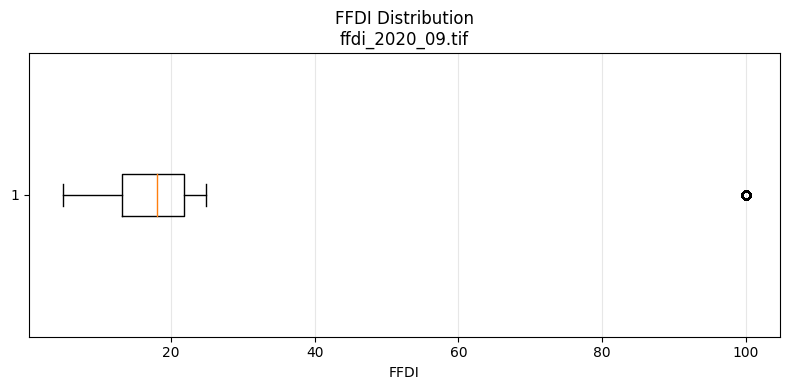

  Top repeated values (rounded):
[(100.0, 448), (19.2, 32), (20.8, 29), (10.3, 25), (19.0, 25), (21.7, 25), (12.3, 23), (15.9, 23), (18.8, 23), (18.4, 22)] 

Processing file: ffdi_2019_04.tif
  Outliers detected: 448
  Bounds: < -3.95 or > 26.86


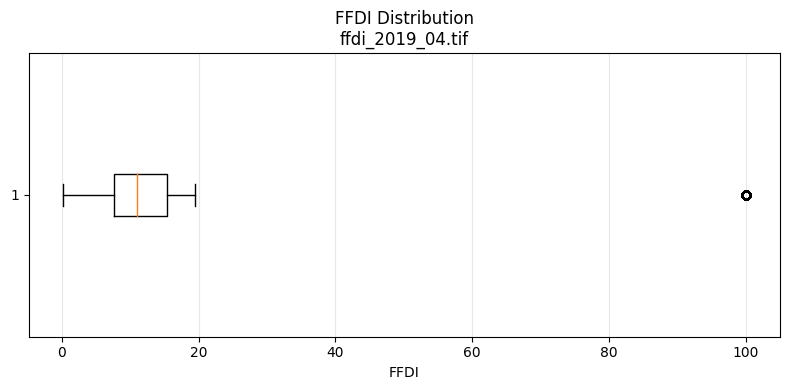

  Top repeated values (rounded):
[(100.0, 448), (7.2, 34), (10.8, 34), (6.6, 33), (6.8, 32), (10.3, 32), (13.6, 30), (7.0, 29), (7.3, 29), (10.0, 28)] 

Processing file: ffdi_2013_01.tif
  Outliers detected: 448
  Bounds: < -8.73 or > 31.10


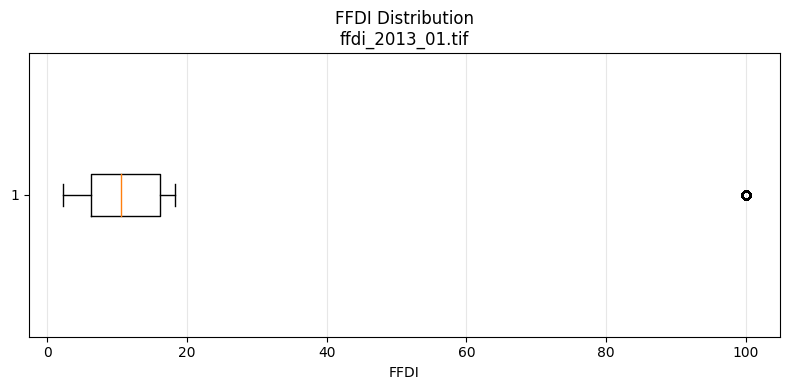

  Top repeated values (rounded):
[(100.0, 448), (5.6, 34), (5.1, 30), (6.2, 29), (5.3, 28), (6.6, 28), (5.8, 27), (3.8, 25), (4.1, 25), (4.9, 25)] 

Processing file: ffdi_2019_03.tif
  Outliers detected: 448
  Bounds: < -12.14 or > 45.41


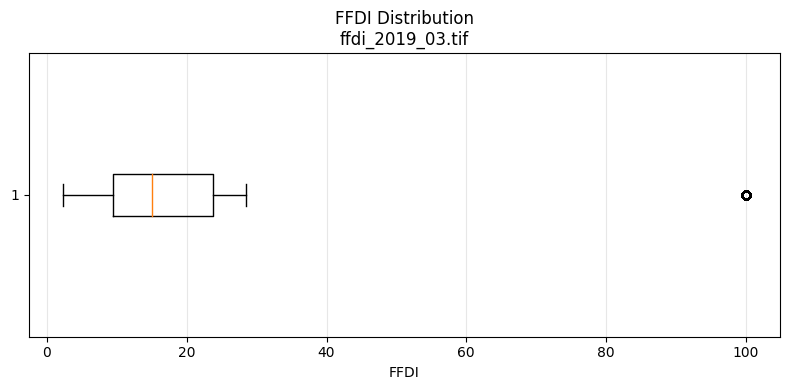

  Top repeated values (rounded):
[(100.0, 448), (6.5, 23), (9.0, 23), (5.6, 22), (10.0, 21), (11.4, 21), (6.1, 20), (9.2, 20), (5.7, 19), (9.1, 19)] 

Processing file: ffdi_2018_11.tif
  Outliers detected: 449
  Bounds: < 1.93 or > 37.97


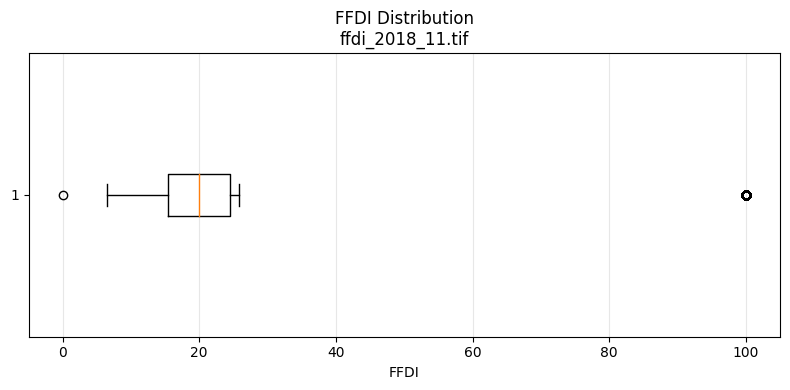

  Top repeated values (rounded):
[(100.0, 448), (24.9, 30), (22.6, 28), (25.2, 28), (17.1, 27), (22.5, 26), (23.1, 26), (25.3, 25), (23.0, 24), (25.0, 24)] 

Processing file: ffdi_2017_09.tif
  Outliers detected: 448
  Bounds: < 3.01 or > 36.96


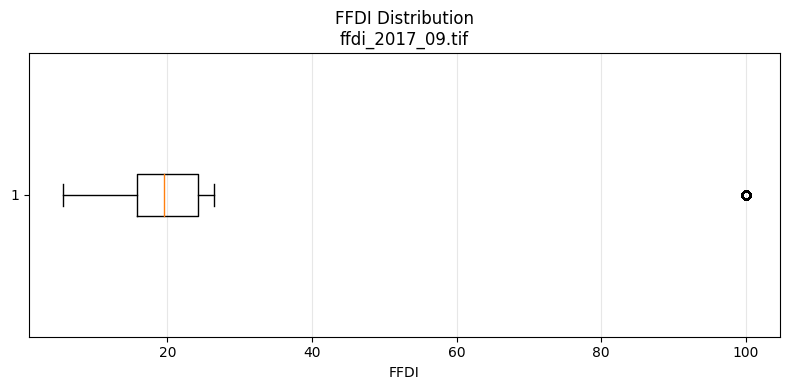

  Top repeated values (rounded):
[(100.0, 448), (16.6, 27), (16.3, 24), (18.7, 24), (21.5, 24), (15.4, 23), (15.7, 23), (16.5, 23), (16.8, 23), (18.2, 23)] 

Processing file: ffdi_2023_03.tif
  Outliers detected: 448
  Bounds: < -17.17 or > 49.77


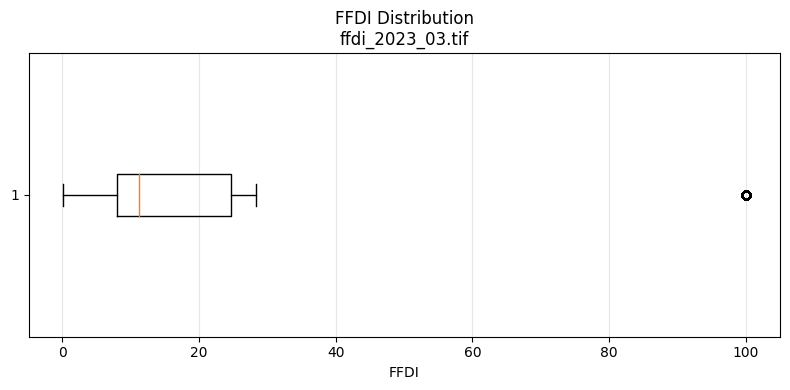

  Top repeated values (rounded):
[(100.0, 448), (5.8, 35), (6.0, 31), (8.5, 30), (6.3, 28), (8.0, 27), (8.2, 27), (8.3, 27), (8.4, 27), (6.4, 26)] 

Processing file: ffdi_2017_07.tif
  Outliers detected: 448
  Bounds: < -0.79 or > 26.32


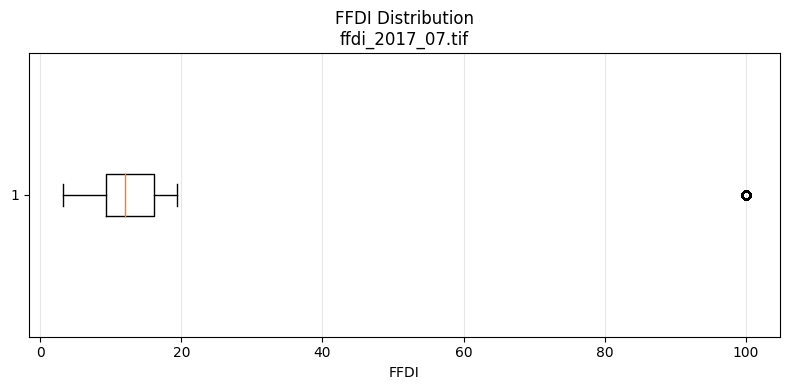

  Top repeated values (rounded):
[(100.0, 448), (8.8, 44), (8.4, 43), (9.0, 42), (8.6, 41), (8.9, 40), (9.4, 39), (9.1, 38), (9.2, 38), (9.9, 38)] 

Processing file: ffdi_2022_11.tif
  Outliers detected: 448
  Bounds: < -1.98 or > 33.34


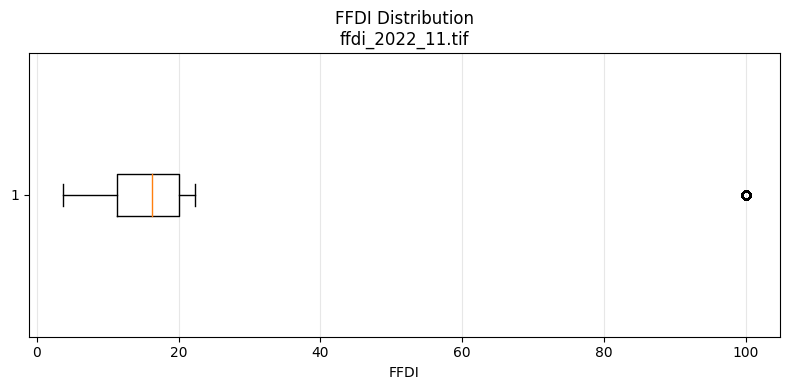

  Top repeated values (rounded):
[(100.0, 448), (19.9, 46), (20.2, 43), (20.1, 42), (19.7, 39), (20.3, 38), (20.4, 37), (19.8, 36), (19.4, 33), (19.5, 33)] 

Processing file: ffdi_2016_12.tif
  Outliers detected: 448
  Bounds: < -4.92 or > 42.41


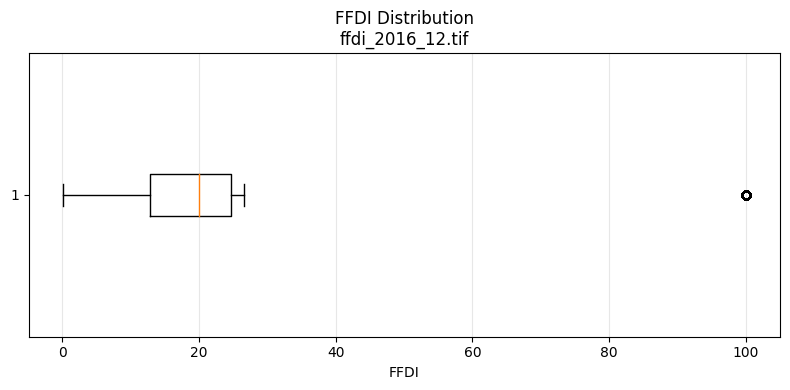

  Top repeated values (rounded):
[(100.0, 448), (24.4, 34), (24.7, 34), (24.5, 27), (23.6, 25), (24.0, 25), (25.4, 25), (23.4, 24), (23.9, 24), (24.6, 23)] 

Processing file: ffdi_2023_04.tif
  Outliers detected: 460
  Bounds: < 0.37 or > 25.34


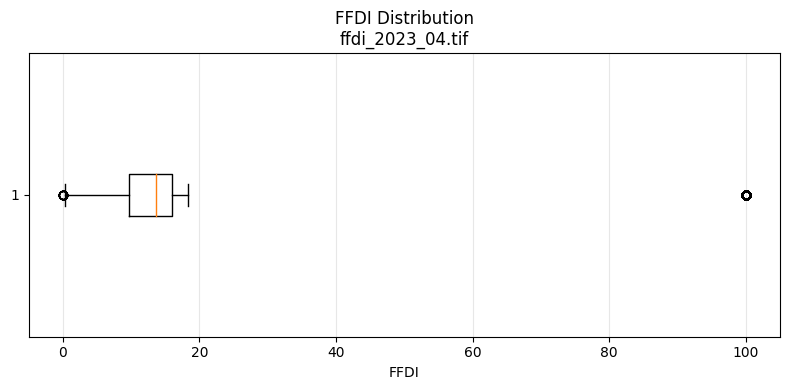

  Top repeated values (rounded):
[(100.0, 448), (14.2, 43), (14.0, 39), (14.3, 38), (16.0, 38), (16.1, 38), (15.9, 37), (10.1, 35), (14.1, 34), (10.7, 33)] 

Processing file: ffdi_2020_10.tif
  Outliers detected: 448
  Bounds: < 1.04 or > 34.13


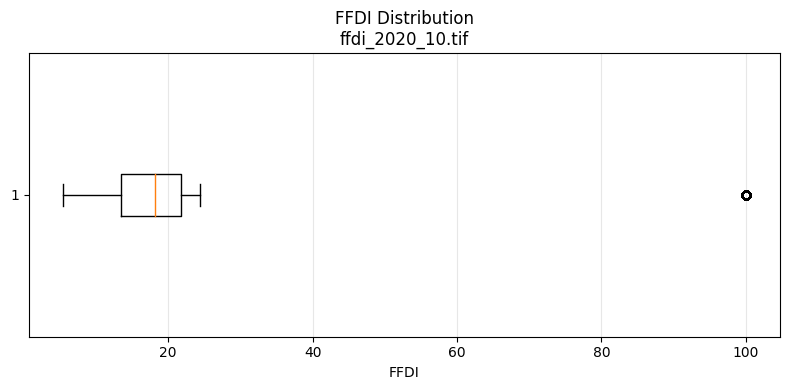

  Top repeated values (rounded):
[(100.0, 448), (19.6, 35), (17.9, 31), (19.7, 30), (15.8, 29), (19.4, 29), (19.8, 29), (18.5, 27), (19.0, 27), (19.3, 26)] 

Processing file: ffdi_2015_06.tif
  Outliers detected: 448
  Bounds: < -1.73 or > 18.68


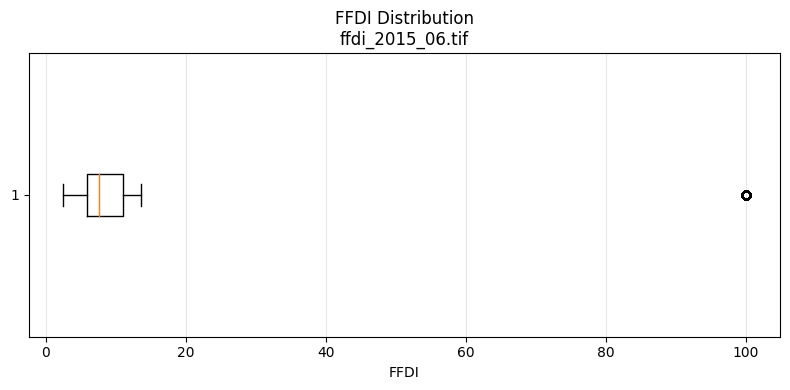

  Top repeated values (rounded):
[(100.0, 448), (5.3, 57), (5.1, 55), (5.0, 54), (5.4, 54), (6.7, 54), (7.3, 54), (7.0, 51), (5.6, 50), (5.5, 48)] 

Processing file: ffdi_2021_02.tif
  Outliers detected: 448
  Bounds: < -15.18 or > 47.28


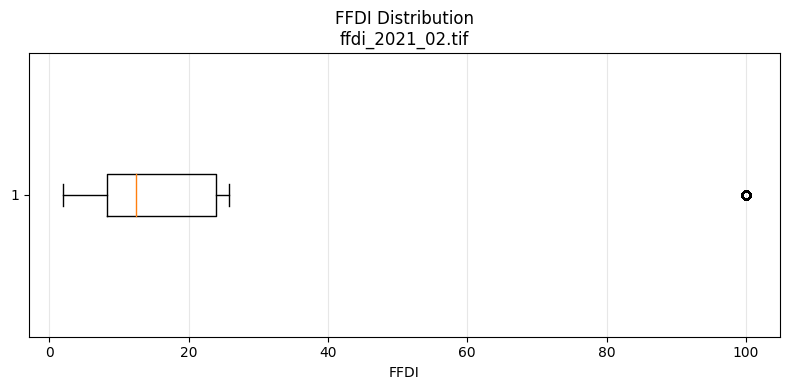

  Top repeated values (rounded):
[(100.0, 448), (25.2, 29), (9.8, 28), (9.3, 27), (25.1, 27), (24.8, 26), (6.3, 25), (9.9, 25), (5.1, 24), (12.3, 24)] 

Processing file: ffdi_2015_01.tif
  Outliers detected: 448
  Bounds: < -11.15 or > 42.31


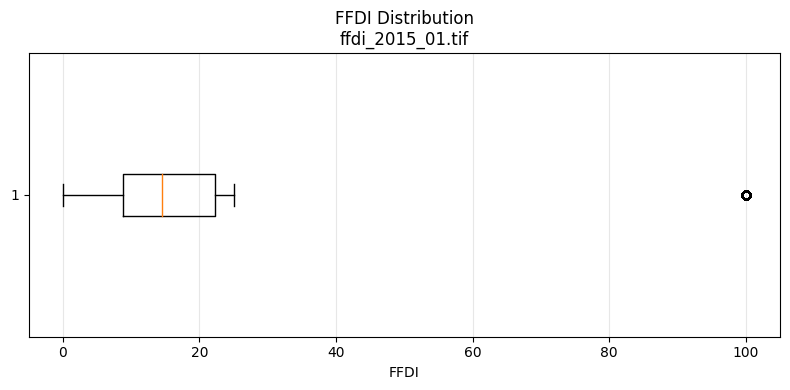

  Top repeated values (rounded):
[(100.0, 448), (9.9, 26), (8.1, 25), (0.0, 24), (7.9, 21), (10.6, 21), (23.3, 21), (9.7, 20), (10.2, 20), (16.1, 20)] 

Processing file: ffdi_2018_08.tif
  Outliers detected: 448
  Bounds: < 0.07 or > 29.68


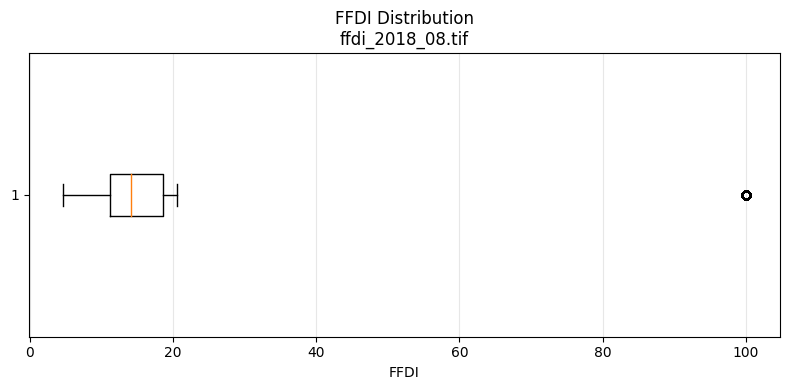

  Top repeated values (rounded):
[(100.0, 448), (10.6, 40), (10.7, 37), (11.7, 35), (10.8, 34), (10.5, 33), (10.9, 33), (11.1, 33), (11.3, 32), (11.5, 31)] 

Processing file: ffdi_2021_05.tif
  Outliers detected: 448
  Bounds: < -1.41 or > 26.04


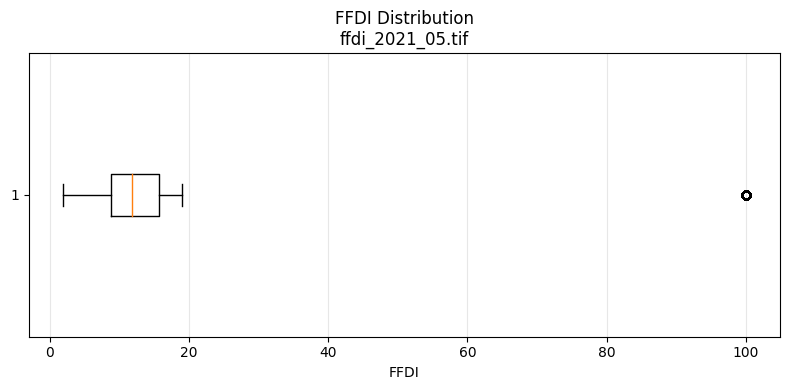

  Top repeated values (rounded):
[(100.0, 448), (14.1, 35), (13.7, 32), (10.1, 31), (9.9, 30), (14.0, 30), (9.6, 29), (10.7, 29), (13.8, 29), (9.8, 28)] 

Processing file: ffdi_2018_06.tif
  Outliers detected: 448
  Bounds: < -0.84 or > 21.76


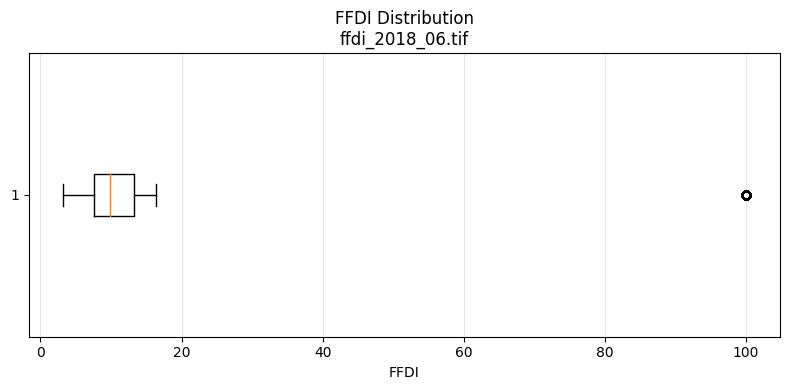

  Top repeated values (rounded):
[(100.0, 448), (7.4, 64), (7.6, 55), (8.9, 51), (7.3, 46), (7.0, 44), (7.2, 44), (7.5, 43), (7.1, 42), (8.7, 41)] 

Processing file: ffdi_2013_11.tif
  Outliers detected: 448
  Bounds: < -2.51 or > 40.10


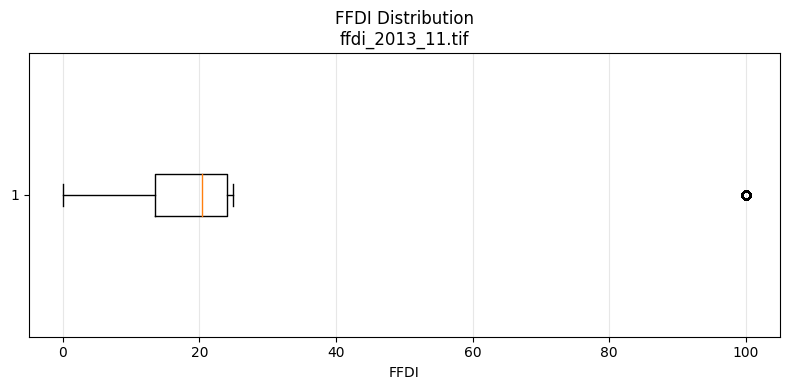

  Top repeated values (rounded):
[(100.0, 448), (24.1, 62), (24.2, 55), (24.4, 52), (23.8, 51), (24.3, 50), (23.9, 45), (24.0, 41), (23.7, 40), (24.5, 32)] 

Processing file: ffdi_2015_08.tif
  Outliers detected: 448
  Bounds: < 0.31 or > 26.36


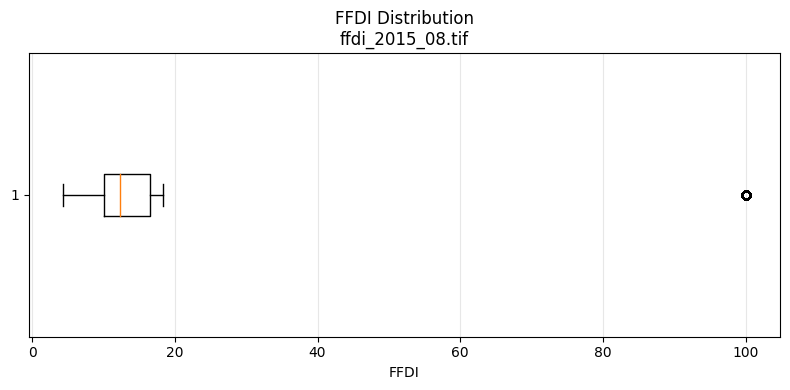

  Top repeated values (rounded):
[(100.0, 448), (11.3, 40), (11.4, 40), (11.5, 40), (11.1, 39), (11.9, 39), (9.3, 37), (9.5, 35), (9.6, 35), (12.1, 35)] 

Processing file: ffdi_2018_01.tif
  Outliers detected: 448
  Bounds: < -11.66 or > 50.48


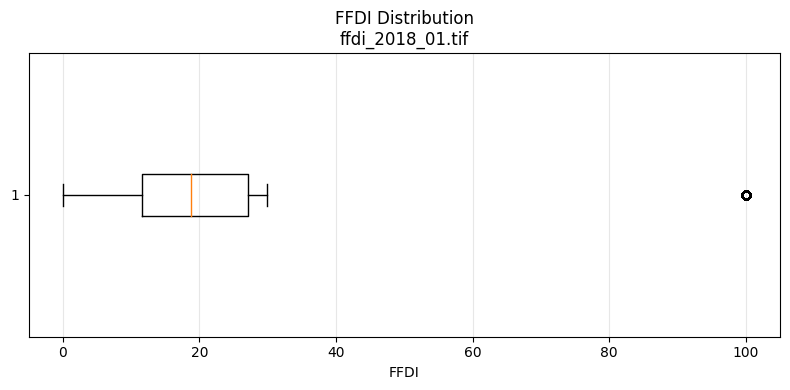

  Top repeated values (rounded):
[(100.0, 448), (9.5, 25), (11.0, 25), (11.6, 20), (9.1, 19), (9.6, 18), (10.3, 18), (13.3, 18), (28.1, 18), (9.8, 16)] 

Processing file: ffdi_2022_08.tif
  Outliers detected: 448
  Bounds: < -4.15 or > 27.63


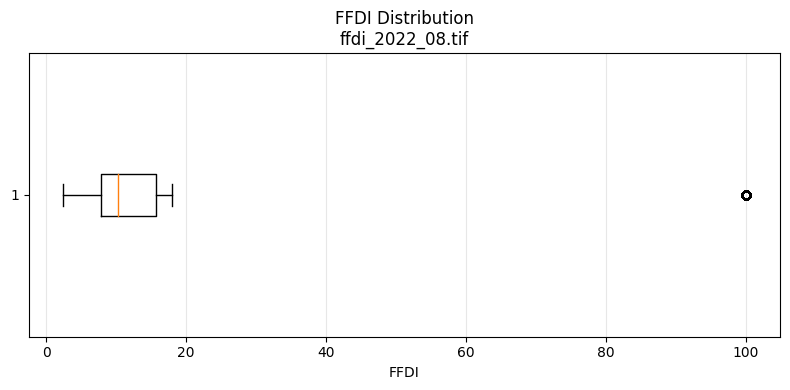

  Top repeated values (rounded):
[(100.0, 448), (6.2, 46), (6.6, 42), (8.8, 39), (9.2, 39), (6.5, 38), (6.4, 37), (9.6, 36), (10.3, 36), (6.3, 32)] 

Processing file: ffdi_2022_01.tif
  Outliers detected: 448
  Bounds: < -7.77 or > 40.79


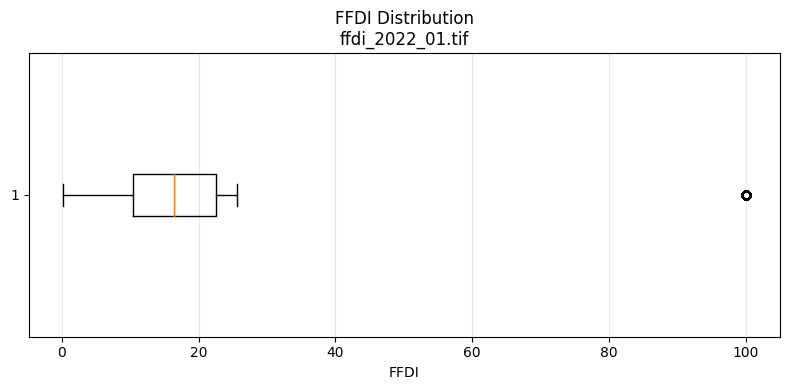

  Top repeated values (rounded):
[(100.0, 448), (12.1, 24), (11.4, 23), (11.7, 20), (10.6, 19), (21.3, 19), (22.8, 19), (22.9, 19), (10.9, 18), (14.3, 18)] 

Processing file: ffdi_2016_05.tif
  Outliers detected: 448
  Bounds: < 2.81 or > 21.76


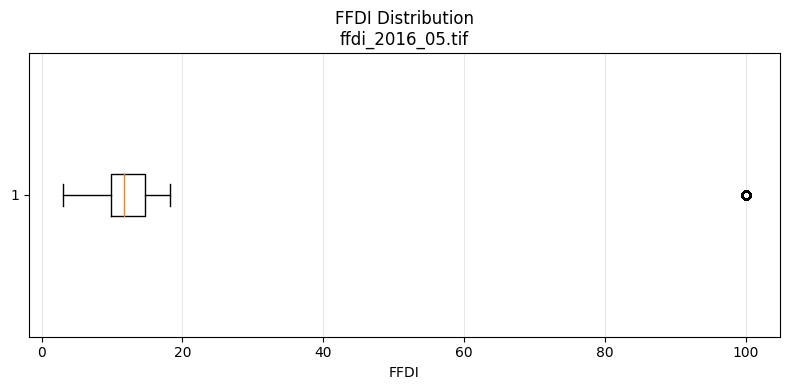

  Top repeated values (rounded):
[(100.0, 448), (10.2, 55), (10.3, 54), (10.1, 53), (9.6, 51), (10.0, 51), (9.9, 48), (9.7, 44), (10.7, 44), (10.4, 42)] 

Processing file: ffdi_2022_06.tif
  Outliers detected: 448
  Bounds: < -2.83 or > 20.46


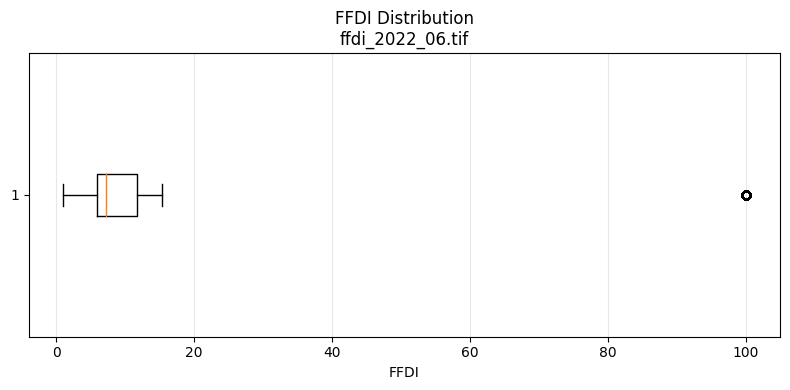

  Top repeated values (rounded):
[(100.0, 448), (5.7, 64), (6.9, 64), (7.2, 60), (5.8, 59), (6.8, 58), (7.3, 58), (5.3, 56), (6.4, 56), (5.5, 55)] 

Processing file: ffdi_2016_02.tif
  Outliers detected: 448
  Bounds: < -8.55 or > 41.55


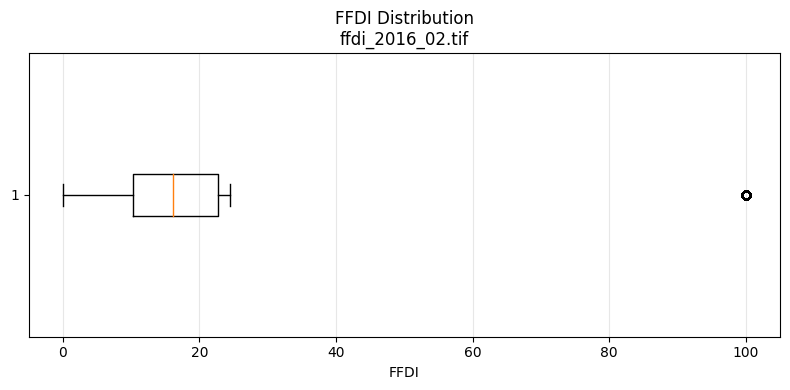

  Top repeated values (rounded):
[(100.0, 448), (23.5, 26), (10.5, 25), (23.6, 25), (23.7, 24), (23.8, 24), (23.9, 24), (9.4, 23), (10.8, 21), (9.1, 20)] 

Processing file: ffdi_2017_10.tif
  Outliers detected: 448
  Bounds: < -2.11 or > 39.16


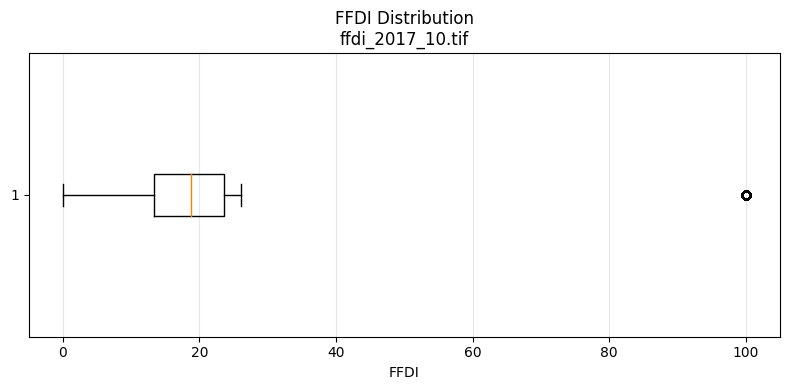

  Top repeated values (rounded):
[(100.0, 448), (0.0, 35), (20.3, 25), (15.5, 23), (24.9, 23), (21.4, 21), (21.6, 21), (25.1, 21), (22.2, 20), (10.3, 19)] 

Processing file: ffdi_2023_05.tif
  Outliers detected: 448
  Bounds: < 1.69 or > 20.47


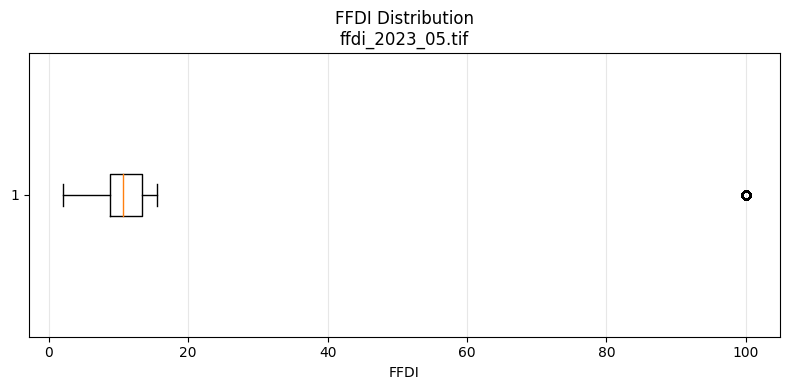

  Top repeated values (rounded):
[(100.0, 448), (8.7, 50), (9.6, 47), (9.5, 45), (9.0, 44), (10.4, 43), (9.1, 41), (9.7, 41), (9.2, 40), (9.4, 39)] 

Processing file: ffdi_2017_01.tif
  Outliers detected: 448
  Bounds: < -10.43 or > 44.58


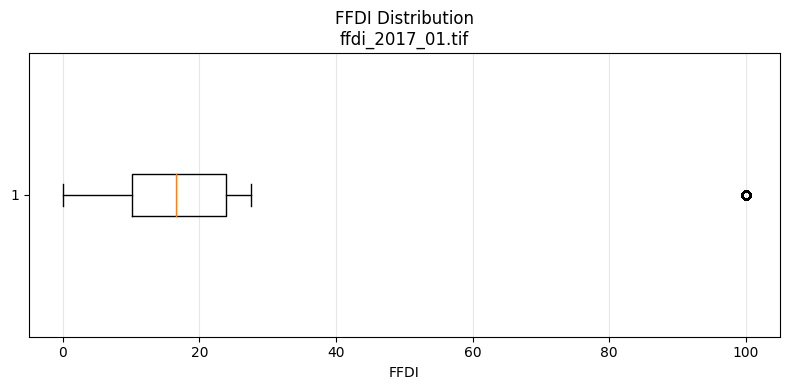

  Top repeated values (rounded):
[(100.0, 448), (0.1, 29), (7.8, 21), (12.8, 21), (11.9, 19), (0.0, 18), (11.2, 18), (9.8, 17), (10.9, 17), (8.1, 16)] 

Processing file: ffdi_2023_02.tif
  Outliers detected: 448
  Bounds: < -16.41 or > 45.36


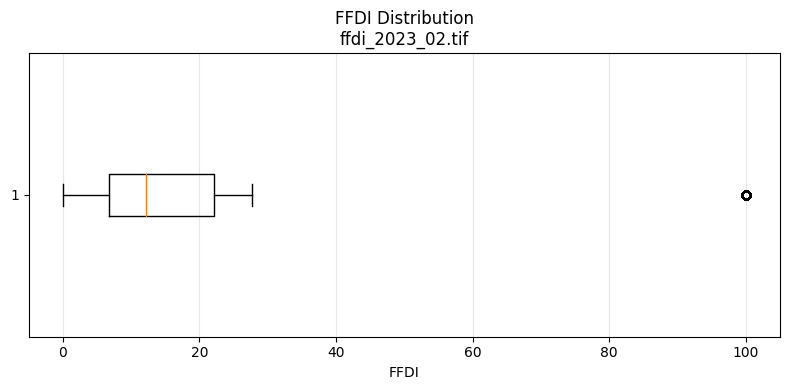

  Top repeated values (rounded):
[(100.0, 448), (5.3, 33), (5.7, 28), (5.5, 27), (5.0, 25), (5.8, 25), (5.1, 24), (10.1, 24), (4.8, 23), (4.4, 22)] 

Processing file: ffdi_2017_06.tif
  Outliers detected: 448
  Bounds: < -0.07 or > 21.85


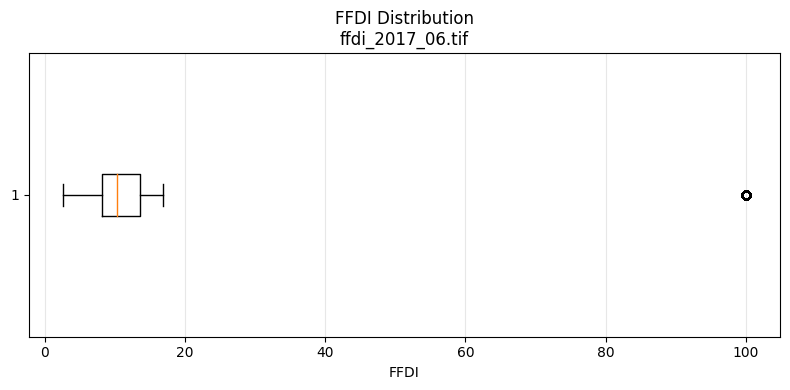

  Top repeated values (rounded):
[(100.0, 448), (8.2, 59), (7.6, 55), (8.1, 48), (8.3, 47), (7.9, 46), (7.7, 45), (8.0, 41), (9.4, 40), (11.6, 39)] 

Processing file: ffdi_2022_10.tif
  Outliers detected: 448
  Bounds: < -5.09 or > 31.35


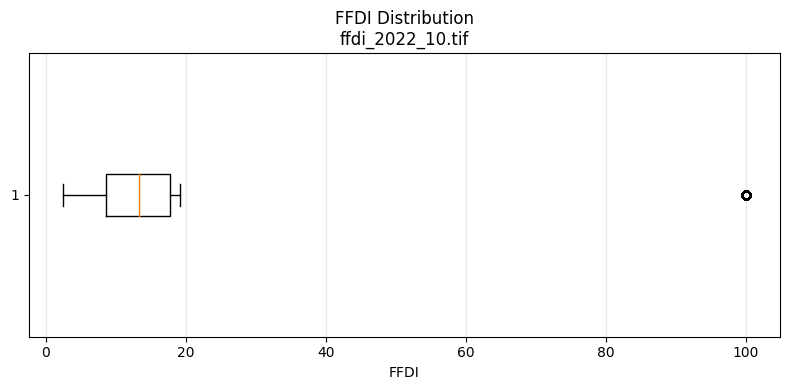

  Top repeated values (rounded):
[(100.0, 448), (7.4, 46), (7.5, 45), (7.8, 41), (7.7, 39), (7.9, 38), (7.6, 37), (8.0, 37), (7.3, 35), (7.2, 30)] 

Processing file: ffdi_2017_08.tif
  Outliers detected: 448
  Bounds: < 0.03 or > 31.49


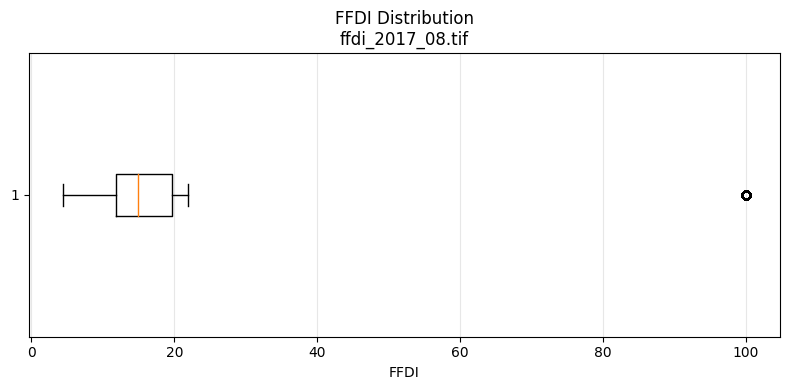

  Top repeated values (rounded):
[(100.0, 448), (11.5, 39), (11.9, 36), (11.6, 33), (12.0, 33), (10.6, 32), (10.9, 31), (11.2, 31), (11.3, 31), (10.4, 30)] 

Processing file: ffdi_2019_02.tif
  Outliers detected: 448
  Bounds: < -11.13 or > 45.22


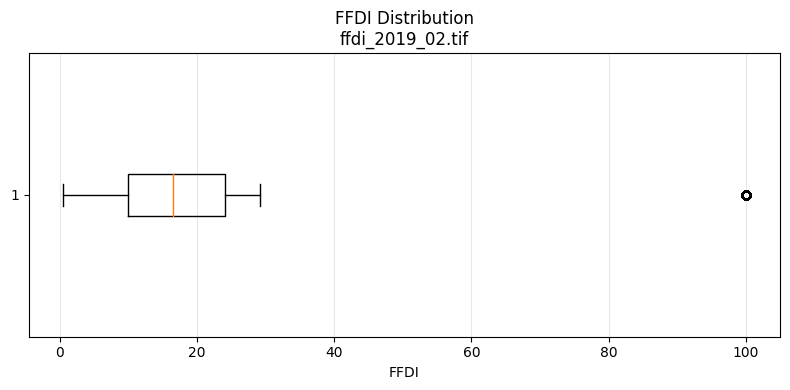

  Top repeated values (rounded):
[(100.0, 448), (13.9, 22), (13.7, 19), (5.9, 18), (14.3, 18), (6.3, 17), (11.8, 17), (14.2, 17), (13.0, 16), (13.6, 16)] 

Processing file: ffdi_2018_10.tif
  Outliers detected: 448
  Bounds: < -2.53 or > 44.55


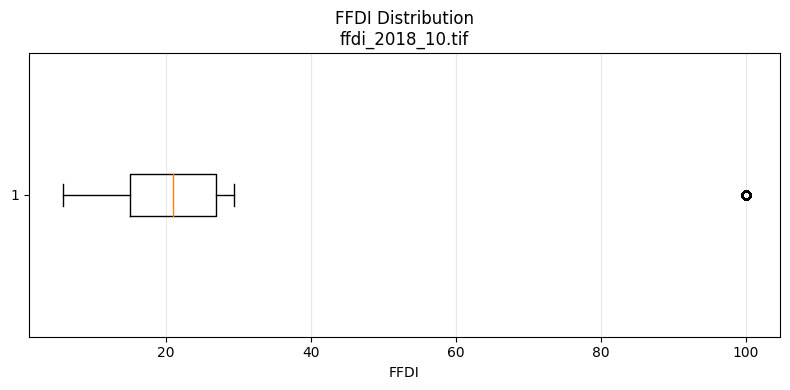

  Top repeated values (rounded):
[(100.0, 448), (28.3, 21), (15.0, 19), (22.9, 19), (27.8, 19), (19.1, 18), (19.4, 18), (20.4, 18), (23.8, 18), (24.6, 18)] 

Processing file: ffdi_2013_07.tif
  Outliers detected: 448
  Bounds: < -0.79 or > 20.54


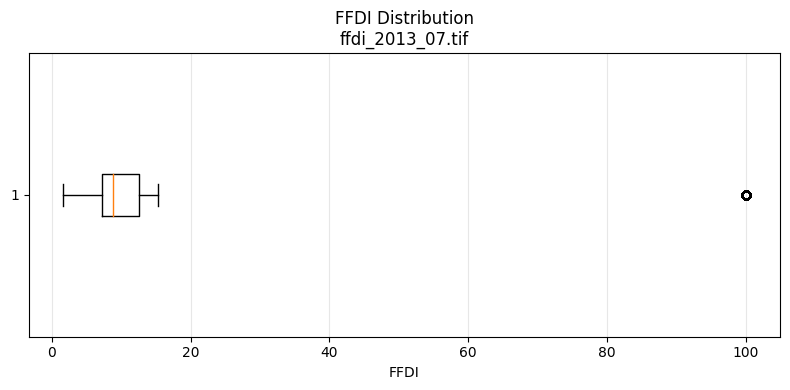

  Top repeated values (rounded):
[(100.0, 448), (8.0, 63), (8.3, 55), (8.2, 53), (7.8, 49), (7.9, 49), (7.6, 48), (7.7, 46), (7.0, 45), (8.1, 45)] 

Processing file: ffdi_2020_08.tif
  Outliers detected: 448
  Bounds: < -0.86 or > 27.31


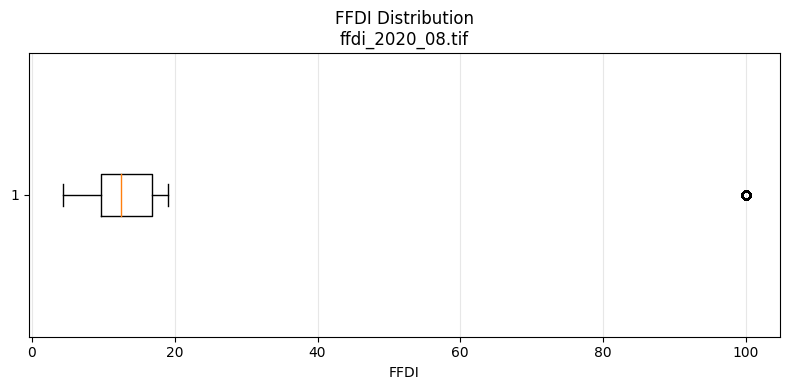

  Top repeated values (rounded):
[(100.0, 448), (10.8, 37), (9.9, 36), (8.4, 33), (8.7, 31), (12.4, 30), (11.4, 29), (11.7, 29), (11.9, 29), (8.5, 28)] 

Processing file: ffdi_2019_05.tif
  Outliers detected: 448
  Bounds: < -0.22 or > 19.06


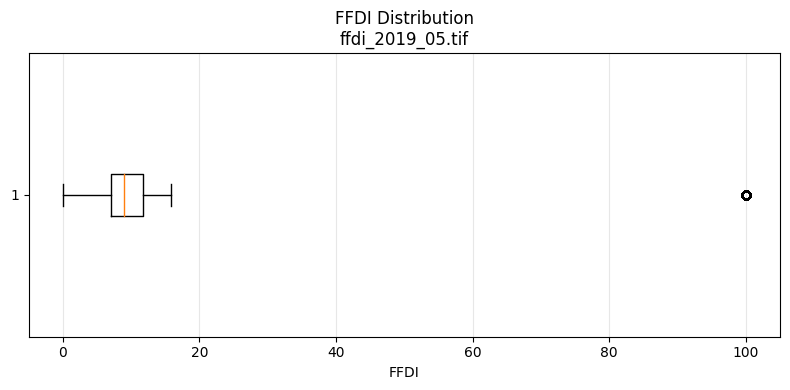

  Top repeated values (rounded):
[(100.0, 448), (7.5, 54), (6.7, 45), (7.4, 45), (6.8, 43), (5.6, 42), (6.9, 42), (9.4, 41), (5.9, 39), (6.4, 39)] 

Processing file: ffdi_2015_10.tif
  Outliers detected: 448
  Bounds: < -0.29 or > 37.65


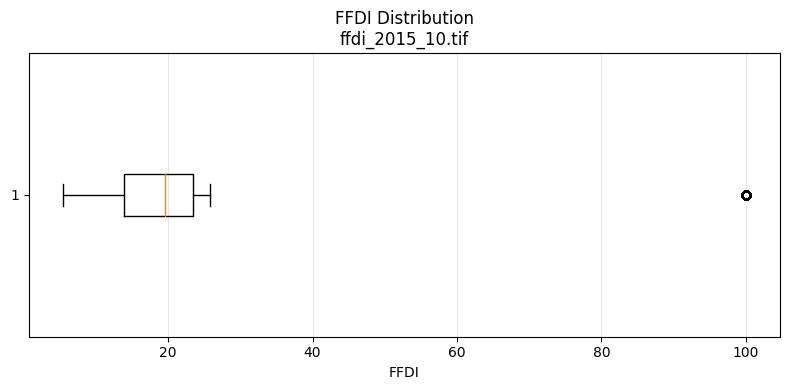

  Top repeated values (rounded):
[(100.0, 448), (22.3, 35), (21.7, 33), (22.0, 32), (22.2, 32), (22.1, 31), (22.5, 29), (14.2, 25), (21.9, 25), (17.3, 24)] 

Processing file: ffdi_2014_02.tif
  Outliers detected: 448
  Bounds: < -8.66 or > 34.58


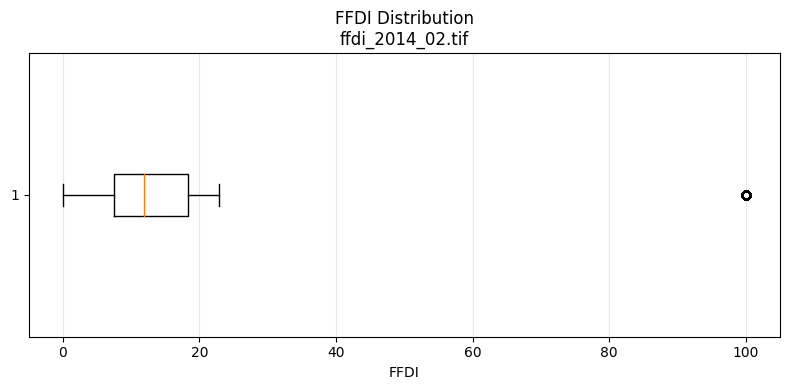

  Top repeated values (rounded):
[(100.0, 448), (6.8, 29), (6.0, 28), (8.0, 28), (5.6, 27), (7.6, 27), (8.2, 27), (7.1, 26), (8.3, 26), (12.2, 26)] 

Processing file: ffdi_2013_09.tif
  Outliers detected: 448
  Bounds: < 2.50 or > 33.50


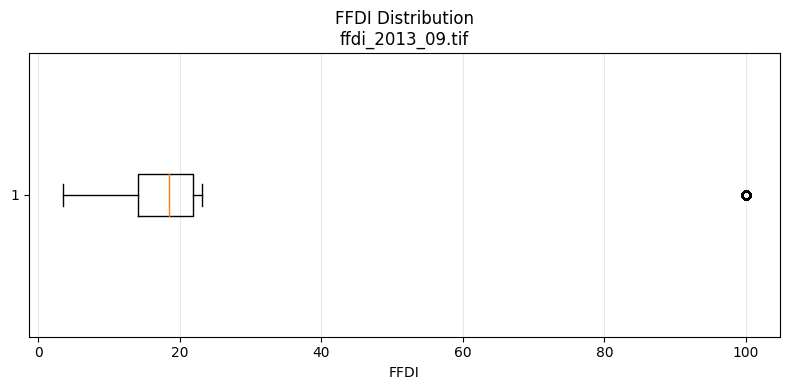

  Top repeated values (rounded):
[(100.0, 448), (19.6, 37), (16.9, 32), (19.8, 29), (19.5, 27), (19.9, 27), (22.2, 27), (22.6, 27), (18.8, 26), (19.1, 26)] 

Processing file: ffdi_2020_06.tif
  Outliers detected: 448
  Bounds: < -2.80 or > 22.80


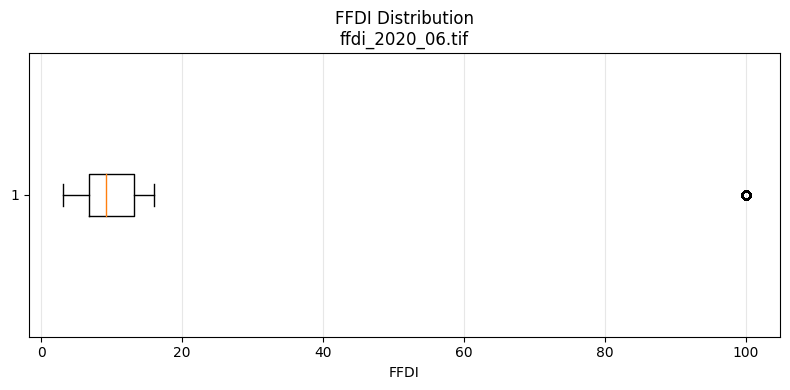

  Top repeated values (rounded):
[(100.0, 448), (5.8, 56), (6.2, 53), (6.0, 47), (6.1, 45), (6.4, 45), (5.7, 43), (5.9, 42), (6.3, 42), (5.6, 37)] 

Processing file: ffdi_2014_05.tif
  Outliers detected: 448
  Bounds: < 0.23 or > 21.63


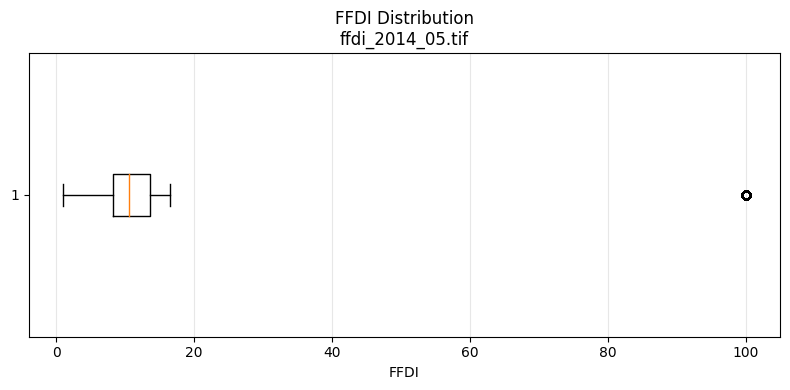

  Top repeated values (rounded):
[(100.0, 448), (7.6, 54), (8.8, 49), (8.9, 47), (9.0, 45), (8.7, 44), (7.7, 43), (11.2, 41), (7.8, 39), (8.3, 39)] 

Processing file: ffdi_2020_01.tif
  Outliers detected: 448
  Bounds: < -12.41 or > 49.95


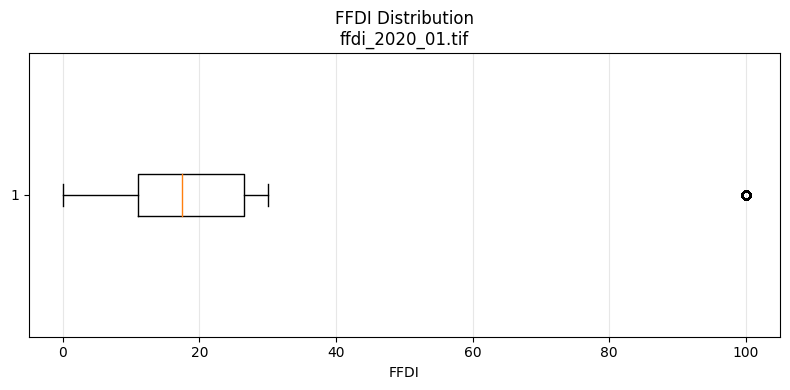

  Top repeated values (rounded):
[(100.0, 448), (8.8, 22), (10.2, 21), (13.2, 21), (8.4, 20), (8.9, 20), (12.1, 20), (10.0, 18), (10.7, 18), (17.3, 18)] 


Files with detected outliers:
  ffdi_2023_01.tif: 448 outliers
  ffdi_2017_05.tif: 448 outliers
  ffdi_2016_10.tif: 448 outliers
  ffdi_2023_06.tif: 448 outliers
  ffdi_2017_02.tif: 448 outliers
  ffdi_2023_08.tif: 449 outliers
  ffdi_2013_04.tif: 448 outliers
  ffdi_2019_06.tif: 448 outliers
  ffdi_2014_08.tif: 448 outliers
  ffdi_2013_03.tif: 448 outliers
  ffdi_2019_01.tif: 448 outliers
  ffdi_2014_06.tif: 448 outliers
  ffdi_2020_02.tif: 448 outliers
  ffdi_2021_10.tif: 453 outliers
  ffdi_2014_01.tif: 448 outliers
  ffdi_2020_05.tif: 448 outliers
  ffdi_2019_08.tif: 448 outliers
  ffdi_2015_02.tif: 448 outliers
  ffdi_2021_06.tif: 448 outliers
  ffdi_2014_10.tif: 448 outliers
  ffdi_2015_05.tif: 448 outliers
  ffdi_2021_01.tif: 448 outliers
  ffdi_2019_10.tif: 459 outliers
  ffdi_2013_12.tif: 448 outliers
  ffdi_2018_02.tif: 44

In [6]:
import os
import glob
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Folder containing FFDI rasters
folder_path = "Outputs/ffdi"

tif_files = glob.glob(os.path.join(folder_path, "**", "*.tif"), recursive=True)
print(f"Found {len(tif_files)} TIFF files.\n")

files_with_outliers = []

for file in tif_files:
    try:
        with rasterio.open(file) as src:
            print(f"Processing file: {os.path.basename(file)}")

            data = src.read(1)
            nodata = src.nodata

            # Mask invalid pixels
            if nodata is not None:
                data = data[data != nodata]

            data = data[~np.isnan(data)]
            data = data[data > 0]  # FFDI must be positive

            if data.size == 0:
                print("  No valid data found.\n")
                continue

            ffdi_series = pd.Series(data.flatten())

            # ---------- IQR Outlier Detection ----------
            Q1 = ffdi_series.quantile(0.25)
            Q3 = ffdi_series.quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = ffdi_series[
                (ffdi_series < lower_bound) | (ffdi_series > upper_bound)
            ]

            if len(outliers) > 0:
                files_with_outliers.append((os.path.basename(file), len(outliers)))

                print(f"  Outliers detected: {len(outliers)}")
                print(f"  Bounds: < {lower_bound:.2f} or > {upper_bound:.2f}")

                # ---------- Boxplot ----------
                plt.figure(figsize=(8, 4))
                plt.boxplot(ffdi_series, vert=False, whis=1.5, showfliers=True)
                plt.title(f"FFDI Distribution\n{os.path.basename(file)}")
                plt.xlabel("FFDI")
                plt.grid(True, axis="x", alpha=0.3)
                plt.tight_layout()
                plt.show()
            else:
                print("  No outliers detected.")

            # ---------- Value frequency (rounded) ----------
            rounded = np.round(data, 1)
            unique, counts = np.unique(rounded, return_counts=True)
            top = sorted(zip(unique, counts), key=lambda x: -x[1])[:10]
            print("  Top repeated values (rounded):")
            print(top, "\n")

    except Exception as e:
        print(f"Error processing {file}: {e}\n")

# ---------- Summary ----------
print("\nFiles with detected outliers:")
for fname, count in files_with_outliers:
    print(f"  {fname}: {count} outliers")

print(f"\nTotal files with outliers: {len(files_with_outliers)}")


## SECTION 4: Spatiotemporal Trend Analysis with KMeans and Mann-Kendall Test


This advanced section clusters spatial pixels by mean FFDI, computes monthly time series per cluster, and then
performs Mann-Kendall trend test with Sen's slope to quantify trends over time.


Found 132 TIFF files
First few dates: [Timestamp('2013-01-01 00:00:00'), Timestamp('2013-02-01 00:00:00'), Timestamp('2013-03-01 00:00:00'), Timestamp('2013-04-01 00:00:00'), Timestamp('2013-05-01 00:00:00')]


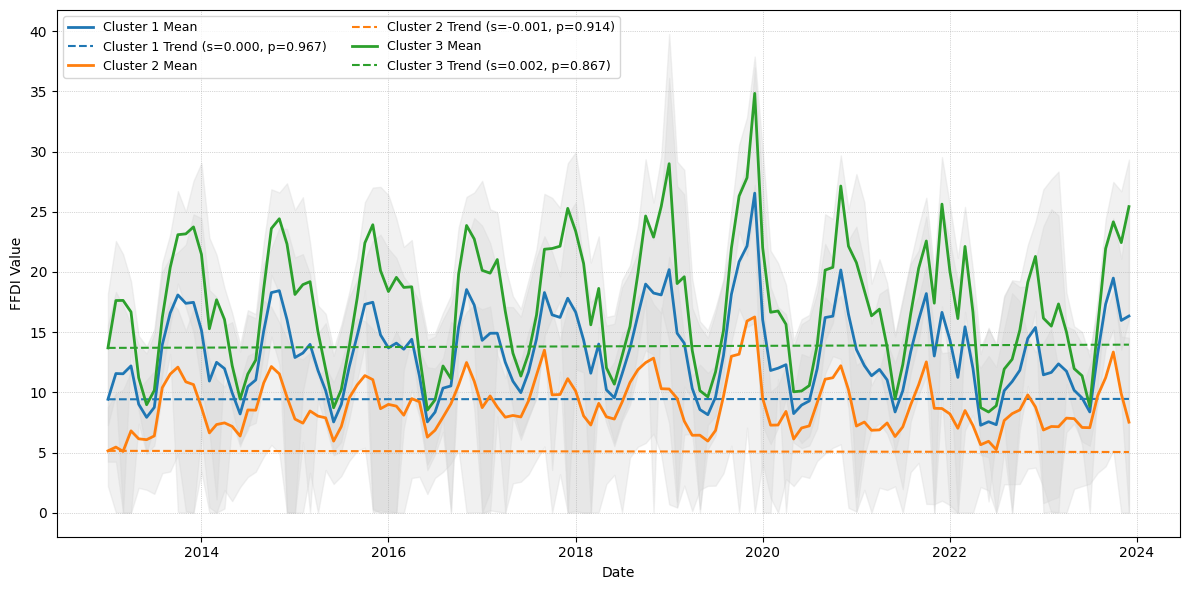

Mann–Kendall Trend Test Results per Cluster:
 Cluster 1: slope = 0.000, p-value = 0.967 (increasing)
 Cluster 2: slope = -0.001, p-value = 0.914 (decreasing)
 Cluster 3: slope = 0.002, p-value = 0.867 (increasing)

✅ Plot saved to: C:/Users/lzein/Documents/Spatial Engineering/Year 1 Q2/DataMastery/ffdi data\ffdi_clusters_trends.png


In [6]:
import os
import glob
import numpy as np
import rasterio
from rasterio.windows import from_bounds
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import pandas as pd
import pymannkendall as mk

# ─── CONFIG ──────────────────────────────────────────────────────────────────
# Define the folder containing your monthly TIFF files
folder_path = 'C:/Users/lzein/Documents/Spatial Engineering/Year 1 Q2/DataMastery/ffdi data'  # Update this if needed

# List all .tif files in the folder
tif_files = glob.glob(                             #changed code from original
    os.path.join(folder_path, "**", "*.tif"),
    recursive=True
)
n_clusters  = 3


# ─── 1) LOAD FILE LIST & DATES ────────────────────────────────────────────────
# Use the recursive glob result
paths = sorted(tif_files) #changed code from original
files = [os.path.basename(p) for p in paths] #changed code from original

# Convert filenames to dates (assuming "ffdi_YYYY_MM.tif")
dates = [pd.to_datetime(f.replace("ffdi_", "").replace(".tif","").replace("_","-") + "-01") #changed code from original
         for f in files]

print(f"Found {len(paths)} TIFF files")
print(f"First few dates: {dates[:5]}")

# ─── 2) REFERENCE METADATA ─────────────────────────────────────────────────────
with rasterio.open(paths[0]) as src0:
    bounds = src0.bounds
    w, h   = src0.width, src0.height
    nodata = src0.nodata

# ─── 3) STACK PIXEL×TIME ─────────────────────────────────────────────────────── new code block, changed to filter out the 0 and 100 values
X = np.empty((w*h, len(paths)), dtype=np.float32)

for i, p in enumerate(paths):
    with rasterio.open(p) as src:
        window = from_bounds(*bounds, transform=src.transform)
        arr = src.read(
            1,
            window=window,
            out_shape=(h, w),
            resampling=rasterio.enums.Resampling.bilinear
        ).astype(np.float32)

        # Mask non-physical FFDI values
        arr[(arr <= 0) | (arr >= 100)] = np.nan

        # Store this month
        X[:, i] = arr.flatten()


# ─── 4) IMPUTE & K-MEANS ON PIXEL MEANS ───────────────────────────────────────
X = SimpleImputer(strategy="mean").fit_transform(X)
pixel_means = X.mean(axis=1).reshape((h, w))
labels = KMeans(n_clusters=n_clusters, random_state=0)\
            .fit_predict(pixel_means.flatten().reshape(-1,1))
cluster_map = labels.reshape((h, w))

# ─── 5) COMPUTE MONTHLY MIN/MEAN/MAX FOR EACH CLUSTER ─────────────────────────
cluster_ts = {}
for k in range(n_clusters):
    mask = (cluster_map == k)
    vals = X[mask.flatten(), :]
    cluster_ts[k] = {
        "min":  np.nanmin(vals, axis=0),
        "mean": np.nanmean(vals, axis=0),
        "max":  np.nanmax(vals, axis=0)
    }

# ─── 6) TREND ANALYSIS: SEN’S SLOPE + MANN–KENDALL ───────────────────────────
trends = {}
mk_results = {}
for k in range(n_clusters):
    series = cluster_ts[k]["mean"]
    sen = mk.sens_slope(series)
    mk_test = mk.original_test(series)
    trends[k] = sen.slope
    mk_results[k] = {
        "slope": sen.slope,
        "p_value": mk_test.p
    }

# ─── 7) PLOT: GREY ENVELOPE + MEANS + TREND LINES ────────────────────────────
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['C0','C1','C2']

# draw grey envelope once
for k in range(n_clusters):
    ax.fill_between(dates,
                    cluster_ts[k]["min"],
                    cluster_ts[k]["max"],
                    color='lightgrey', alpha=0.3)

# plot each cluster
for k in range(n_clusters):
    ts = pd.Series(cluster_ts[k]["mean"], index=dates)
    ax.plot(dates, ts.values,
            color=colors[k], linewidth=2,
            label=f"Cluster {k+1} Mean")
    idx = np.arange(len(dates))
    trend_line = ts.values[0] + trends[k]*idx
    ax.plot(dates, trend_line,
            color=colors[k], linestyle='--', linewidth=1.5,
            label=f"Cluster {k+1} Trend (s={trends[k]:.3f}, p={mk_results[k]['p_value']:.3f})")

# formatting

ax.set_xlabel("Date")
ax.set_ylabel("FFDI Value")
ax.grid(True, linestyle=':', linewidth=0.5)
ax.legend(ncol=2, fontsize=9)

out_png = os.path.join(folder_path, "ffdi_clusters_trends.png") #new code added

plt.tight_layout()
plt.savefig(out_png, dpi=300)
plt.show()

# ─── 8) PRINT MANN–KENDALL RESULTS ────────────────────────────────────────────
print("Mann–Kendall Trend Test Results per Cluster:")
for k in range(n_clusters):
    r = mk_results[k]
    direction = "increasing" if r["slope"]>0 else "decreasing"
    print(f" Cluster {k+1}: slope = {r['slope']:.3f}, p-value = {r['p_value']:.3f} ({direction})")

print(f"\n✅ Plot saved to: {out_png}")

## SECTION 5: Spatial Cluster Map of Temporal FFDI Time Series


Clusters each pixel based on its full time-series FFDI behavior. This visualizes spatial patterns of similar
temporal dynamics in FFDI.


Found 132 TIFF files
Using 120 files from 2013-09-01 to 2023-08-01.
Raster shape: (85, 65).
Number of valid pixels used for clustering: 2311


<Figure size 1000x800 with 0 Axes>

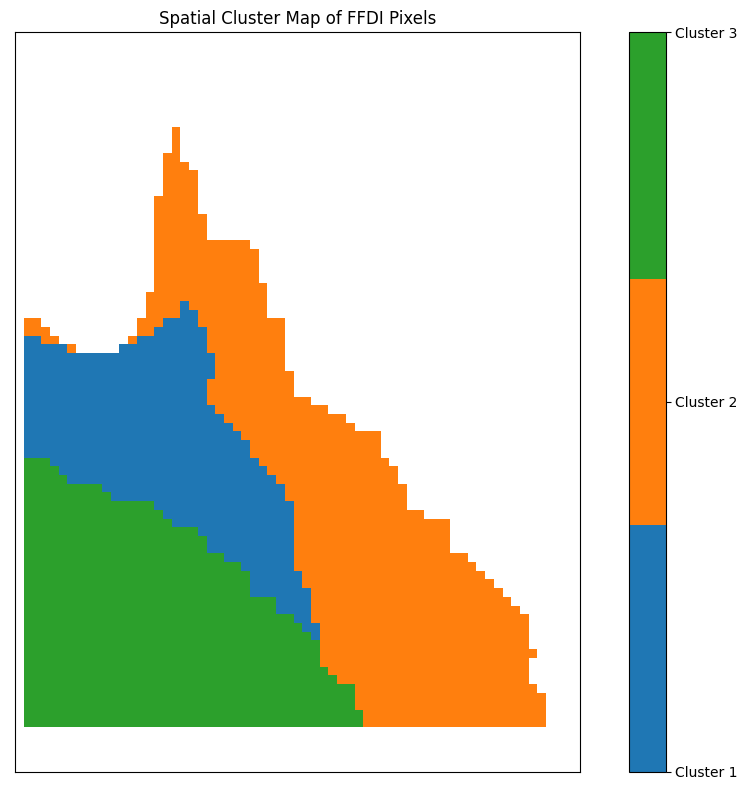

Cluster map saved to: C:/Users/lzein/Documents/Spatial Engineering/Year 1 Q2/DataMastery/ffdi data/ffdi_cluster_map.png


<Figure size 640x480 with 0 Axes>

In [9]:
import os
import glob
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap #new import

# ------------------------------
# Load your FFDI Data (same as before)
# ------------------------------
# Set the input folder containing the GeoTIFF files.
input_folder = 'Outputs/ffdi'  # Update to your folder path

# Get a sorted list of all TIFF files in the folder.
tif_files = sorted(
    glob.glob(os.path.join(input_folder, '**', '*.tif'), recursive=True)  #changed code from original
)
print(f"Found {len(tif_files)} TIFF files")


# Define the desired date range: from September 2013 to August 2023 (monthly).
desired_dates = pd.date_range(start='2013-09-01', end='2023-08-01', freq='MS')
n_desired = len(desired_dates)  # e.g., 120

# Filter the TIFF files to include only those corresponding to the desired period.
if len(tif_files) < n_desired:
    raise ValueError("Not enough TIFF files to cover the desired date range.")
tif_files = tif_files[:n_desired]
n_time = len(tif_files)
print(f"Using {n_time} files from {desired_dates[0].date()} to {desired_dates[-1].date()}.")

# Read the first file to get metadata (dimensions, etc.)
with rasterio.open(tif_files[0]) as src:
    height = src.height
    width = src.width
    profile = src.profile

print(f"Raster shape: ({height}, {width}).")

# Create a data cube to hold the time series data: (n_time, height, width)
data_cube = np.empty((n_time, height, width), dtype=np.float32)
for i, file in enumerate(tif_files):
    with rasterio.open(file) as src:
        arr = src.read(1).astype(np.float32)

        # 🚨 Mask non-physical FFDI values
        arr[(arr <= 0) | (arr >= 100)] = np.nan #new code

        data_cube[i, :, :] = arr


# Reshape the data cube so that each pixel's time series is a row.
n_pixels = height * width
pixel_timeseries_full = data_cube.reshape((n_time, n_pixels)).T  # Shape: (n_pixels, n_time)

# Create a mask for invalid (NaN) pixels.
invalid_mask = np.any(np.isnan(pixel_timeseries_full), axis=1)
valid_idx = ~invalid_mask  # Boolean index array for valid pixels

# Select only valid pixels for clustering.
pixel_timeseries = pixel_timeseries_full[valid_idx]

print(f"Number of valid pixels used for clustering: {pixel_timeseries.shape[0]}")

# ------------------------------
# K-Means Clustering on the Temporal Data
# ------------------------------
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# Perform clustering on each valid pixel’s time series.
# The features are the temporal FFDI values.
cluster_labels_valid = kmeans.fit_predict(pixel_timeseries) + 1  # Shift labels to 1,2,3

# Create a full cluster map of size (n_pixels,) with NaN for invalid pixels.
cluster_map_flat = np.full((n_pixels,), np.nan)
# Fill in the valid pixel locations with cluster labels.
cluster_map_flat[valid_idx] = cluster_labels_valid
# Reshape back to the raster shape.
cluster_map = cluster_map_flat.reshape((height, width))

#new code to match the colours of the cluster with the later line graphs
cluster_colors = {
    1: 'C0',  # Cluster 1 – blue
    2: 'C1',  # Cluster 2 – orange
    3: 'C2'   # Cluster 3 – green
}

# ------------------------------
# Plot the Spatial Cluster Map (without x and y axis numbers)
# ------------------------------
plt.figure(figsize=(10, 8))


# New code block to Build a ListedColormap in cluster order
cmap = ListedColormap([cluster_colors[i] for i in range(1, n_clusters + 1)])

plt.figure(figsize=(10, 8))
img = plt.imshow(cluster_map, cmap=cmap, vmin=1, vmax=n_clusters)

plt.title('Spatial Cluster Map of FFDI Pixels')

# Colorbar with correct labels
cbar = plt.colorbar(img, ticks=[1, 2, 3])
cbar.ax.set_yticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3'])

plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

plt.tight_layout()

# Save the cluster map as an image if desired. Original code
output_cluster_map = r'C:/Users/lzein/Documents/Spatial Engineering/Year 1 Q2/DataMastery/ffdi data/ffdi_cluster_map.png'    
os.makedirs(os.path.dirname(output_cluster_map), exist_ok=True)
plt.savefig(output_cluster_map, dpi=300)
print(f"Cluster map saved to: {output_cluster_map}")



## SECTION 6: Pixelwise Mann–Kendall Trend Mapping


Conducts Mann–Kendall trend test per pixel and saves a GeoTIFF indicating where significant upward or downward
trends occur.


In [11]:
!pip install pymannkendall


Defaulting to user installation because normal site-packages is not writeable
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1283, in render
    renderable = rich_cast(renderable)
  File 

✅ Trend map saved to: Outputs/ffdi_mk_trend_map1123.tif


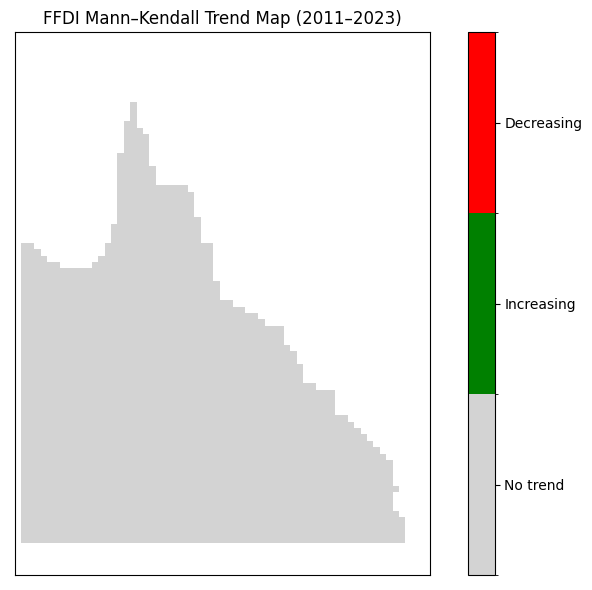

In [12]:
import os
import glob
import re
import numpy as np
import pandas as pd
import rasterio
from rasterio.windows import from_bounds
from pymannkendall import original_test  # Mann–Kendall test

# --- Configuration ---
folder_path   = r'Outputs/ffdi'
output_trend  = r'Outputs/ffdi_mk_trend_map1123.tif'
date_pattern  = re.compile(r'(\d{4}-\d{2})')  # YYYY-MM in filename
NODATA_CODE   = 255                          # code for truly missing pixels

def extract_date(fp):
    m = date_pattern.search(os.path.basename(fp))
    return pd.to_datetime(m.group(1) + "-01") if m else pd.NaT

# --- Gather and sort rasters ---
tifs = sorted(         #changed code
    glob.glob(os.path.join(folder_path, "**", "*.tif"), recursive=True),
    key=extract_date
)

if not tifs:
    raise RuntimeError("No TIFFs found")

# --- Read reference metadata ---
with rasterio.open(tifs[0]) as src0:
    meta    = src0.meta.copy()
    bounds  = src0.bounds
    height  = src0.height
    width   = src0.width

# --- Stack into (time, row, col) array ---
stack = np.empty((len(tifs), height, width), dtype=np.float32)
for i, fp in enumerate(tifs):
    with rasterio.open(fp) as src:
        window = from_bounds(*bounds, transform=src.transform)
        arr = src.read(
            1,
            window=window,
            out_shape=(height, width),
            resampling=rasterio.enums.Resampling.bilinear
        )
        # 🚨 Mask non-physical FFDI values
        arr[(arr <= 0) | (arr >= 100)] = np.nan #new code

    stack[i] = arr

# --- Prepare trend_map with codes:
#    0 = no trend (p>=0.05)
#    1 = upward trend (p<0.05)
#    2 = downward trend (p<0.05)
trend_map = np.zeros((height, width), dtype=np.uint8)

# --- Mask of pixels with at least one valid observation ---
valid_mask = ~np.all(np.isnan(stack), axis=0)

# --- Per-pixel Mann–Kendall test ---
for i in range(height):
    for j in range(width):
        if not valid_mask[i, j]:
            continue
        ts = stack[:, i, j]
        if np.isnan(ts).any():
            continue
        res = original_test(ts)
        if res.p < 0.05:
            trend_map[i, j] = 1 if res.trend == "increasing" else 2

# --- Apply nodata code for pixels that never had data ---
trend_map_out = trend_map.copy()
trend_map_out[~valid_mask] = NODATA_CODE

# --- Write out as GeoTIFF with nodata=255 ---
meta.update({
    "driver":   "GTiff",
    "dtype":    rasterio.uint8,
    "count":    1,
    "nodata":   NODATA_CODE,
    "compress": "lzw"
})
os.makedirs(os.path.dirname(output_trend), exist_ok=True)
with rasterio.open(output_trend, "w", **meta) as dst:
    dst.write(trend_map_out, 1)

print(f"✅ Trend map saved to: {output_trend}")
# Codes: 0 = no trend, 1 = upward, 2 = downward, 255 = nodata



#added code to show output in terminal
# --- DISPLAY THE OUTPUT TREND MAP ---
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

with rasterio.open(output_trend) as src:
    trend_img = src.read(1)

# Mask nodata for plotting
trend_img = np.ma.masked_equal(trend_img, NODATA_CODE)

# Define discrete colormap
cmap = ListedColormap(["lightgrey", "green", "red"])
bounds = [-0.5, 0.5, 1.5, 2.5]
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(8, 6))
im = plt.imshow(trend_img, cmap=cmap, norm=norm)
plt.title("FFDI Mann–Kendall Trend Map (2011–2023)")

# Colorbar with labels
cbar = plt.colorbar(im, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(["No trend", "Increasing", "Decreasing"])

# Clean map appearance
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()


## SECTION 7: Harmonic Seasonal Decomposition of FFDI


Fits a seasonal harmonic model to 90th percentile FFDI values over time. Reveals dominant seasonal cycles
with amplitude and phase estimates.


Folder exists? True
Found 132 TIFFs
Outputs/ffdi/ffdi_2013_01.tif
Outputs/ffdi/ffdi_2013_02.tif
Outputs/ffdi/ffdi_2013_03.tif
Outputs/ffdi/ffdi_2013_04.tif
Outputs/ffdi/ffdi_2013_05.tif
Outputs/ffdi/ffdi_2013_06.tif
Outputs/ffdi/ffdi_2013_07.tif
Outputs/ffdi/ffdi_2013_08.tif
Outputs/ffdi/ffdi_2013_09.tif
Outputs/ffdi/ffdi_2013_10.tif
Unique months in dates: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
First 10 dates: [Timestamp('2013-01-01 00:00:00'), Timestamp('2013-02-01 00:00:00'), Timestamp('2013-03-01 00:00:00'), Timestamp('2013-04-01 00:00:00'), Timestamp('2013-05-01 00:00:00'), Timestamp('2013-06-01 00:00:00'), Timestamp('2013-07-01 00:00:00'), Timestamp('2013-08-01 00:00:00'), Timestamp('2013-09-01 00:00:00'), Timestamp('2013-10-01 00:00:00')]
Fire year anchored to September: 2013-09
Harmonic regression results:
 a₀ (mean) = 19.79
 k=1: amplitude = 6.45, phase = -87.7°
 k=2: amplitude = 0.99, phase = -14.6°

🔥 Peak months based on harmonic fit:
 → 2013-12 (FFDI ≈ 25.28)
 → 2014-12 (

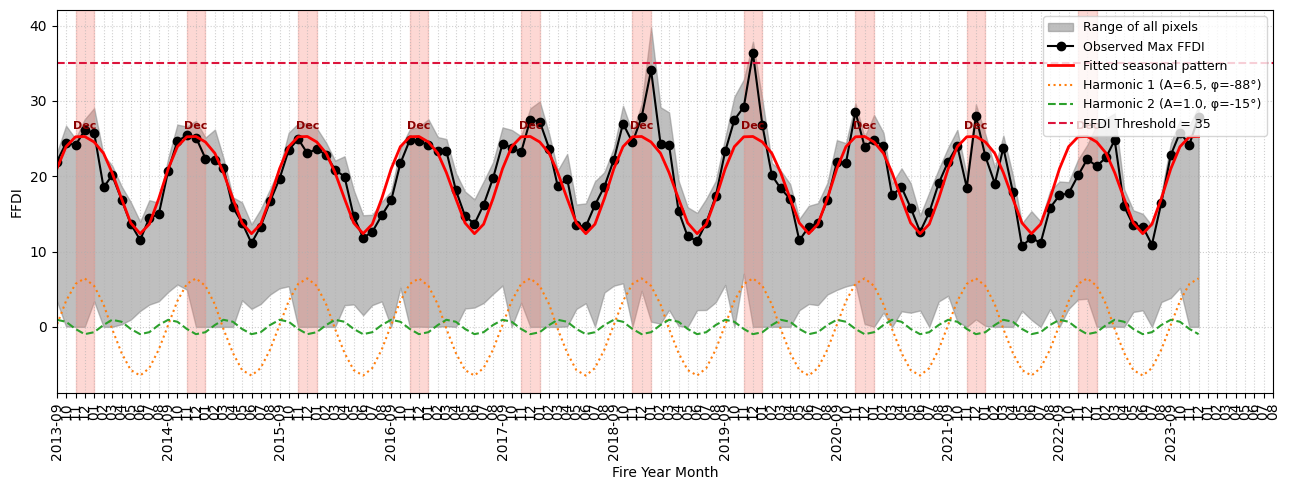


✅ Seasonal plot saved to: Outputs/ffdi_seasonal_plot.png


In [15]:
import os
import glob
import re
import numpy as np
import pandas as pd
import rasterio
from rasterio.windows import from_bounds
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.signal import find_peaks

# ─── CONFIG ───────────────────────────────────────────────────────────────
folder        = 'Outputs/ffdi'
out_png       = r"Outputs/ffdi_seasonal_plot.png"
date_pattern  = re.compile(r"ffdi_(\d{4})_(\d{2})")
fire_year_T   = 12    # months in a fire-year cycle
n_harmonics   = 2     # number of harmonics to fit

# ─── FUNCTION TO EXTRACT DATE FROM FILENAME ────────────────────────────────
def extract_date(fp):
    m = date_pattern.search(os.path.basename(fp))
    if m:
        year, month = int(m.group(1)), int(m.group(2))
        return pd.Timestamp(year=year, month=month, day=1)
    else:
        return pd.NaT

# ─── 1) LOAD & SORT TIFFs ─────────────────────────────────────────────────
files = sorted(
    glob.glob(os.path.join(folder, "**", "*.tif"), recursive=True),
    key=extract_date
)
dates = [extract_date(f) for f in files]
if not files:
    raise RuntimeError("No TIFFs found")

print("Folder exists?", os.path.exists(folder))
print(f"Found {len(files)} TIFFs")
for f in files[:10]:
    print(f)

# ─── 2) READ METADATA FROM FIRST TIFF ────────────────────────────────────
with rasterio.open(files[0]) as src0:
    bounds = src0.bounds
    h, w   = src0.height, src0.width

# ─── 3) STACK INTO (time, row, col) WITH MASKING ────────────────────────
stack = np.empty((len(files), h, w), dtype=np.float32)
for i, fp in enumerate(files):
    with rasterio.open(fp) as src:
        window = from_bounds(*bounds, transform=src.transform)
        arr = src.read(
            1, window=window,
            out_shape=(h, w),
            resampling=rasterio.enums.Resampling.bilinear
        ).astype(np.float32)
        arr[(arr <= 0) | (arr >= 100)] = np.nan  # mask invalid FFDI
        stack[i] = arr

# ─── 4) COMPUTE P90 + ENVELOPE ──────────────────────────────────────────
p90  = np.nanpercentile(stack, 90, axis=(1,2))
minv = np.nanmin(stack, axis=(1,2))
maxv = np.nanmax(stack, axis=(1,2))

print("Unique months in dates:", sorted({d.month for d in dates if pd.notna(d)}))
print("First 10 dates:", dates[:10])

# ─── 5) FIRE-YEAR INDEX t (ROBUST) ──────────────────────────────────────
septembers = [d for d in dates if pd.notna(d) and d.month == 9]

if septembers:
    first_fire_month = min(septembers)
    fire_start_month = 9
    print(f"Fire year anchored to September: {first_fire_month.strftime('%Y-%m')}")
else:
    first_fire_month = min(d for d in dates if pd.notna(d))
    fire_start_month = first_fire_month.month
    print(
        "⚠️ September not found — fire year anchored to first available month:",
        first_fire_month.strftime("%Y-%m")
    )

t = np.array([
    (d.year - first_fire_month.year) * 12 + (d.month - fire_start_month)
    for d in dates
], dtype=float)

# ─── 6) HARMONIC MODEL & RESIDUALS ──────────────────────────────────────
def harmonic_model(coefs, t, T, n):
    y = np.full_like(t, coefs[0], dtype=float)
    for k in range(1, n+1):
        ak = coefs[2*k-1]
        bk = coefs[2*k]
        y += ak * np.cos(2*np.pi*k*t/T) + bk * np.sin(2*np.pi*k*t/T)
    return y

def residuals(coefs, t, T, n, obs):
    return harmonic_model(coefs, t, T, n) - obs

# ─── 7) FIT VIA LEAST-SQUARES ───────────────────────────────────────────
init = np.zeros(1 + 2*n_harmonics)
init[0] = np.nanmean(p90)
res = least_squares(residuals, init, args=(t, fire_year_T, n_harmonics, p90))
coef = res.x

# ─── 8) EXTRACT AMPLITUDE & PHASE ───────────────────────────────────────
mag, phase = {}, {}
for k in range(1, n_harmonics+1):
    ak = coef[2*k-1]
    bk = coef[2*k]
    mag[k]   = np.hypot(ak, bk)
    phase[k] = np.degrees(np.arctan2(-bk, ak))

print("Harmonic regression results:")
print(f" a₀ (mean) = {coef[0]:.2f}")
for k in range(1, n_harmonics+1):
    print(f" k={k}: amplitude = {mag[k]:.2f}, phase = {phase[k]:.1f}°")

# ─── 9) COMPUTE SERIES ───────────────────────────────────────────────────
fitted = harmonic_model(coef, t, fire_year_T, n_harmonics)
components = {}
for k in range(1, n_harmonics+1):
    comp_coefs = np.zeros_like(coef)
    comp_coefs[2*k-1] = coef[2*k-1]
    comp_coefs[2*k]   = coef[2*k]
    comp_coefs[0]     = 0
    components[k] = harmonic_model(comp_coefs, t, fire_year_T, n_harmonics)

# ─── 10) PLOT & SAVE ─────────────────────────────────────────────────────
plt.figure(figsize=(13, 5))
plt.fill_between(dates, minv, maxv, color='grey', alpha=0.5, label="Range of all pixels")
plt.plot(dates, p90, 'k-o', label="Observed Max FFDI")
plt.plot(dates, fitted, 'r-', linewidth=2, label="Fitted seasonal pattern")

linestyles = {1: ':', 2: '--'}
for k, comp in components.items():
    plt.plot(dates, comp, color=f'C{k}', linestyle=linestyles[k],
             label=f"Harmonic {k} (A={mag[k]:.1f}, φ={phase[k]:.0f}°)")

plt.axhline(y=35, color='crimson', linestyle='--', linewidth=1.5, label='FFDI Threshold = 35')

peak_idxs, _ = find_peaks(fitted, distance=2)
print("\n🔥 Peak months based on harmonic fit:")
for idx in peak_idxs:
    peak_date = dates[idx]
    print(f" → {peak_date.strftime('%Y-%m')} (FFDI ≈ {fitted[idx]:.2f})")
    start = peak_date - pd.DateOffset(months=1)
    end   = peak_date + pd.DateOffset(months=1)
    plt.axvspan(start, end, color='salmon', alpha=0.3)
    plt.text(peak_date, fitted[idx] + 1, peak_date.strftime('%b'),
             color='darkred', ha='center', fontsize=8, fontweight='bold')

# Fire-year date labels
fire_year_dates = pd.date_range(start=first_fire_month, periods=len(dates), freq='MS')
month_fmt = [d.strftime("%Y-%m") if d.month == 9 else d.strftime("%m") for d in fire_year_dates]
plt.xticks(fire_year_dates, month_fmt, rotation=90)
plt.xlim(fire_year_dates[0], fire_year_dates[-1])

plt.xlabel("Fire Year Month")
plt.ylabel("FFDI")
plt.grid(linestyle=':', alpha=0.6)
plt.legend(ncol=1, fontsize=9)
plt.tight_layout()

os.makedirs(os.path.dirname(out_png), exist_ok=True)
plt.savefig(out_png, dpi=300)
plt.show()
print(f"\n✅ Seasonal plot saved to: {out_png}")


## SECTION 8: December–January–February Block Analysis by Cluster


Focuses on the core fire season (Dec–Feb), aggregates FFDI over 3-month blocks, and checks for cluster-wise
seasonal trends.


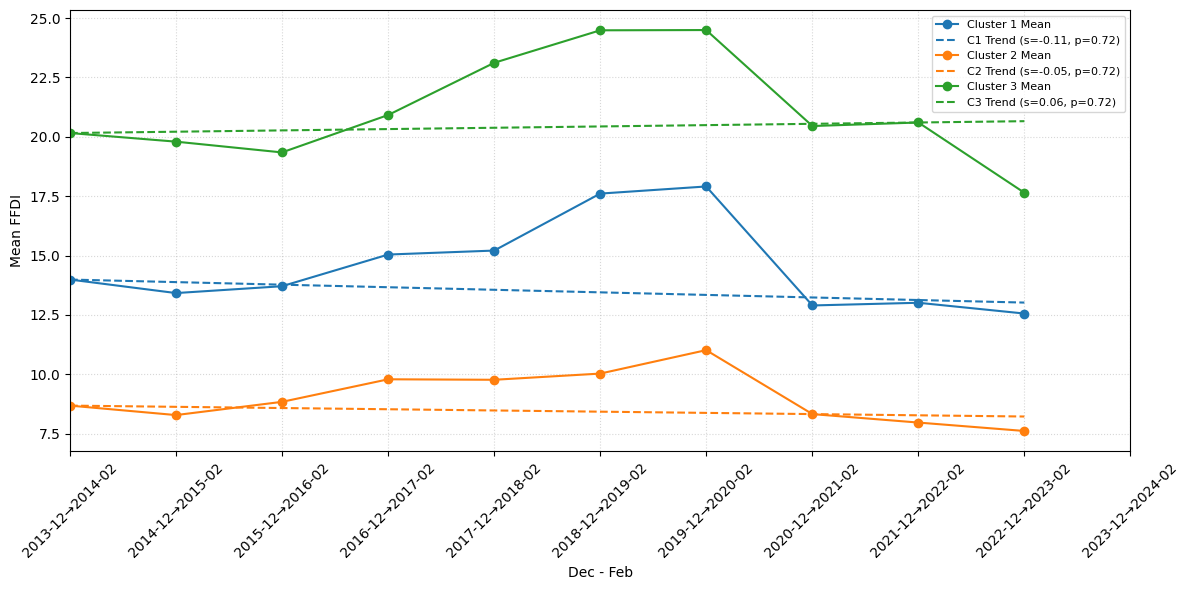

Trend analysis results:
 Cluster 1: trend=no trend, p=0.721, slope=-0.1078
 Cluster 2: trend=no trend, p=0.721, slope=-0.0510
 Cluster 3: trend=no trend, p=0.721, slope=0.0554

✅ Plot saved to: Outputs/ffdi


In [16]:
import os
import glob
import re
import numpy as np
import pandas as pd
import rasterio
from rasterio.windows import from_bounds
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from pymannkendall import original_test, sens_slope

# ─── CONFIG ──────────────────────────────────────────────────────────────────  all changed from original code
ffdi_folder  = 'Outputs/ffdi'
n_clusters   = 3
start_year   = 2013
end_year     = 2023    # last block = 2022-12→2023-02
out_png      = 'Outputs/ffdi'
date_pat     = re.compile(r'(\d{4}_\d{2})')

def extract_date(fp):
    m = date_pat.search(os.path.basename(fp))
    if m:
        # replace "_" with "-" to form "YYYY-MM"
        date_str = m.group(1).replace("_", "-") + "-01"
        return pd.to_datetime(date_str)
    else:
        return pd.NaT

# 1) Load & sort monthly TIFFs, original code resumes from here
files = sorted(
    glob.glob(os.path.join(ffdi_folder, "**", "*.tif*"), recursive=True),
    key=extract_date
)
dates = [extract_date(f) for f in files]
if not files:
    raise RuntimeError("No TIFFs found")

# 2) Read metadata & stack
with rasterio.open(files[0]) as src0:
    bounds = src0.bounds
    h, w   = src0.height, src0.width

stack = np.empty((len(files), h, w), dtype=np.float32)
for i, fp in enumerate(files):
    with rasterio.open(fp) as src:
        win = from_bounds(*bounds, transform=src.transform)
        stack[i] = src.read(
            1, window=win,
            out_shape=(h, w),
            resampling=rasterio.enums.Resampling.bilinear
        )
        stack[(stack <= 0) | (stack >= 100)] = np.nan #new code

# 3) Cluster by long‐term mean
pix = stack.reshape(len(files), -1).T
pix = SimpleImputer(strategy="mean").fit_transform(pix)
pix_mean   = pix.mean(axis=1).reshape(h, w)
labels     = KMeans(n_clusters=n_clusters, random_state=0)\
                 .fit_predict(pix_mean.flatten().reshape(-1,1))
cluster_map = labels.reshape(h, w)

# 4) Aggregate Dec→Feb blocks (3 months)
records = []
for k in range(n_clusters):
    mask = (cluster_map == k)
    for yr in range(start_year, end_year+1):
        block_dates = [
            pd.Timestamp(f"{yr}-12-01"),
            pd.Timestamp(f"{yr+1}-01-01"),
            pd.Timestamp(f"{yr+1}-02-01"),
        ]
        # need all three months present
        if not all(d in dates for d in block_dates):
            continue
        idxs = [i for i,d in enumerate(dates) if d in block_dates]
        vals = stack[idxs][:, mask]
        records.append({
            "cluster":   k+1,
            "plot_date": block_dates[0],           # December of each block
            "label":     f"{yr}-12→{yr+1}-02",
            "mean_ffdi": np.nanmean(vals)
        })

df = pd.DataFrame(records)
df.sort_values(["plot_date","cluster"], inplace=True)

# 5) Pivot so clusters are columns
pivot = df.pivot(index="plot_date", columns="cluster", values="mean_ffdi")

# 6) Reindex to ensure full series 2013–2022 Dec starts
full_index = pd.date_range(
    start=f"{start_year}-12-01",
    periods=(end_year-start_year+1),
    freq=pd.DateOffset(years=1)
)
pivot = pivot.reindex(full_index)

# 7) Plot with trends
plt.figure(figsize=(12,6))
colors = {1:"C0", 2:"C1", 3:"C2"}
trend_info = {}

for cl in pivot.columns:
    ts = pivot[cl]
    y  = ts.values
    # drop NaN for trend calc
    notnan = ~np.isnan(y)
    y_nn = y[notnan]
    x_nn = np.arange(len(y_nn))

    mk = original_test(y_nn)
    ss = sens_slope(y_nn)
    trend_info[cl] = (mk.trend, mk.p, ss.slope)

    # series
    plt.plot(ts.index, y,
             color=colors[cl], marker='o', linestyle='-',
             label=f"Cluster {cl} Mean")
    # trend line
    plt.plot(ts.index[notnan], y_nn[0] + ss.slope*x_nn,
             color=colors[cl], linestyle='--',
             label=f"C{cl} Trend (s={ss.slope:.2f}, p={mk.p:.2f})")

# X-axis ticks at each block
xticks  = full_index
xlabels = [f"{d.year}-12→{d.year+1}-02" for d in full_index]
plt.xticks(xticks, xlabels, rotation=45)
plt.xlim(xticks[0], xticks[-1])

plt.xlabel("Dec - Feb")
plt.ylabel("Mean FFDI")
plt.grid(linestyle=':', alpha=0.5)
plt.legend(fontsize=8, ncol=1)
plt.tight_layout()

os.makedirs(os.path.dirname(out_png), exist_ok=True)
plt.savefig(out_png, dpi=300)
plt.show()

# 8) Summary
print("Trend analysis results:")
for cl, (trend, p, slope) in trend_info.items():
    print(f" Cluster {cl}: trend={trend}, p={p:.3f}, slope={slope:.4f}")
print(f"\n✅ Plot saved to: {out_png}")

## SECTION 9: High- Risk Area Calculation


In [17]:
import os
import math
import rasterio
import numpy as np
import pandas as pd
from glob import glob

# --- CONFIG ---
ffdi_folder = "Outputs/ffdi"
ffdi_threshold = 12
output_csv = os.path.join('Outputs/', "high_risk_area_by_year.csv")

# --- FUNCTION TO CONVERT DEGREE PIXEL SIZE TO KM² (based on NSW latitude) ---
def degrees_to_km2(pixel_width_deg, pixel_height_deg, lat=-33.5):
    """
    Estimate km² per pixel for given latitude (defaults to NSW ~ -33.5°)
    """
    km_per_deg_lat = 111.32
    km_per_deg_lon = 111.32 * math.cos(math.radians(lat))
    return (pixel_width_deg * km_per_deg_lon) * (pixel_height_deg * km_per_deg_lat)

# --- EXTRACT YEAR FROM FILENAME ---
def year_from_filename(fname):
    base = os.path.basename(fname)
    return base.split("_")[1][:4]

# --- MAIN ---
files = sorted(
    glob(os.path.join(ffdi_folder, "**", "ffdi_*.tif"), recursive=True)) #code changed
yearly_files = {}
for f in files:
    year = year_from_filename(f)
    yearly_files.setdefault(year, []).append(f)

results = []

for year, rasters in yearly_files.items():
    high_risk_mask = None
    total_pixels = None
    pixel_width = None
    pixel_height = None

    for raster_path in rasters:
        with rasterio.open(raster_path) as src:
            data = src.read(1)
            mask = (data > ffdi_threshold)

            if high_risk_mask is None:
                high_risk_mask = mask
                total_pixels = np.isfinite(data).sum()
                transform = src.transform
                pixel_width = transform[0]
                pixel_height = abs(transform[4])
            else:
                high_risk_mask |= mask  # Logical OR across months

    high_risk_pixel_count = np.sum(high_risk_mask)

    # Estimate area in km² based on NSW latitude
    pixel_area_km2 = degrees_to_km2(pixel_width, pixel_height, lat=-33.5)
    area_km2 = high_risk_pixel_count * pixel_area_km2

    results.append({
        "Year": int(year),
        "HighRiskPixels": int(high_risk_pixel_count),
        "TotalPixels": int(total_pixels),
        "HighRiskArea_km2": round(area_km2, 2)
    })

print("Results length:", len(results))
print("First row:", results[0])

# --- EXPORT ---
df = pd.DataFrame(results).sort_values("Year")
df.to_csv(output_csv, index=False)

# --- PRINT ---
print("\nHigh-Risk Area Summary by Year (NSW, km²-based):\n")
print(df.to_string(index=False))


Results length: 11
First row: {'Year': 2013, 'HighRiskPixels': 2442, 'TotalPixels': 5525, 'HighRiskArea_km2': 1577170.56}

High-Risk Area Summary by Year (NSW, km²-based):

 Year  HighRiskPixels  TotalPixels  HighRiskArea_km2
 2013            2442         5525        1577170.56
 2014            2433         5525        1571357.89
 2015            2358         5525        1522918.99
 2016            2465         5525        1592025.16
 2017            2556         5525        1650797.69
 2018            2502         5525        1615921.68
 2019            2619         5525        1691486.36
 2020            2438         5525        1574587.15
 2021            2433         5525        1571357.89
 2022            2260         5525        1459625.50
 2023            2511         5525        1621734.35


## SECTION 10: Year-wise Line Plot of Total High-Risk Area


Uses a CSV file containing yearly summaries of high fire danger area to plot interannual variation in total
area under fire risk.


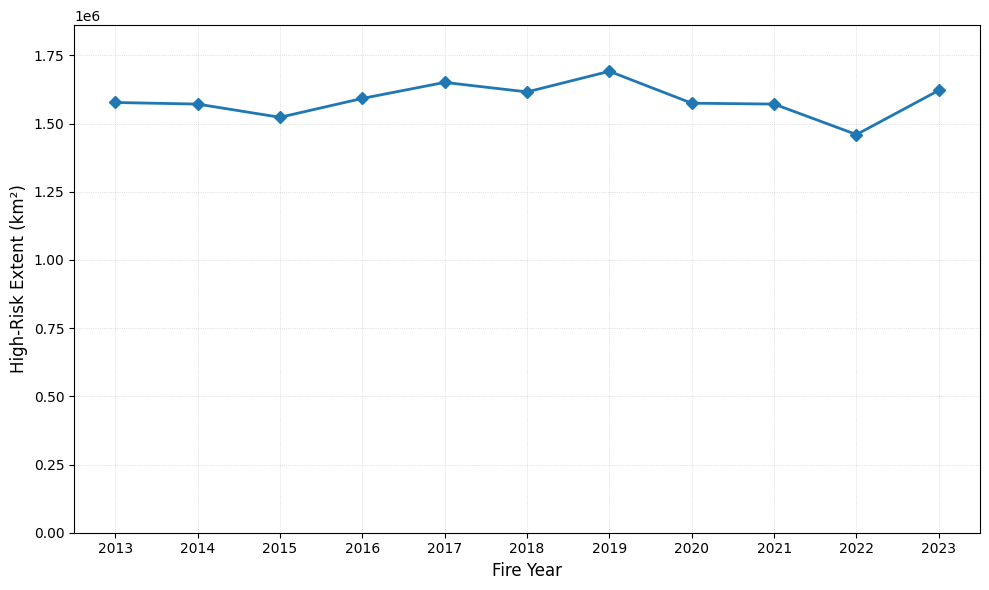

✅ Line chart saved to: C:/Users/lzein/Documents/Spatial Engineering/Year 1 Q2/DataMastery/line_fireyear_highrisk_area1.png


In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# ─── UPDATE TO YOUR CSV PATH ─────────────────────────────────────────────────
highrisk_csv = "Outputs/high_risk_area_by_year.csv"

if not os.path.exists(highrisk_csv):
    raise FileNotFoundError(f"CSV not found: {highrisk_csv}")

# ─── LOAD DATA ───────────────────────────────────────────────────────────────
df = pd.read_csv(highrisk_csv)

# Extract the fire‐year start as an integer (e.g., "2013-09→2014-08" → 2013)
#df["start_year"] = df["fire_year"].str.slice(0,4).astype(int)    this line gave an error

# ─── PLOT LINE CHART ─────────────────────────────────────────────────────────
plt.figure(figsize=(10, 6))
plt.plot(df["Year"], df["HighRiskArea_km2"], marker="D", linestyle="-", color="C0", linewidth=2) #changed fireyear to year, and areakm2 to highriskarea_km2


plt.xlabel("Fire Year", fontsize=12)
plt.ylabel("High-Risk Extent (km²)", fontsize=12)
plt.xticks(df["Year"], rotation=0)
plt.ylim(0, df["HighRiskArea_km2"].max() * 1.1)
plt.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)
plt.tight_layout()

# ─── SAVE & SHOW ────────────────────────────────────────────────────────────
output_line = "C:/Users/lzein/Documents/Spatial Engineering/Year 1 Q2/DataMastery/line_fireyear_highrisk_area1.png"
os.makedirs(os.path.dirname(output_line), exist_ok=True)
plt.savefig(output_line, dpi=300)
plt.show()

print(f"✅ Line chart saved to: {output_line}")

## SECTION 11: Multi-Map Visualization of FFDI Trends (DJF and Full Series)


This section creates a six-panel visualization summarizing trend direction, slope, and significance (p-value)
for both the full series and the December–January–February (DJF) season. Each map shows spatial patterns
helpful for understanding fire danger trends over time.

The panels include:
- Trend direction: increasing, decreasing, or no trend
- Sen's slope (rate of change)
- p-value (significance)

A scale bar and north arrow are included for spatial context.


In [21]:
!pip install matplotlib_scalebar

Defaulting to user installation because normal site-packages is not writeable
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1283, in render
    renderable = rich_cast(renderable)
  File 

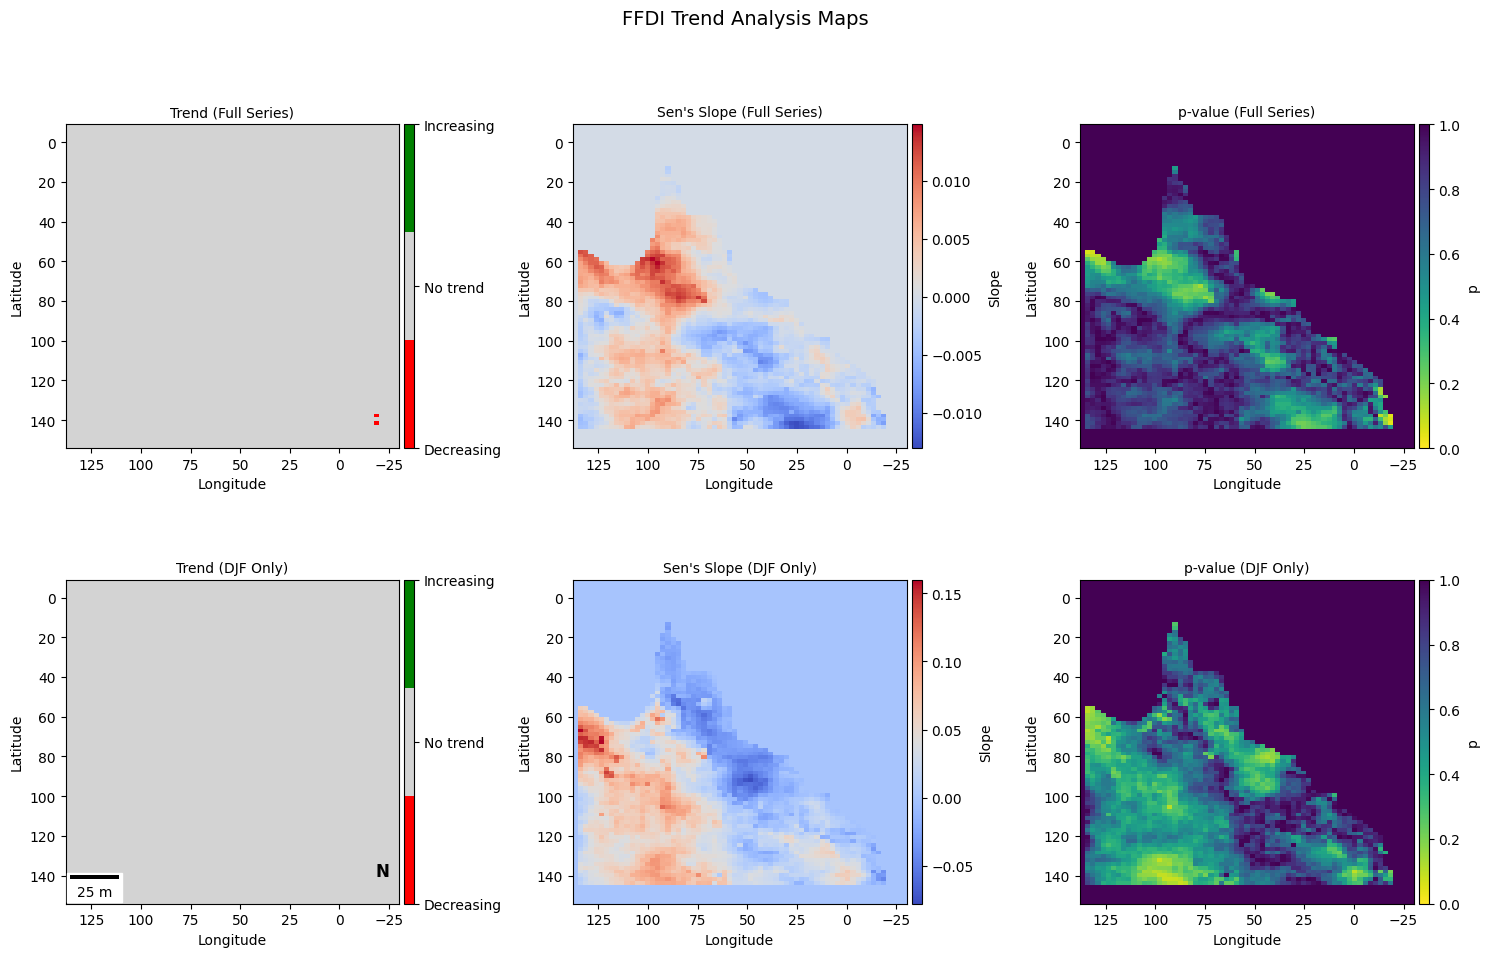


✅ 6-map summary image saved to: Outputs/ffdi_trend_maps.png


In [22]:
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.windows import from_bounds
from matplotlib.colors import ListedColormap
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pymannkendall import original_test, sens_slope

# ─── CONFIG ───────────────────────────────────────────────────────────────────
input_folder   = "Outputs/ffdi"
pattern        = re.compile(r"ffdi_(\d{4}_\d{2})")
nodata_val     = -9999
out_image      = "Outputs/ffdi_trend_maps.png"

# ─── FUNCTION TO EXTRACT DATE FROM FILENAME ───────────────────────────────────
def extract_date(path):
    m = pattern.search(os.path.basename(path))
    if not m:
        return pd.NaT

    year_month = m.group(1).replace("_", "-")  # 2013_01 → 2013-01
    return pd.to_datetime(f"{year_month}-01")

# ─── LOAD FILES ───────────────────────────────────────────────────────────────
tif_files = sorted(
    glob.glob(os.path.join(input_folder, "**", "*.tif*"), recursive=True),
    key=extract_date
)
dates     = [extract_date(f) for f in tif_files]
if not tif_files:
    raise RuntimeError("No FFDI TIFF files found")

# ─── READ REFERENCE ───────────────────────────────────────────────────────────
with rasterio.open(tif_files[0]) as src0:
    height, width = src0.height, src0.width
    transform     = src0.transform
    crs           = src0.crs
    bounds        = src0.bounds

# ─── STACK FFDI ────────────────────────────────────────────────────────────────
full_stack  = np.empty((len(tif_files), height, width), dtype=np.float32)
for i, f in enumerate(tif_files):
    with rasterio.open(f) as src:
        win = from_bounds(*bounds, transform=src.transform)
        full_stack[i] = src.read(1, window=win, out_shape=(height, width))

full_dates = np.array(dates)

# ─── CREATE SEASONAL (DJF) STACK ──────────────────────────────────────────────
is_djf = [(d.month in [12, 1, 2]) for d in full_dates]
djf_stack = full_stack[is_djf]
djf_dates = full_dates[is_djf]

# ─── STATISTICAL ANALYSIS FUNCTION ────────────────────────────────────────────
def compute_stats(stack, dates):
    trend_map  = np.full((height, width), 0, dtype=np.int8)     # -1, 0, 1
    slope_map  = np.full((height, width), np.nan, dtype=np.float32)
    pval_map   = np.full((height, width), np.nan, dtype=np.float32)
    valid_mask = ~np.all(np.isnan(stack), axis=0)

    for i in range(height):
        for j in range(width):
            if not valid_mask[i, j]:
                continue
            ts = stack[:, i, j]
            if np.isnan(ts).any():
                continue
            mk = original_test(ts)
            ss = sens_slope(ts)
            trend_map[i, j] = {"increasing": 1, "decreasing": -1}.get(mk.trend, 0)
            pval_map[i, j]  = mk.p
            slope_map[i, j] = ss.slope
    return trend_map, slope_map, pval_map

# ─── RUN STATS ────────────────────────────────────────────────────────────────
trend_full, slope_full, pval_full = compute_stats(full_stack, full_dates)
trend_djf,  slope_djf,  pval_djf  = compute_stats(djf_stack,  djf_dates)

# ─── PLOTTING SETUP ───────────────────────────────────────────────────────────
def plot_map(ax, data, title, cmap, vmin=None, vmax=None, is_discrete=False, cbar_label="", is_trend=False):
    im = ax.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax, extent=[*bounds[:2], *bounds[2:]], origin='upper')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.set_ylabel(cbar_label)
    if is_trend:
        cbar.set_ticks([-1, 0, 1])
        cbar.set_ticklabels(['Decreasing', 'No trend', 'Increasing'])
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

def add_scalebar_and_north(ax):
    sb = ScaleBar(dx=1, units='m', dimension='si-length', location='lower left')
    ax.add_artist(sb)
    ax.annotate('N', xy=(0.95, 0.1), xycoords='axes fraction', ha='center', va='center',
                fontsize=12, fontweight='bold', arrowprops=dict(facecolor='black', width=5, headwidth=15))

# ─── PLOT ALL 6 MAPS ──────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Colormaps
trend_cmap = ListedColormap(['red', 'lightgray', 'green'])
slope_cmap = 'coolwarm'
pval_cmap  = 'viridis_r'

# Full series
plot_map(axes[0, 0], trend_full, "Trend (Full Series)", trend_cmap, vmin=-1, vmax=1, is_discrete=True, is_trend=True)
plot_map(axes[0, 1], slope_full, "Sen's Slope (Full Series)", slope_cmap, cbar_label="Slope")
plot_map(axes[0, 2], pval_full, "p-value (Full Series)", pval_cmap, vmin=0, vmax=1, cbar_label="p")

# DJF
plot_map(axes[1, 0], trend_djf, "Trend (DJF Only)", trend_cmap, vmin=-1, vmax=1, is_discrete=True, is_trend=True)
plot_map(axes[1, 1], slope_djf, "Sen's Slope (DJF Only)", slope_cmap, cbar_label="Slope")
plot_map(axes[1, 2], pval_djf, "p-value (DJF Only)", pval_cmap, vmin=0, vmax=1, cbar_label="p")

# Add north arrow and scalebar to one map
add_scalebar_and_north(axes[1, 0])

# Save and show
plt.suptitle("FFDI Trend Analysis Maps", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
os.makedirs(os.path.dirname(out_image), exist_ok=True)
plt.savefig(out_image, dpi=300)
plt.show()

print(f"\n✅ 6-map summary image saved to: {out_image}")
